
# **Investment Replica**

## **Problem Statement**
We consider the following problem:

- There is a **secret portfolio**, a financial **black-box**, which publicly reports its returns on a regular basis (e.g., weekly, monthly, daily).
- We do **not** know either **which instruments** the portfolio contains or **what weight** each instrument has.
- We **do** know the vast investment vehicles available in the markets, such as **bonds, stocks, ETFs, funds, futures contracts**.
- Even if we don't know how the black-box processes input information, we can observe its **output**, i.e., the time series of returns.

Our goal is to **infer the structure of the black-box**, extracting information about latent variables or functions and structural parameters from observed data.

This notebook shows how to reverse-engineer such black-box portfolios by analyzing their return patterns and finding combinations of liquid instruments that can replicate their performance.

---

## **Dataset Description**
This dataset consists of financial data representing:

- **HFRX Index**: A popular index of **Hedge Funds** ([HFRX Index](https://www.hfr.com/indices)) – for those unfamiliar with hedge funds, see [Wikipedia](https://en.wikipedia.org/wiki/Hedge_fund).
- **MSCI World Index**: Global **Developed Equities** ([MSCI World](https://www.msci.com/acwi)).
- **MSCI World All Country Index**: Global **Equities (Developed and Emerging)** ([MSCI ACWI](https://www.msci.com/acwi)).
- **Barclays Bloomberg Global Aggregate Bond Index**: **Global Bonds** (Developed & Emerging, Govt & Corporate) ([Bloomberg](https://www.bloomberg.com/quote/LEGATRUU:IND)).
- **A broad range of Futures contracts** on equity indices, benchmark bonds, currencies, and commodities.

### **Available Futures Contracts**
| Symbol | Instrument |
|--------|------------------|
| RX1    | Bund (10 Yrs Ger) |
| CO1    | Brent (Oil) |
| DU1    | Schatz (2yrs Gvt Ger) |
| ES1    | S&P 500 (US Equity) |
| GC1    | Gold |
| LLL1   | MSCI Emerging Markets (EM Equity) |
| NQ1    | Nasdaq 100 (Tech Equity) |
| TP1    | Topix (Japanese Equity) |
| TU2    | 2Yrs US Treasury (US Govt) |
| TY1    | 10Yrs US Treasury (US Govt) |
| VG1    | Eurostoxx 50 (EU Equity) |

### **Additional Dataset Information**
- **Source**: Bloomberg.
- **Frequency**: Weekly data in local currency.
- **Format**: Original, raw format (but mostly clean).
- **Time Period**: October 2007 – April 2021.

---

## **Who Replicates What?**
To conduct a challenging exercise in **index replication** and explore **financial analytics**, we will attempt to replicate a **"monster index"** that we construct ourselves combining different indexes. This index will include:
- **Tens of thousands** of securities at a micro level.
- A **non-investable** black-box combination of stocks, bonds, and hedge funds.
- A **multi-currency** structure.

To create our **clone**, we will use **Futures contracts (long-short, possibly leveraging them)** because they are:
- **Cheap** ([Cost comparison](https://www.cmegroup.com/trading/equity-index/report-a-cost-comparison-of-futures-and-etfs.html#)).
- **Liquid** and **easy-to-use**.
- **Covering almost everything** ([Futures overview](https://www.marketwatch.com/tools/futures)).

For those new to finance, see: [A Trader’s Guide to Futures](https://www.cmegroup.com/education/files/a-traders-guide-to-futures.pdf).

---

**Alternative Replication Approaches**
Alternatively, you might replicate any linear combination of: HFRX Hedge Fund Index,MSCI World, MSCI ACWI, and Barclays Bloomberg Global Aggregate Bond Index.

This exercise will help us understand **index replication techniques** and gain insights into **financial market structures**.

<br>

As usual, let's start with **data ingestion and preprocessing**.

<br>


In [ ]:
# Import necessary libraries for data analysis and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configure visualization settings
sns.set_theme(style="whitegrid")
sns.set_context("notebook", font_scale=1.5)

# Mount Google Drive to access files
# Skip remounting if already mounted
try:
    from google.colab import drive
    drive.mount('/content/drive')
except:
    print("Drive already mounted or not in Colab environment.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Define the path to the dataset
file_path = '/content/drive/MyDrive/fintech/Dataset3_PortfolioReplicaStrategy.xlsx'

# Reading the Excel file with specific structure:
# - Row 4 contains full names
# - Row 6 contains Bloomberg tickers (note: Excel is 1-indexed, pandas is 0-indexed)
# - Data starts from row 7

# Read full names (row 4)
full_names_df = pd.read_excel(file_path, header=None, nrows=1)
full_names = full_names_df.iloc[0].tolist()[1:]  # Skip the first column (date column)

# Read Bloomberg tickers (row 6)
tickers_df = pd.read_excel(file_path, header=None, nrows=1)
tickers = tickers_df.iloc[0].tolist()[1:]  # Skip the first column (date column)

# Create a dictionary mapping tickers to full names
variable_info = dict(zip(tickers, full_names))

# Read the actual data without using any row as a header
data_raw = pd.read_excel(file_path, header=None, skiprows=1)

# First column is the date column
data_raw.columns = ['Date'] + tickers  # Assign the columns correctly using tickers

# Set the date column as the index and ensure it's in datetime format
data_raw['Date'] = pd.to_datetime(data_raw['Date'], format='%d/%m/%Y')
data = data_raw.set_index('Date')

# Display the first few rows to examine the dataset structure
print("Dataset preview:")
display(data.head())

# Show the variable information (Ticker -> Full Name)
print("\nVariable Information (Bloomberg Ticker -> Full Name):")
for ticker, name in variable_info.items():
    print(f"{ticker} -> {name}")

# Show basic information about the dataset
print("\nDataset information:")
display(data.info())

# Display statistical summary of the dataset
print("\nBasic statistics:")
display(data.describe())


Dataset preview:


MXWO    MXWD  LEGATRUU   HFRXGL     RX1         TY1    GC1  \
Date                                                                        
2007-10-23  1633.44  414.14  350.2138  1343.63  113.70  110.515625  759.0   
2007-10-30  1663.89  423.26  352.5413  1356.53  113.79  110.656250  787.8   
2007-11-06  1651.59  419.51  354.1758  1360.20  113.79  110.875000  823.4   
2007-11-13  1601.81  405.98  357.2217  1347.16  114.35  111.718750  799.0   
2007-11-20  1570.74  398.54  359.4446  1335.21  114.72  113.156250  791.4   

              CO1      ES1     VG1      NQ1    LLL1     TP1      DU1  \
Date                                                                   
2007-10-23  82.85  1525.50  4393.0  2212.00  1287.0  1570.5  103.385   
2007-10-30  87.44  1536.00  4476.0  2217.75  1323.9  1610.5  103.410   
2007-11-06  93.26  1525.00  4425.0  2233.50  1320.0  1575.5  103.410   
2007-11-13  88.83  1483.25  4323.0  2066.75  1271.0  1440.5  103.595   
2007-11-20  95.49  1446.00  4296.0  2035.50  1225.2  1472.5  103.800   

                   TU2  
Date                    
2007-10-23  103.718750  
2007-10-30  103.812500  
2007-11-06  104.046875  
2007-11-13  104.304688  
2007-11-20  104.945312


Variable Information (Bloomberg Ticker -> Full Name):
MXWO -> MXWO
MXWD -> MXWD
LEGATRUU -> LEGATRUU
HFRXGL -> HFRXGL
RX1 -> RX1
TY1 -> TY1
GC1 -> GC1
CO1 -> CO1
ES1 -> ES1
VG1 -> VG1
NQ1 -> NQ1
LLL1 -> LLL1
TP1 -> TP1
DU1 -> DU1
TU2 -> TU2

Dataset information:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 705 entries, 2007-10-23 to 2021-04-20
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   MXWO      705 non-null    float64
 1   MXWD      705 non-null    float64
 2   LEGATRUU  705 non-null    float64
 3   HFRXGL    705 non-null    float64
 4   RX1       705 non-null    float64
 5   TY1       705 non-null    float64
 6   GC1       705 non-null    float64
 7   CO1       705 non-null    float64
 8   ES1       705 non-null    float64
 9   VG1       705 non-null    float64
 10  NQ1       705 non-null    float64
 11  LLL1      705 non-null    float64
 12  TP1       705 non-null    float64
 13  DU1       705 non-null

None


Basic statistics:


MXWO        MXWD    LEGATRUU       HFRXGL         RX1  \
count   705.00000  705.000000  705.000000   705.000000  705.000000   
mean   1644.12566  404.151915  452.203206  1210.092071  147.278837   
std     443.39041  100.980126   47.338067    73.965200   19.318527   
min     705.35000  176.100000  342.247100  1021.400000  110.200000   
25%    1293.43000  328.790000  431.737400  1158.150000  128.900000   
50%    1646.69000  402.570000  456.728800  1215.200000  148.000000   
75%    1978.83000  478.410000  478.186800  1254.250000  163.240000   
max    2944.05000  702.990000  559.311700  1415.110000  179.320000   

              TY1          GC1         CO1          ES1          VG1  \
count  705.000000   705.000000  705.000000   705.000000   705.000000   
mean   125.966977  1317.902837   77.018496  1960.443050  3072.167631   
std      6.295242   274.477979   26.794278   770.070634   473.812729   
min    110.515625   732.700000   19.330000   689.500000  1873.000000   
25%    121.203125  1178.000000   54.270000  1314.500000  2753.000000   
50%    126.000000  1283.000000   72.050000  1909.250000  3071.000000   
75%    130.343750  1499.700000  105.780000  2569.750000  3433.000000   
max    140.328125  2001.200000  140.670000  4132.800000  4476.000000   

                NQ1         LLL1          TP1         DU1         TU2  
count    705.000000   705.000000   705.000000  705.000000  705.000000  
mean    4526.981206  1064.444113  1277.263121  110.221277  108.627682  
std     2900.866833   128.954655   353.598276    2.374875    1.532632  
min     1072.000000   465.100000   704.000000  102.190000  103.718750  
25%     2244.000000  1103.600000   905.000000  109.230000  107.871094  
50%     3884.750000  1103.600000  1302.500000  110.855000  109.093750  
75%     6333.250000  1103.600000  1587.500000  111.990000  109.906250  
max    13975.750000  1323.900000  1978.000000  112.720000  110.527344


# **Data Exploration**

Let's analyze the potential replication targets to understand their characteristics.



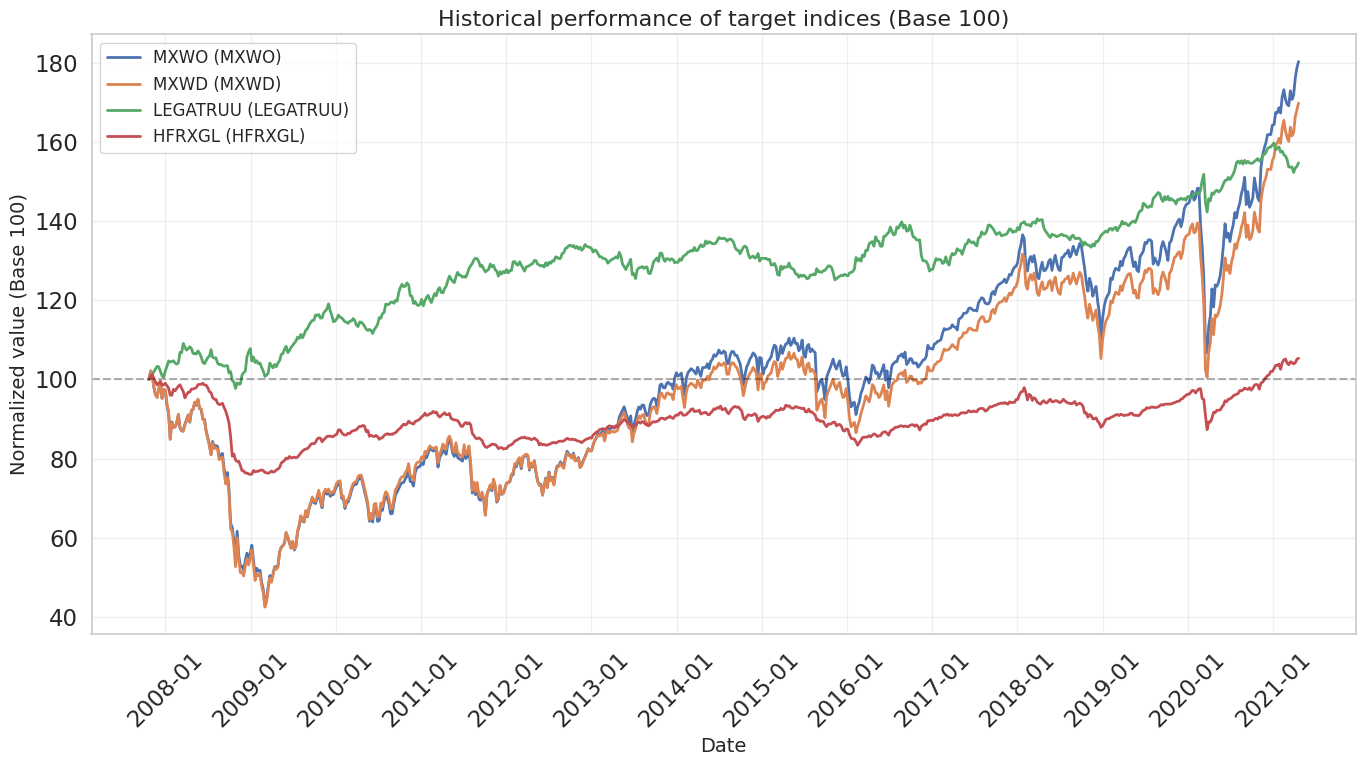


Return statistics for target indices:


Annualized Return Annualized Volatility  Sharpe Ratio Max Drawdown  \
MXWO                 5.90%                17.52%      0.336955      -57.61%   
MXWD                 5.51%                17.78%      0.309683      -58.39%   
LEGATRUU             3.37%                 5.34%      0.630472      -10.41%   
HFRXGL               0.50%                 4.78%      0.104156      -24.91%   

          Skewness   Kurtosis  
MXWO     -0.682289   4.357034  
MXWD     -0.641270   4.663275  
LEGATRUU -0.329675   4.118169  
HFRXGL   -2.301318  13.702270

In [ ]:
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter

# Target indices to explore
target_indices = ['MXWO', 'MXWD', 'LEGATRUU', 'HFRXGL']

# Create a figure for the historical price series
plt.figure(figsize=(14, 8))

# Plot each index
for idx in target_indices:
    # Normalize to 100 at the beginning for comparison
    normalized_series = data[idx] / data[idx].iloc[0] * 100
    plt.plot(normalized_series.index, normalized_series, linewidth=2, label=f"{idx} ({variable_info.get(idx, idx)})")

# Format the plot
plt.title('Historical performance of target indices (Base 100)', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Normalized value (Base 100)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(loc='best', fontsize=12)

# Format the x-axis to show dates nicely
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.xticks(rotation=45)

# Add a horizontal line at y=100
plt.axhline(y=100, color='black', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate and display statistics for all indices
print("\nReturn statistics for target indices:")
# Calculate returns
returns = data[target_indices].pct_change().dropna()

# Calculate annualized statistics (assuming weekly data)
annual_factor = 52  # For weekly data (52 weeks = 1 year)

# Format as percentage with 2 decimal places
def format_pct(x):
    return f"{x*100:.2f}%"

stats = pd.DataFrame({
    'Annualized Return': returns.mean() * annual_factor,
    'Annualized Volatility': returns.std() * np.sqrt(annual_factor),
    'Sharpe Ratio': (returns.mean() * annual_factor) / (returns.std() * np.sqrt(annual_factor)),
    'Max Drawdown': returns.apply(lambda x: (1 + x).cumprod().div((1 + x).cumprod().cummax()) - 1).min(),
    'Skewness': returns.skew(),
    'Kurtosis': returns.kurtosis()
})

# Convert some columns to percentage format for better readability
for col in ['Annualized Return', 'Annualized Volatility', 'Max Drawdown']:
    stats[col] = stats[col].apply(format_pct)

display(stats)


### Correlation & probability distribution analysis
Understanding the shape and the relationships between different indices helps us understanding the behavior of our ingredients and identify potential replication components.

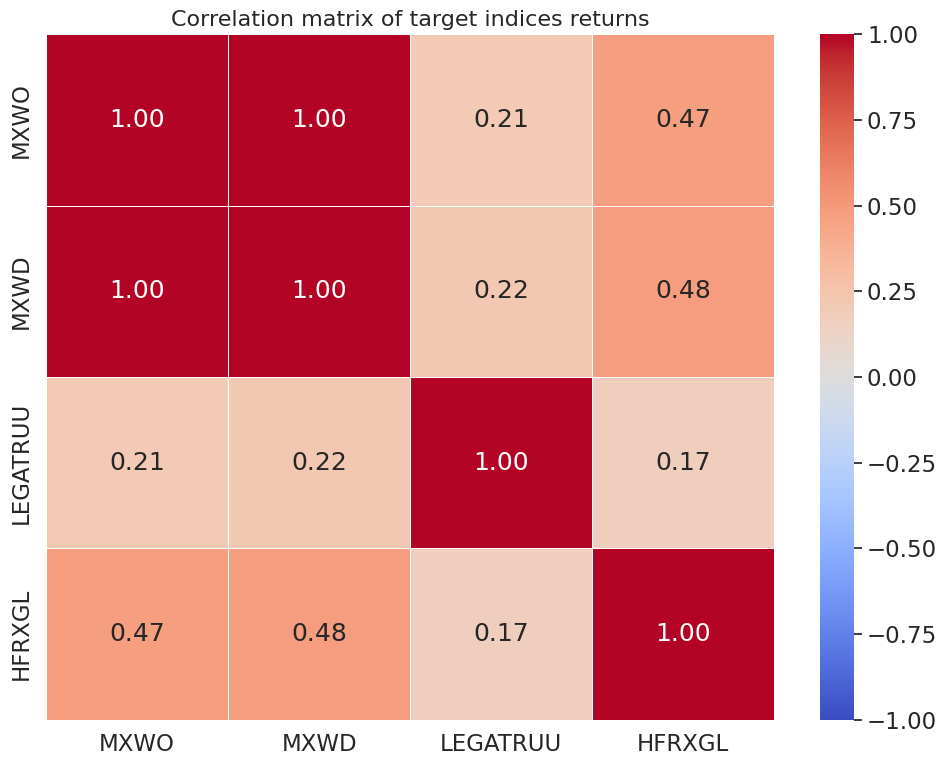

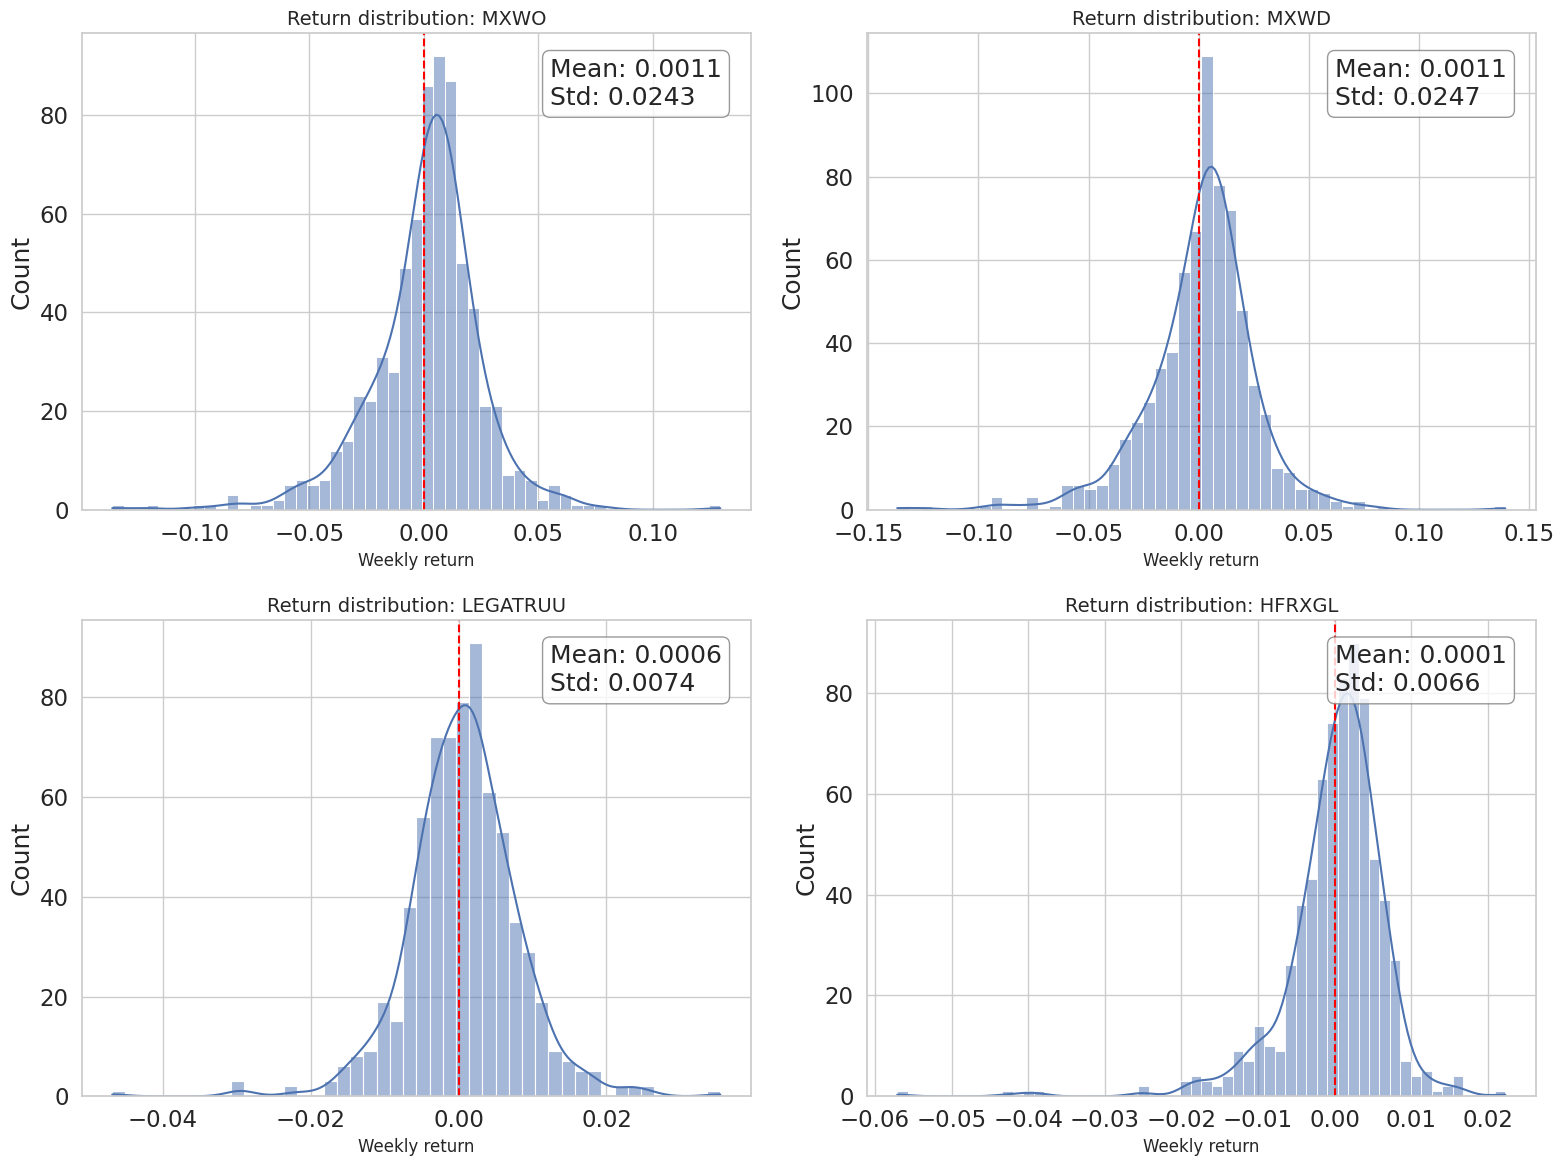

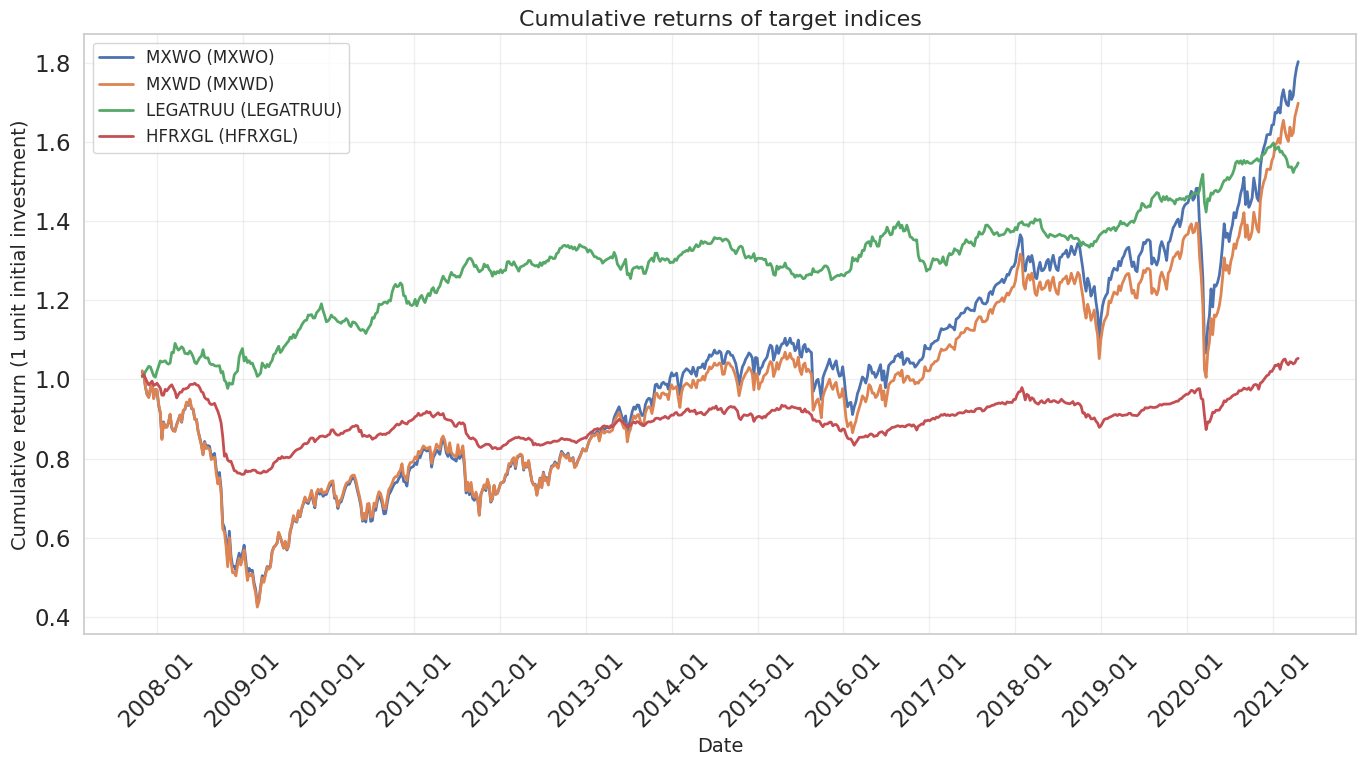

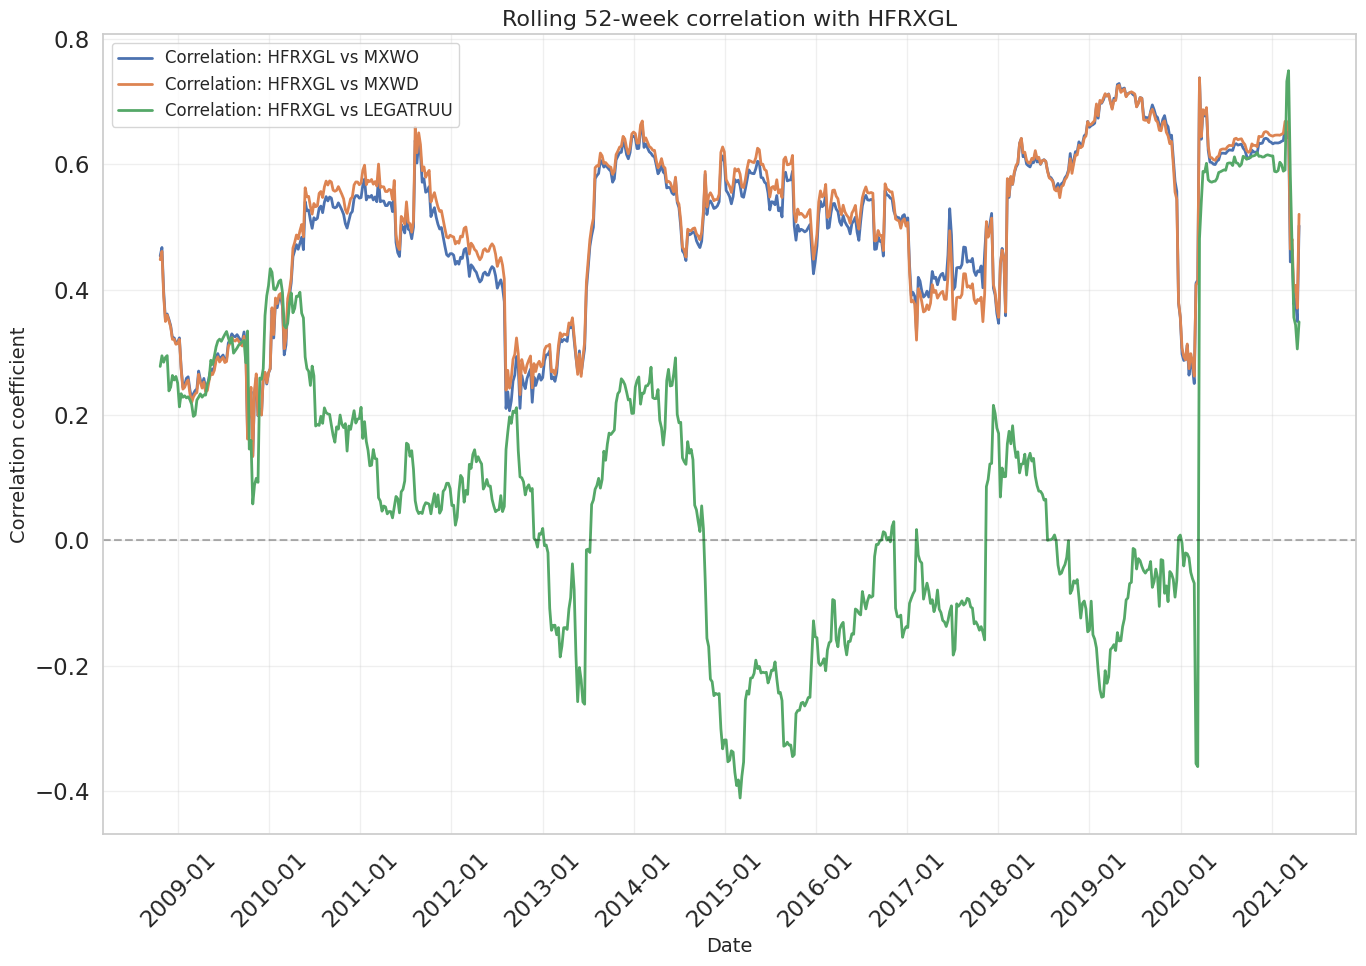

In [ ]:
# Create a correlation heatmap for the target indices
plt.figure(figsize=(10, 8))
correlation_matrix = returns[target_indices].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1,
            linewidths=0.5, fmt='.2f')
plt.title('Correlation matrix of target indices returns', fontsize=16)
plt.tight_layout()
plt.show()

# Plot returns distribution
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for i, idx in enumerate(target_indices):
    sns.histplot(returns[idx], kde=True, ax=axes[i])
    axes[i].set_title(f'Return distribution: {idx}', fontsize=14)
    axes[i].set_xlabel('Weekly return', fontsize=12)
    axes[i].axvline(x=0, color='red', linestyle='--')
    # Add mean and std annotations
    mean = returns[idx].mean()
    std = returns[idx].std()
    axes[i].annotate(f'Mean: {mean:.4f}\nStd: {std:.4f}',
                     xy=(0.7, 0.85), xycoords='axes fraction',
                     bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

plt.tight_layout()
plt.show()

# Compute cumulative returns for visualization
cumulative_returns = (1 + returns).cumprod()

# Plot cumulative returns
plt.figure(figsize=(14, 8))
for idx in target_indices:
    plt.plot(cumulative_returns.index, cumulative_returns[idx], linewidth=2,
             label=f"{idx} ({variable_info.get(idx, idx)})")

plt.title('Cumulative returns of target indices', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Cumulative return (1 unit initial investment)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(loc='best', fontsize=12)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot rolling correlations over time (12-month window)
rolling_window = 52  # 52 weeks ≈ 1 year
plt.figure(figsize=(14, 10))

# Base correlation against HFRXGL (Hedge Fund Index)
base_idx = 'HFRXGL'
for idx in [i for i in target_indices if i != base_idx]:
    roll_corr = returns[[base_idx, idx]].rolling(rolling_window).corr().unstack()[base_idx][idx]
    plt.plot(roll_corr.index, roll_corr, linewidth=2,
             label=f"Correlation: {base_idx} vs {idx}")

plt.title(f'Rolling {rolling_window}-week correlation with {base_idx}', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Correlation coefficient', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(loc='best', fontsize=12)
plt.axhline(y=0, color='black', linestyle='--', alpha=0.3)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


<br>

Let's examine the statistical properties of our target indices.


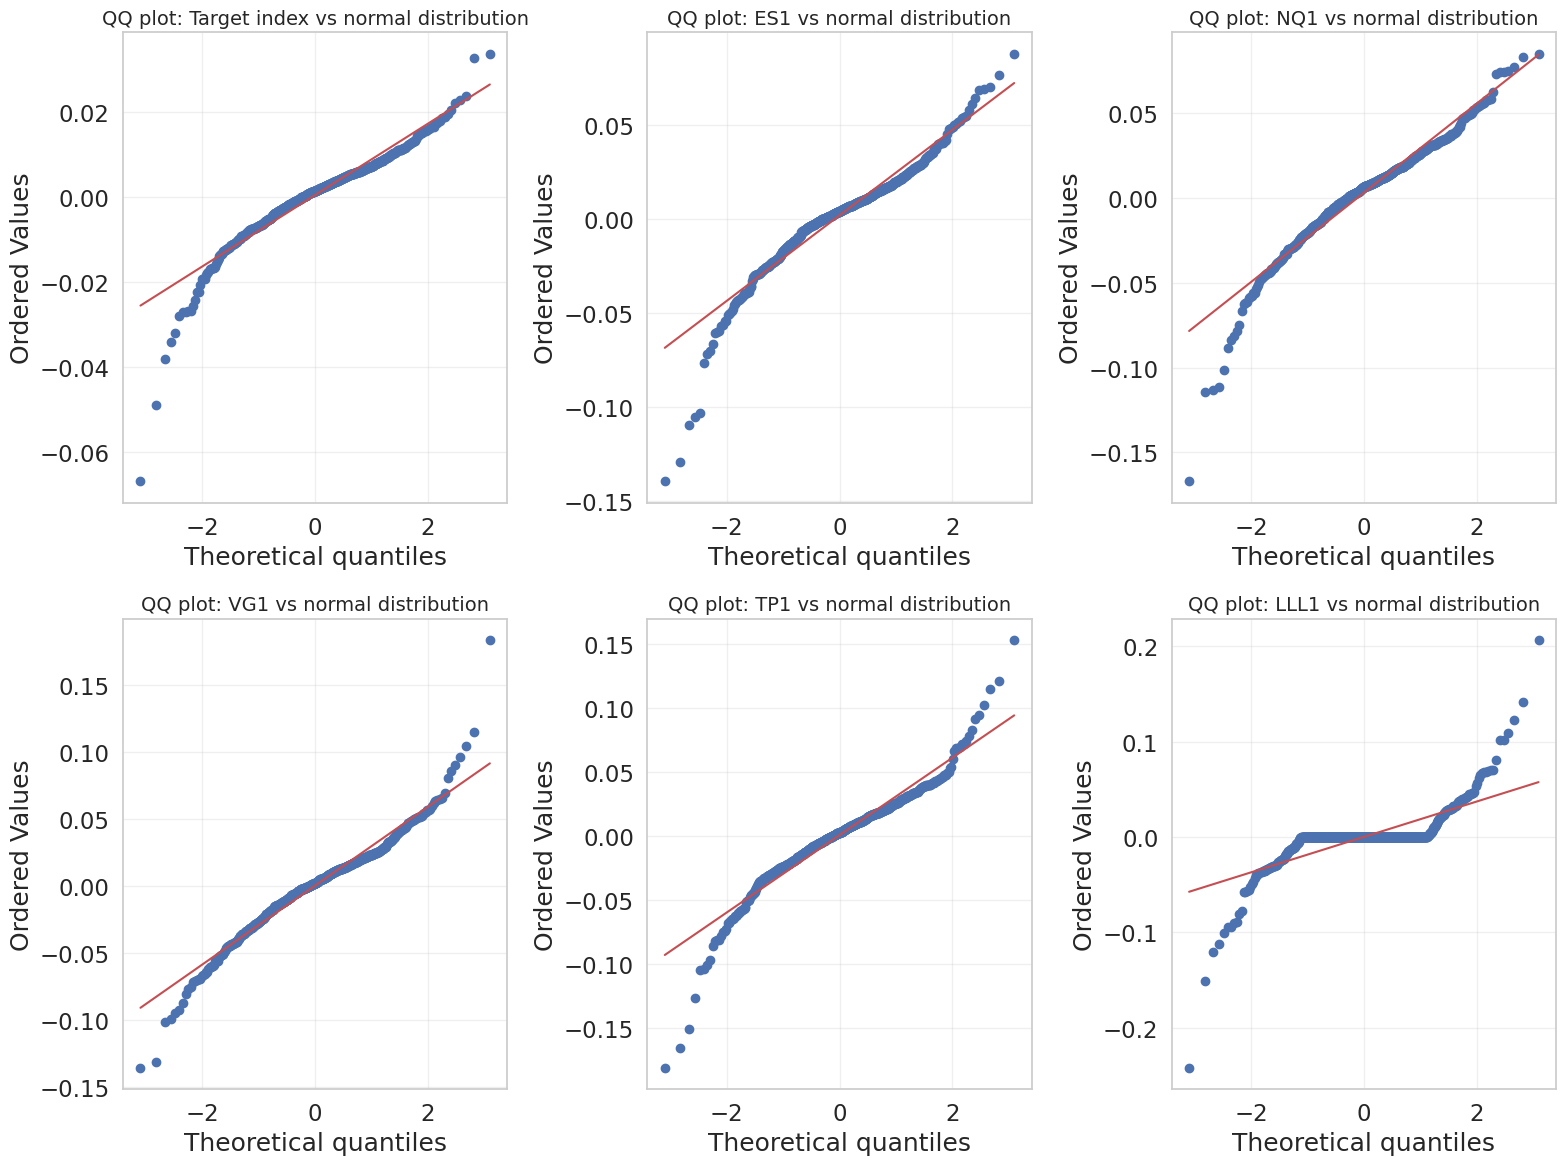

In [ ]:
# Some QQ plots for key variables
import scipy.stats as stats
from statsmodels.graphics.gofplots import qqplot
import warnings

# Suppress specific boring RuntimeWarnings
warnings.filterwarnings("ignore", category=RuntimeWarning, message="invalid value encountered in divide")

# Define the components of our target index with their weights
# You can be creative, this is just an example
# Monster Index (a crazy combination of large indexes)
index_components = {
    'HFRXGL': 0.50,   # Hedge Fund Index - 50%
    'MXWO': 0.25,     # MSCI World - 25%
    'LEGATRUU': 0.25  # Global Aggregate Bond - 25%
}

# Calculate returns for each component
component_returns = data[list(index_components.keys())].pct_change().dropna()

# Create the target index using weighted returns
weighted_returns = pd.DataFrame(index=component_returns.index)
for component, weight in index_components.items():
    weighted_returns[component] = component_returns[component] * weight

# Sum the weighted returns to get the target index returns
target_returns = weighted_returns.sum(axis=1)
target_returns.name = 'Target_Index'

# Define the futures contracts we'll use for replication
futures_contracts = [
    'RX1', 'TY1', 'GC1', 'CO1',
    'ES1', 'VG1', 'NQ1', 'LLL1',
    'TP1', 'DU1', 'TU2'
]

# Calculate returns for futures contracts
futures_returns = data[futures_contracts].pct_change().dropna()

# Ensure we're using the same date range for both target and futures
common_dates = futures_returns.index.intersection(target_returns.index)
futures_returns = futures_returns.loc[common_dates]
target_returns_aligned = target_returns.loc[common_dates]

# Calculate correlations between target index and futures contracts using pandas method
# which handles NaN values better than np.corrcoef
correlations = pd.DataFrame(index=futures_contracts,
                           columns=['Correlation with target index'])

for contract in futures_contracts:
    correlations.loc[contract] = target_returns_aligned.corr(futures_returns[contract])

# Sort by absolute correlation value
correlations['Abs correlation'] = correlations['Correlation with target index'].abs()
correlations = correlations.sort_values('Abs correlation', ascending=False)
correlations = correlations.drop('Abs correlation', axis=1)

# Now create the QQ plots
plt.figure(figsize=(16, 12))

# Plot QQ plot for the target index
plt.subplot(2, 3, 1)
stats.probplot(target_returns_aligned.dropna(), dist="norm", plot=plt)
plt.title(f'QQ plot: Target index vs normal distribution', fontsize=14)
plt.grid(True, alpha=0.3)

# Select a few key futures contracts (top 3 by correlation with target)
top_futures = correlations.index[:5].tolist()

# Create QQ plots for top futures
for i, contract in enumerate(top_futures):
    plt.subplot(2, 3, i+2)

    # Get returns data for this contract
    returns_data = futures_returns[contract].dropna()

    # Create QQ plot
    stats.probplot(returns_data, dist="norm", plot=plt)

    # Add title and improve appearance
    plt.title(f'QQ plot: {contract} vs normal distribution', fontsize=14)
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



In [ ]:
# Print the top correlated futures, just for reference
print("Top futures contracts by correlation with target index:")
display(correlations.head())

Top futures contracts by correlation with target index:


Correlation with target index
ES1                       0.837925
NQ1                       0.746908
VG1                       0.730608
TP1                       0.598764
LLL1                      0.498685

<br>

We'll analyze the **autocorrelation** properties of our target indices to understand their time series behavior. It is possible to take this into account in modelling, and in any case it is better to know what the situation is.

<br>

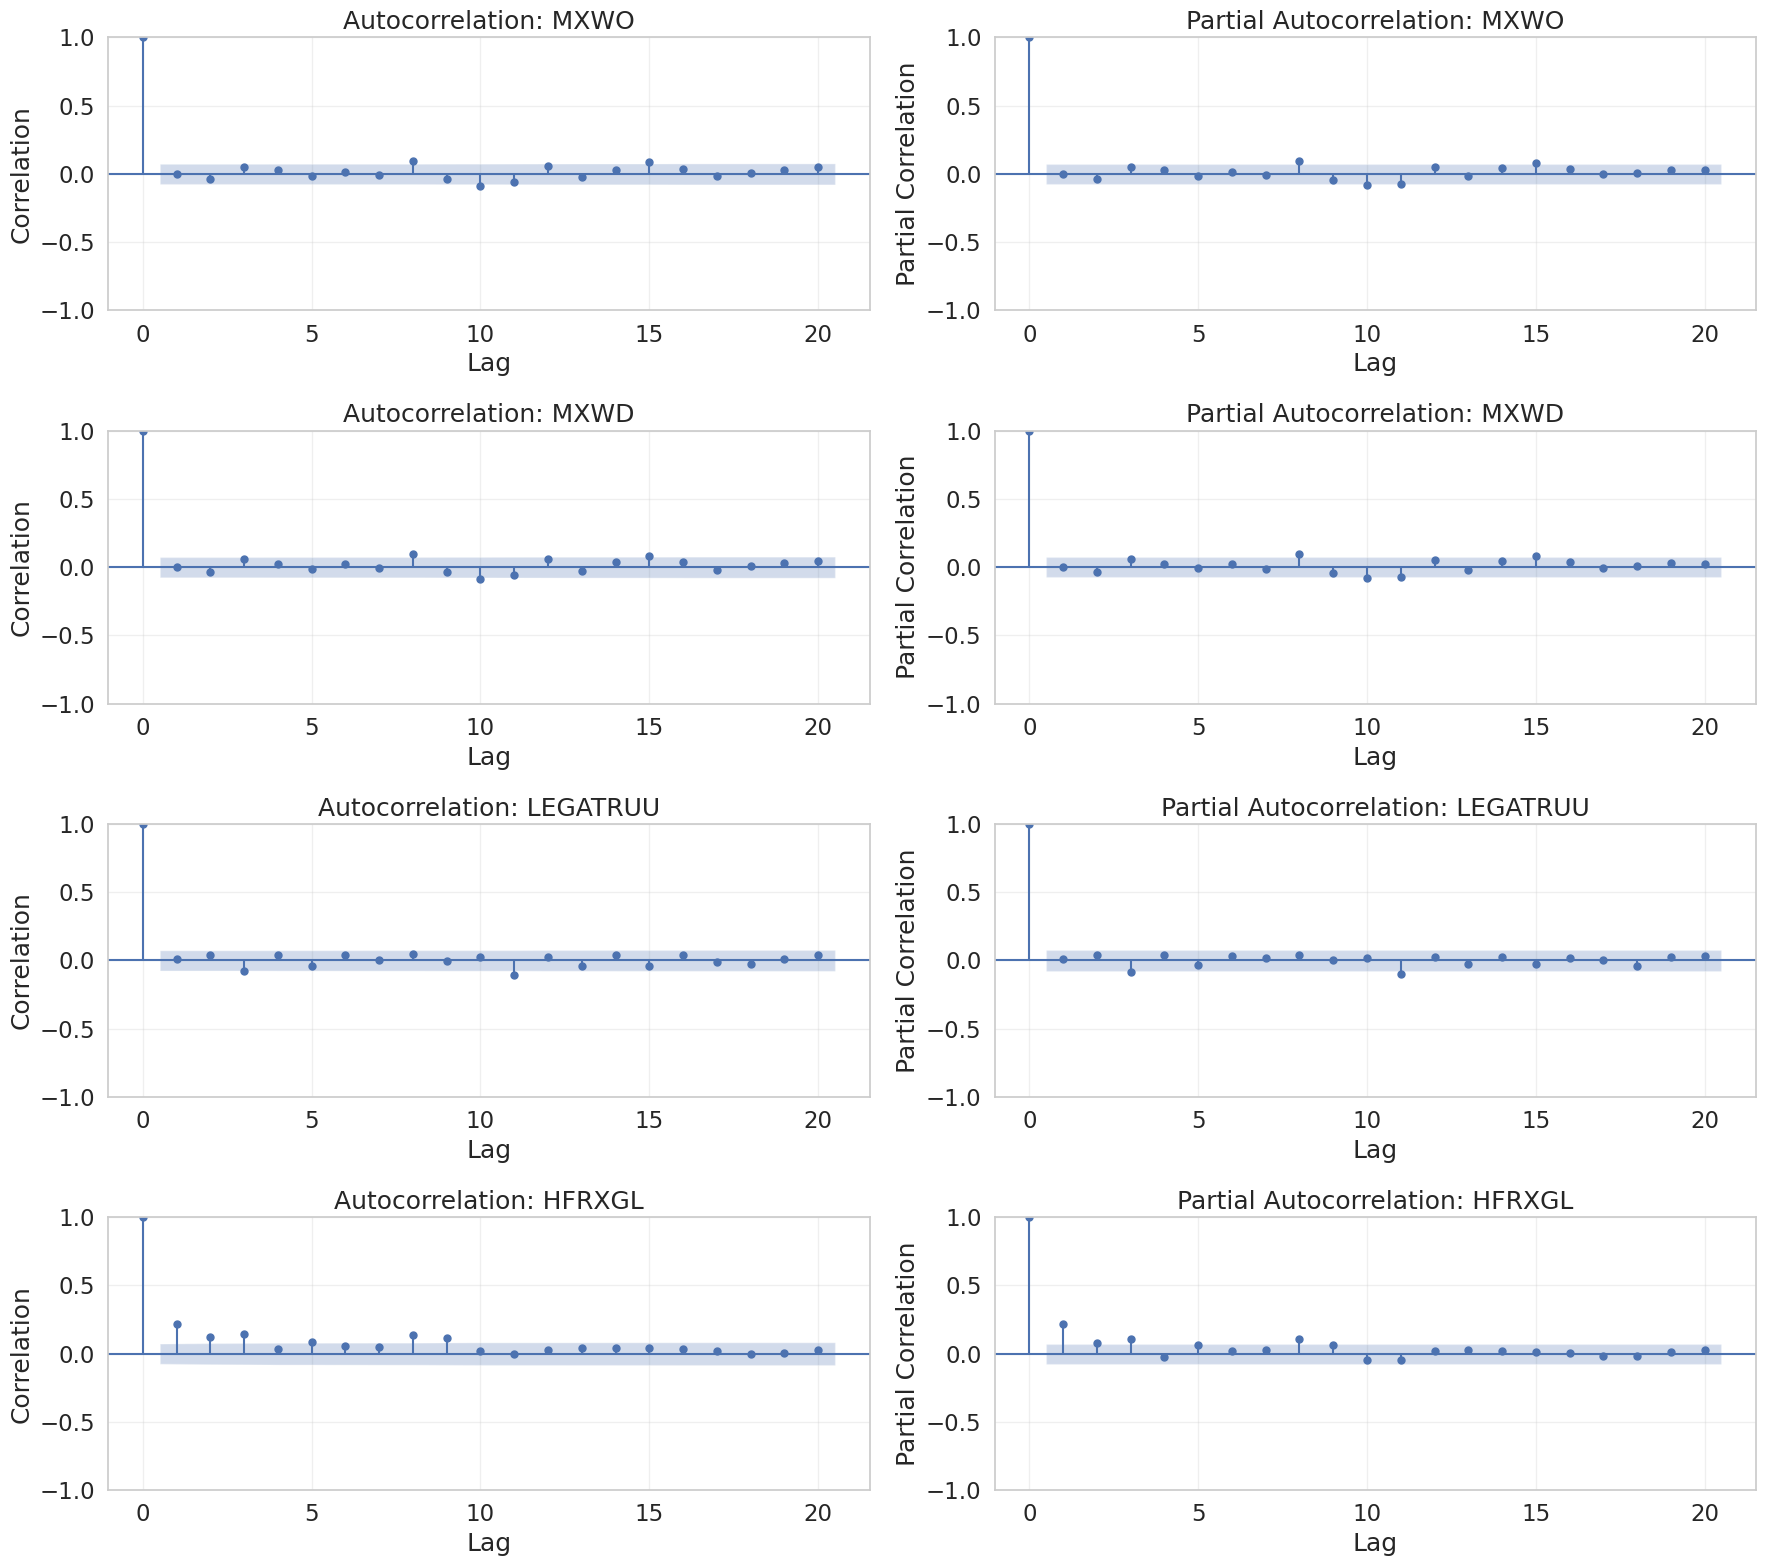

In [ ]:
# Autocorrelation and Partial Autocorrelation analysis
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Define the maximum number of lags to analyze
max_lags = 20

# Create a figure for ACF and PACF plots
fig, axes = plt.subplots(len(target_indices), 2, figsize=(18, 4*len(target_indices)))

# For each target index
for i, idx in enumerate(target_indices):
    # Get returns data for this index
    returns_data = returns[idx].dropna()

    # Plot ACF (Autocorrelation Function)
    plot_acf(returns_data,
             lags=max_lags,
             ax=axes[i, 0],
             title=f'Autocorrelation: {idx}',
             alpha=0.05)  # 95% confidence intervals

    axes[i, 0].set_xlabel('Lag')
    axes[i, 0].set_ylabel('Correlation')
    axes[i, 0].grid(True, alpha=0.3)

    # Plot PACF (Partial Autocorrelation Function)
    plot_pacf(returns_data,
              lags=max_lags,
              ax=axes[i, 1],
              title=f'Partial Autocorrelation: {idx}',
              alpha=0.05)  # 95% confidence intervals

    axes[i, 1].set_xlabel('Lag')
    axes[i, 1].set_ylabel('Partial Correlation')
    axes[i, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Some **statistical tests for Autocorrelation**:
Let's perform formal statistical tests to check for autocorrelation in our return series.

In [ ]:
# Ljung-Box test for autocorrelation
from statsmodels.stats.diagnostic import acorr_ljungbox

print("\nLjung-Box test for Autocorrelation (H0: No autocorrelation)")
for idx in target_indices:
    # Get returns data for this index
    returns_data = returns[idx].dropna()

    # Perform Ljung-Box test for different lags
    lb_test = acorr_ljungbox(returns_data, lags=[5, 10, 15, 20])

    print(f"\n{idx}:")
    print(f"  Lag 5:  Test Statistic = {lb_test.iloc[0, 0]:.4f}, p-value = {lb_test.iloc[0, 1]}")
    print(f"  Lag 10: Test Statistic = {lb_test.iloc[1, 0]:.4f}, p-value = {lb_test.iloc[1, 1]}")
    print(f"  Lag 15: Test Statistic = {lb_test.iloc[2, 0]:.4f}, p-value = {lb_test.iloc[2, 1]}")
    print(f"  Lag 20: Test Statistic = {lb_test.iloc[3, 0]:.4f}, p-value = {lb_test.iloc[3, 1]}")



Ljung-Box test for Autocorrelation (H0: No autocorrelation)

MXWO:
  Lag 5:  Test Statistic = 3.7194, p-value = 0.5904826835237523
  Lag 10: Test Statistic = 16.3144, p-value = 0.09097959418552602
  Lag 15: Test Statistic = 27.3792, p-value = 0.025794024133669786
  Lag 20: Test Statistic = 31.2372, p-value = 0.05213647169188273

MXWD:
  Lag 5:  Test Statistic = 4.0704, p-value = 0.5393259449870617
  Lag 10: Test Statistic = 17.4323, p-value = 0.0653285681259841
  Lag 15: Test Statistic = 28.4624, p-value = 0.01884764990020632
  Lag 20: Test Statistic = 32.0118, p-value = 0.04317225310351364

LEGATRUU:
  Lag 5:  Test Statistic = 8.3823, p-value = 0.13638623700810792
  Lag 10: Test Statistic = 11.6799, p-value = 0.3070516668391241
  Lag 15: Test Statistic = 23.8265, p-value = 0.0680996594303596
  Lag 20: Test Statistic = 26.5486, p-value = 0.14844897874762528

HFRXGL:
  Lag 5:  Test Statistic = 63.9540, p-value = 1.8467256432800833e-12
  Lag 10: Test Statistic = 90.7371, p-value = 3.824

<br>

**Volatility Clustering Analysis**: Financial returns often exhibit volatility clustering - periods of high volatility tend to be followed by similar high volatility periods. We'll examine this phenomenon: as before, it is possible to take this into account in the modelling, and in any case it is better to know what the situation is.

<br>

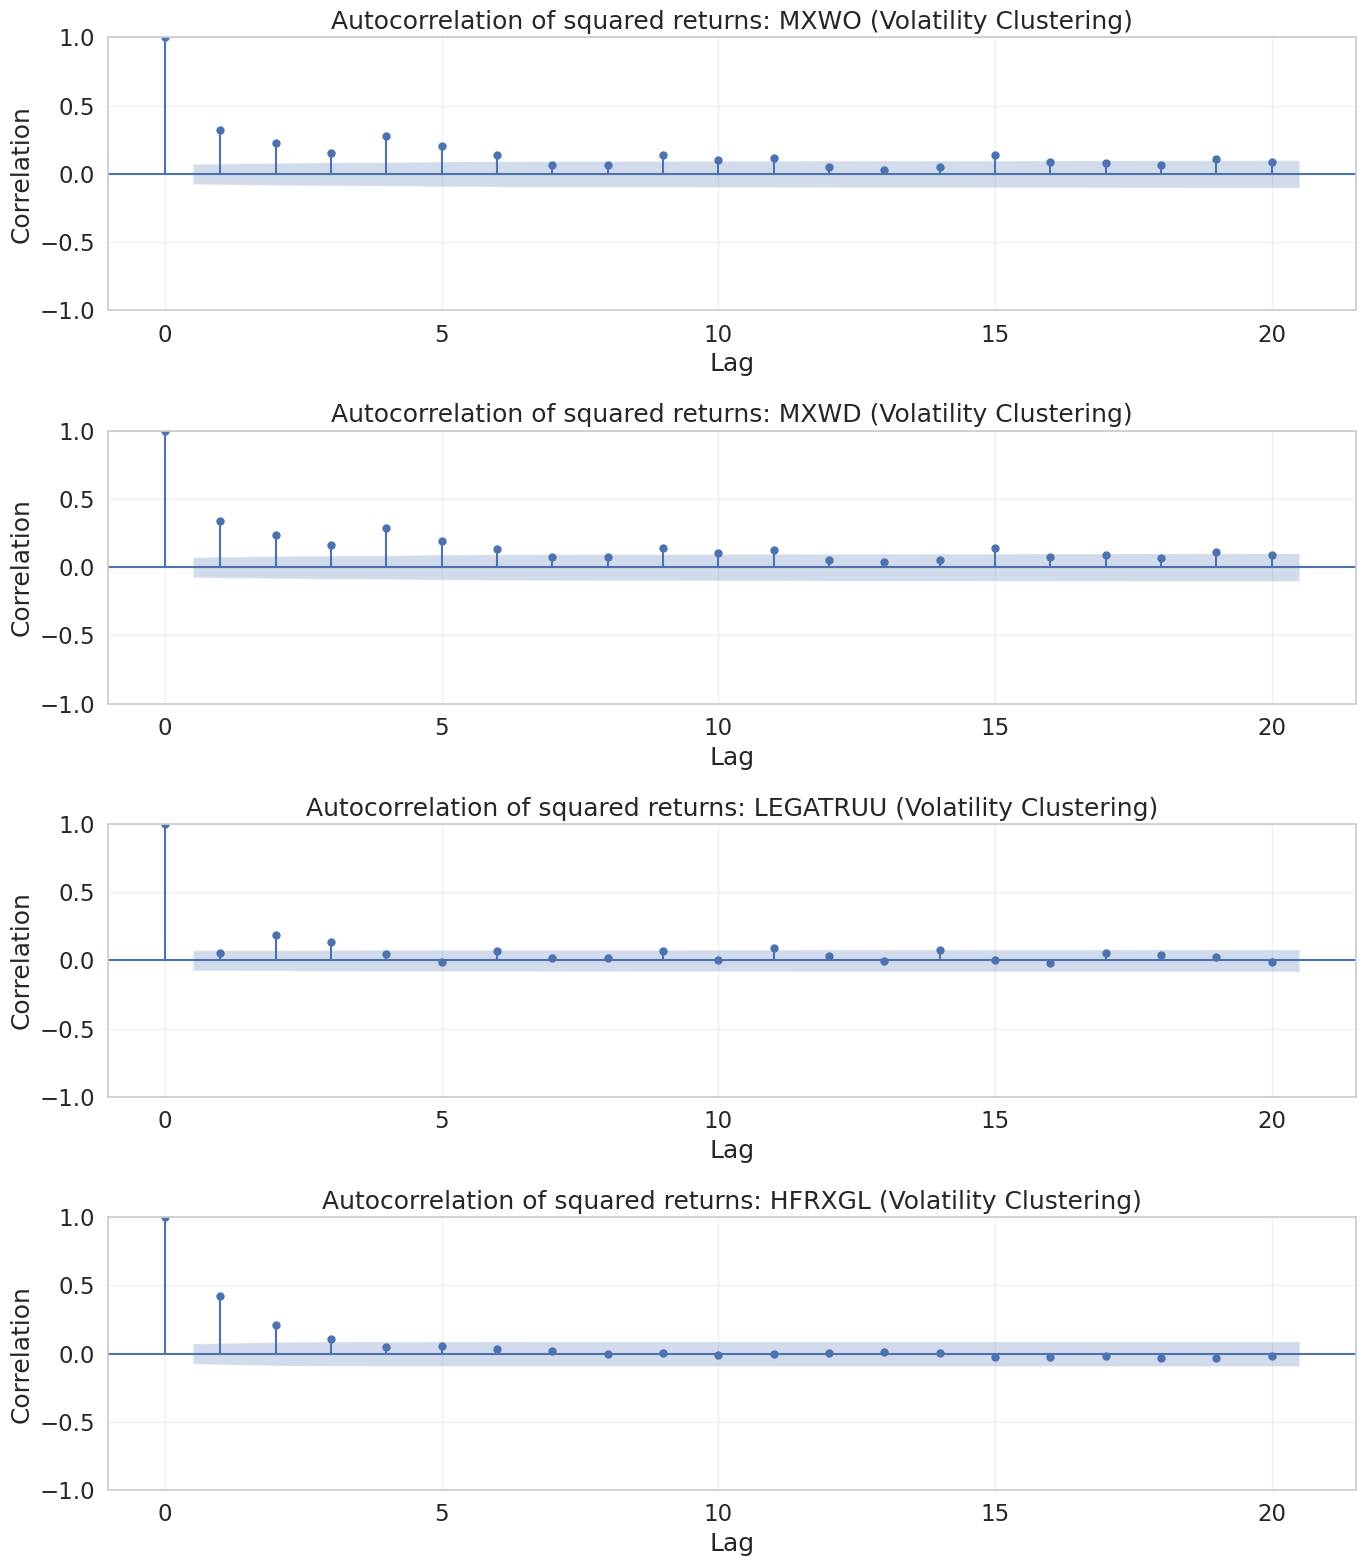

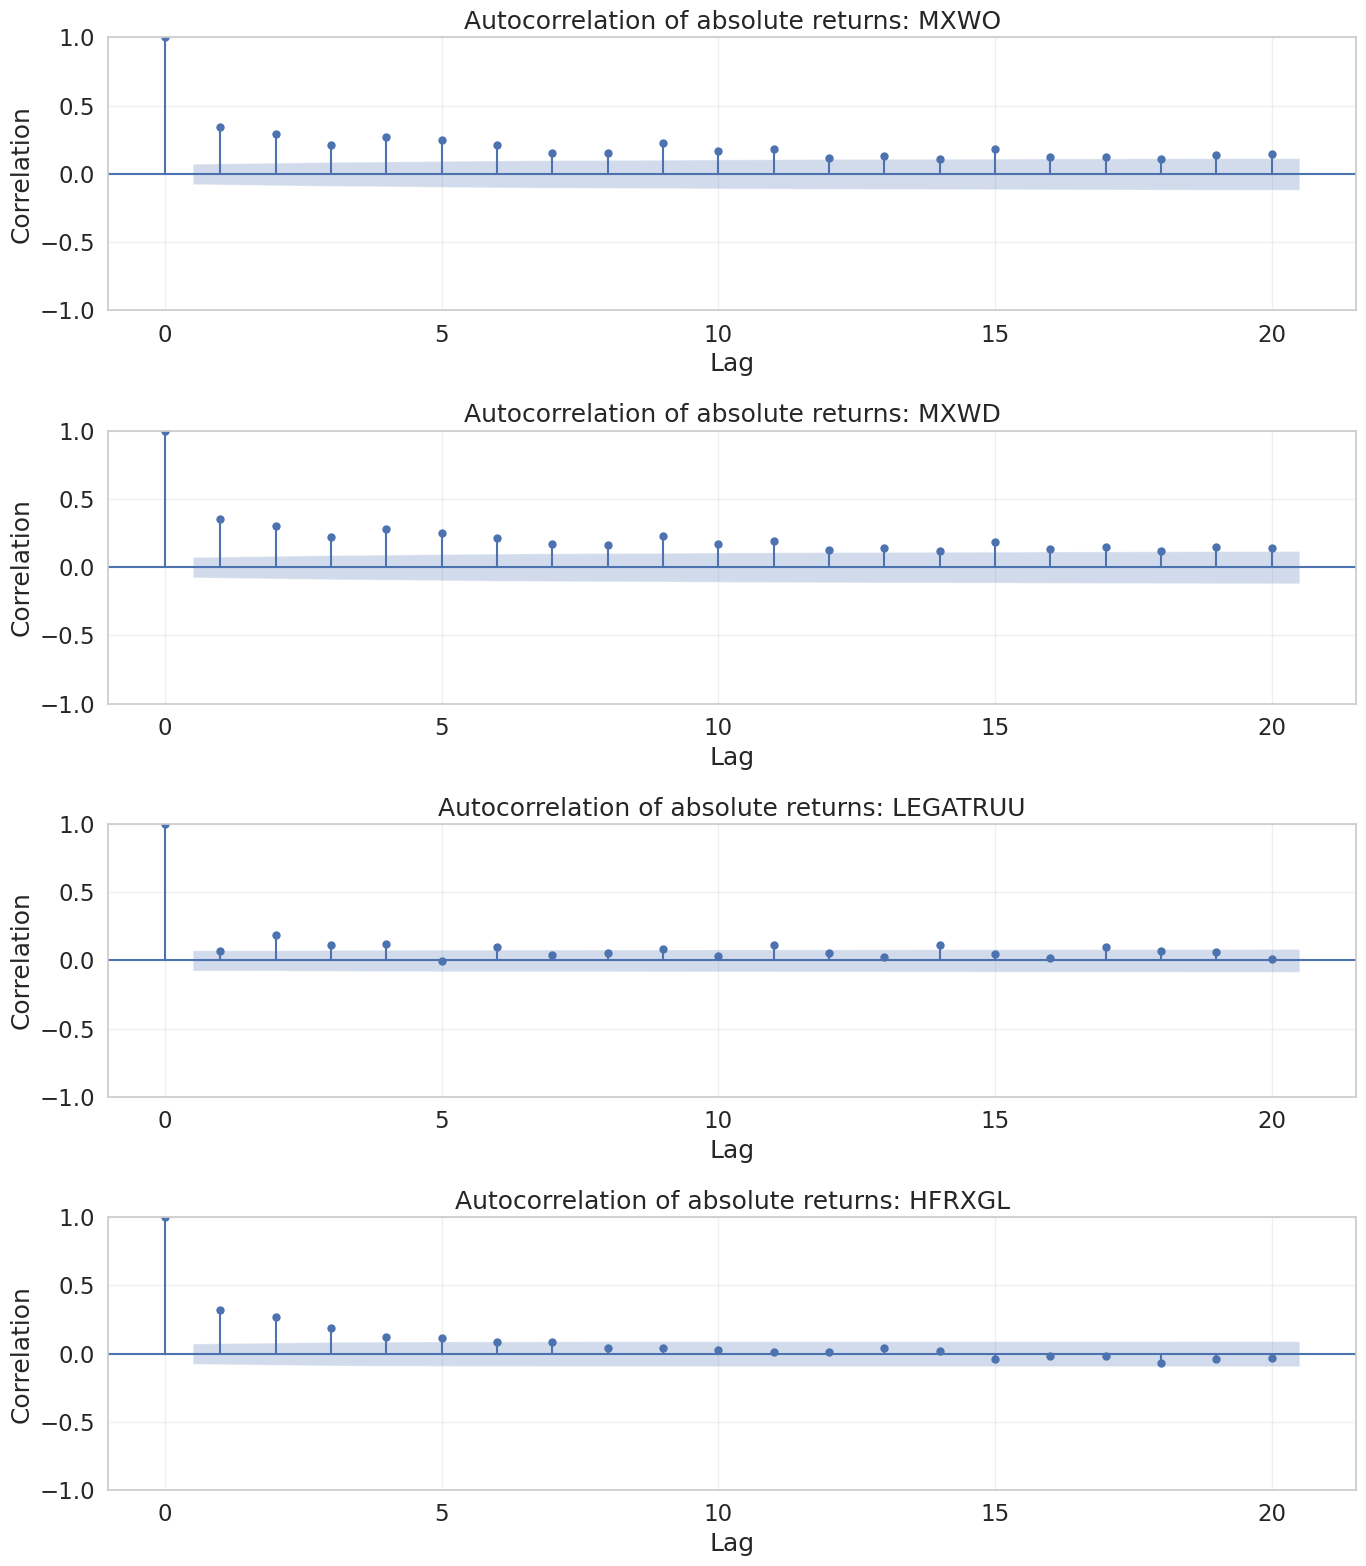

In [ ]:
# Create a figure for squared returns ACF (volatility clustering)
fig, axes = plt.subplots(len(target_indices), 1, figsize=(14, 4*len(target_indices)))

# For each target index
for i, idx in enumerate(target_indices):
    # Get squared returns data for this index (for volatility clustering, ie GARC-like situations)
    squared_returns = returns[idx].dropna() ** 2

    # Plot ACF of squared returns
    plot_acf(squared_returns,
             lags=max_lags,
             ax=axes[i] if len(target_indices) > 1 else axes,
             title=f'Autocorrelation of squared returns: {idx} (Volatility Clustering)',
             alpha=0.05)  # 95% confidence intervals

    if len(target_indices) > 1:
        axes[i].set_xlabel('Lag')
        axes[i].set_ylabel('Correlation')
        axes[i].grid(True, alpha=0.3)
    else:
        axes.set_xlabel('Lag')
        axes.set_ylabel('Correlation')
        axes.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Create a figure for absolute returns ACF (another measure of volatility clustering)
fig, axes = plt.subplots(len(target_indices), 1, figsize=(14, 4*len(target_indices)))

# For each target index
for i, idx in enumerate(target_indices):
    # Get absolute returns data for this index
    abs_returns = abs(returns[idx].dropna())

    # Plot ACF of absolute returns
    plot_acf(abs_returns,
             lags=max_lags,
             ax=axes[i] if len(target_indices) > 1 else axes,
             title=f'Autocorrelation of absolute returns: {idx}',
             alpha=0.05)  # 95% confidence intervals

    if len(target_indices) > 1:
        axes[i].set_xlabel('Lag')
        axes[i].set_ylabel('Correlation')
        axes[i].grid(True, alpha=0.3)
    else:
        axes.set_xlabel('Lag')
        axes.set_ylabel('Correlation')
        axes.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


<br>

Now let's analyze our constructed target index, the Monster Index, and Futures contracts that are candidates to replicate it in more detail to understand its characteristics before attempting replication.

<br>

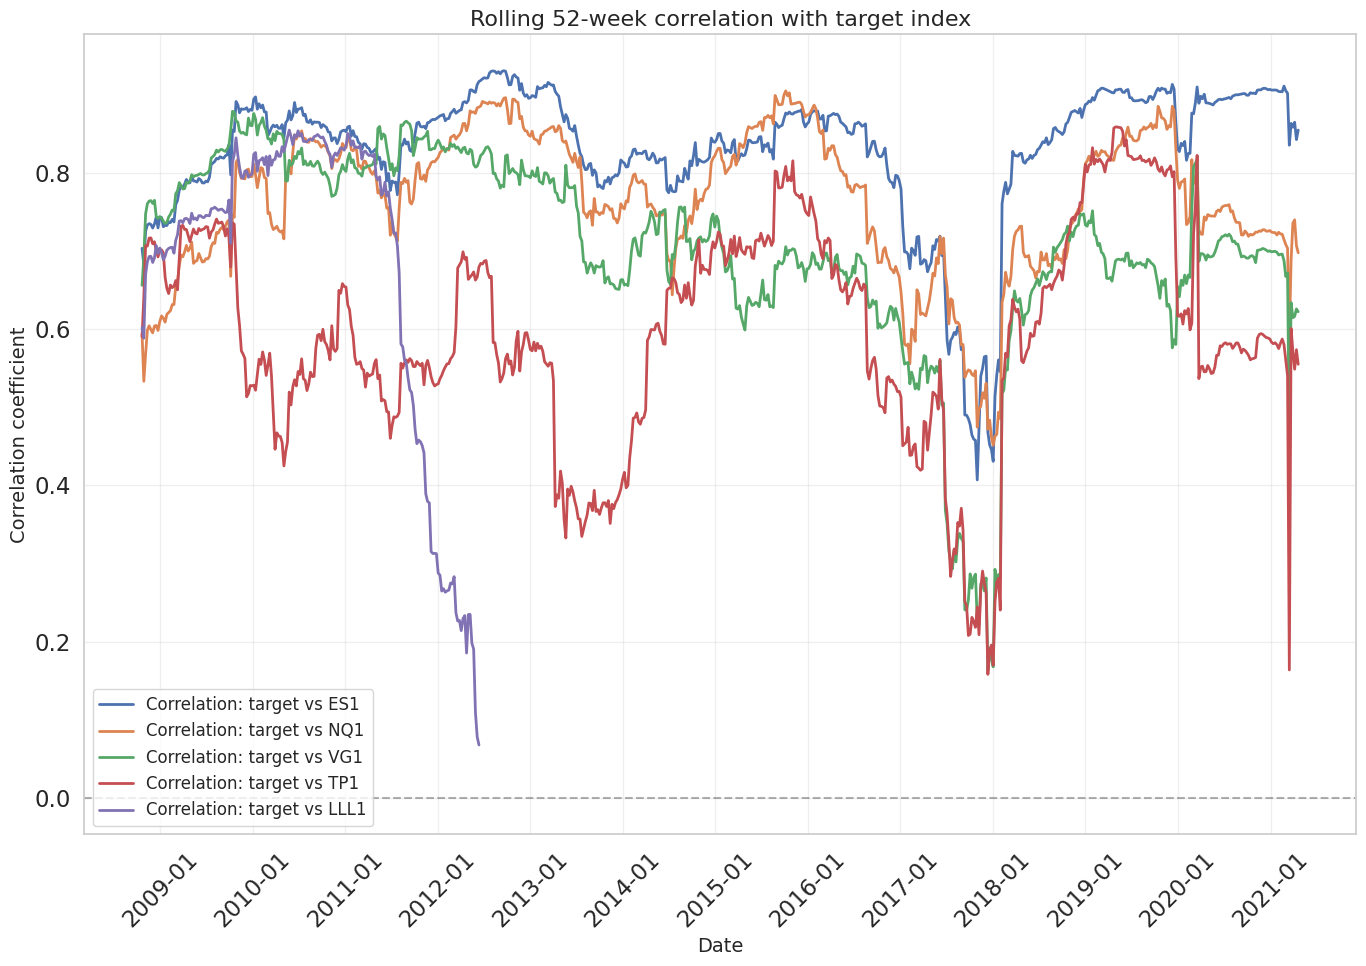

In [ ]:
# Plot rolling correlations between target index and Futures contracts
rolling_window = 52  # 52 weeks ≈ 1 year
plt.figure(figsize=(14, 10))

# Select top 5 futures by correlation (absolute value)
top_futures = correlations.index[:5].tolist()

for contract in top_futures:
    # Calculate rolling correlation
    combined_df = pd.DataFrame({
        'Target': target_returns_aligned,  # Fixed variable name
        'Future': futures_returns[contract]
    })
    rolling_corr = combined_df['Target'].rolling(rolling_window).corr(combined_df['Future'])

    # Plot
    plt.plot(rolling_corr.index, rolling_corr, linewidth=2,
             label=f"Correlation: target vs {contract}")

plt.title(f'Rolling {rolling_window}-week correlation with target index', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Correlation coefficient', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(loc='best', fontsize=12)
plt.axhline(y=0, color='black', linestyle='--', alpha=0.3)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


If you look at the time series and their correlations with the target, they have heterogeneous paths, so it's intuitive that they can be of help, if we want to replicate complex assets, such as our "Monster Index".

In [ ]:
# Calculate and display target index statistics
print("\nTarget index statistics:")
annual_factor = 52  # For weekly data

# Calculate statistics
mean_return = target_returns_aligned.mean() * annual_factor
volatility = target_returns_aligned.std() * np.sqrt(annual_factor)
sharpe_ratio = mean_return / volatility
cumulative_returns = (1 + target_returns_aligned).cumprod()
drawdowns = 1 - cumulative_returns / cumulative_returns.cummax()
max_drawdown = drawdowns.max()
skewness = target_returns_aligned.skew()
kurtosis = target_returns_aligned.kurtosis()

# Display statistics
stats_df = pd.DataFrame({
    'Statistic': ['Annualized return', 'Annualized volatility', 'Sharpe ratio',
                  'Max Drawdown', 'Skewness', 'Kurtosis'],
    'Value': [f"{mean_return*100:.2f}%",
              f"{volatility*100:.2f}%",
              f"{sharpe_ratio:.2f}",
              f"{max_drawdown*100:.2f}%",
              f"{skewness:.2f}",
              f"{kurtosis:.2f}"]
})

display(stats_df)

# Also calculate and display monthly returns statistics
if len(target_returns_aligned) >= 12:  # Ensure we have enough data
    # Resample to monthly returns using 'ME' (month end) frequency - more robust
    monthly_returns = target_returns_aligned.resample('ME').apply(
        lambda x: (1 + x).prod() - 1)

    # Calculate monthly statistics
    monthly_mean = monthly_returns.mean() * 12
    monthly_vol = monthly_returns.std() * np.sqrt(12)
    monthly_sharpe = monthly_mean / monthly_vol if monthly_vol > 0 else 0

    # Display monthly statistics
    print("\nMonthly return statistics:")
    monthly_stats = pd.DataFrame({
        'Statistic': ['Annualized return (monthly)',
                     'Annualized volatility (monthly)',
                     'Sharpe ratio (monthly)'],
        'Value': [f"{monthly_mean*100:.2f}%",
                 f"{monthly_vol*100:.2f}%",
                 f"{monthly_sharpe:.2f}"]
    })

    display(monthly_stats)



Target index statistics:


Statistic   Value
0      Annualized return   2.57%
1  Annualized volatility   6.33%
2           Sharpe ratio    0.41
3           Max Drawdown  29.01%
4               Skewness   -1.35
5               Kurtosis    7.64


Monthly return statistics:


Statistic  Value
0      Annualized return (monthly)  2.65%
1  Annualized volatility (monthly)  7.55%
2           Sharpe ratio (monthly)   0.35

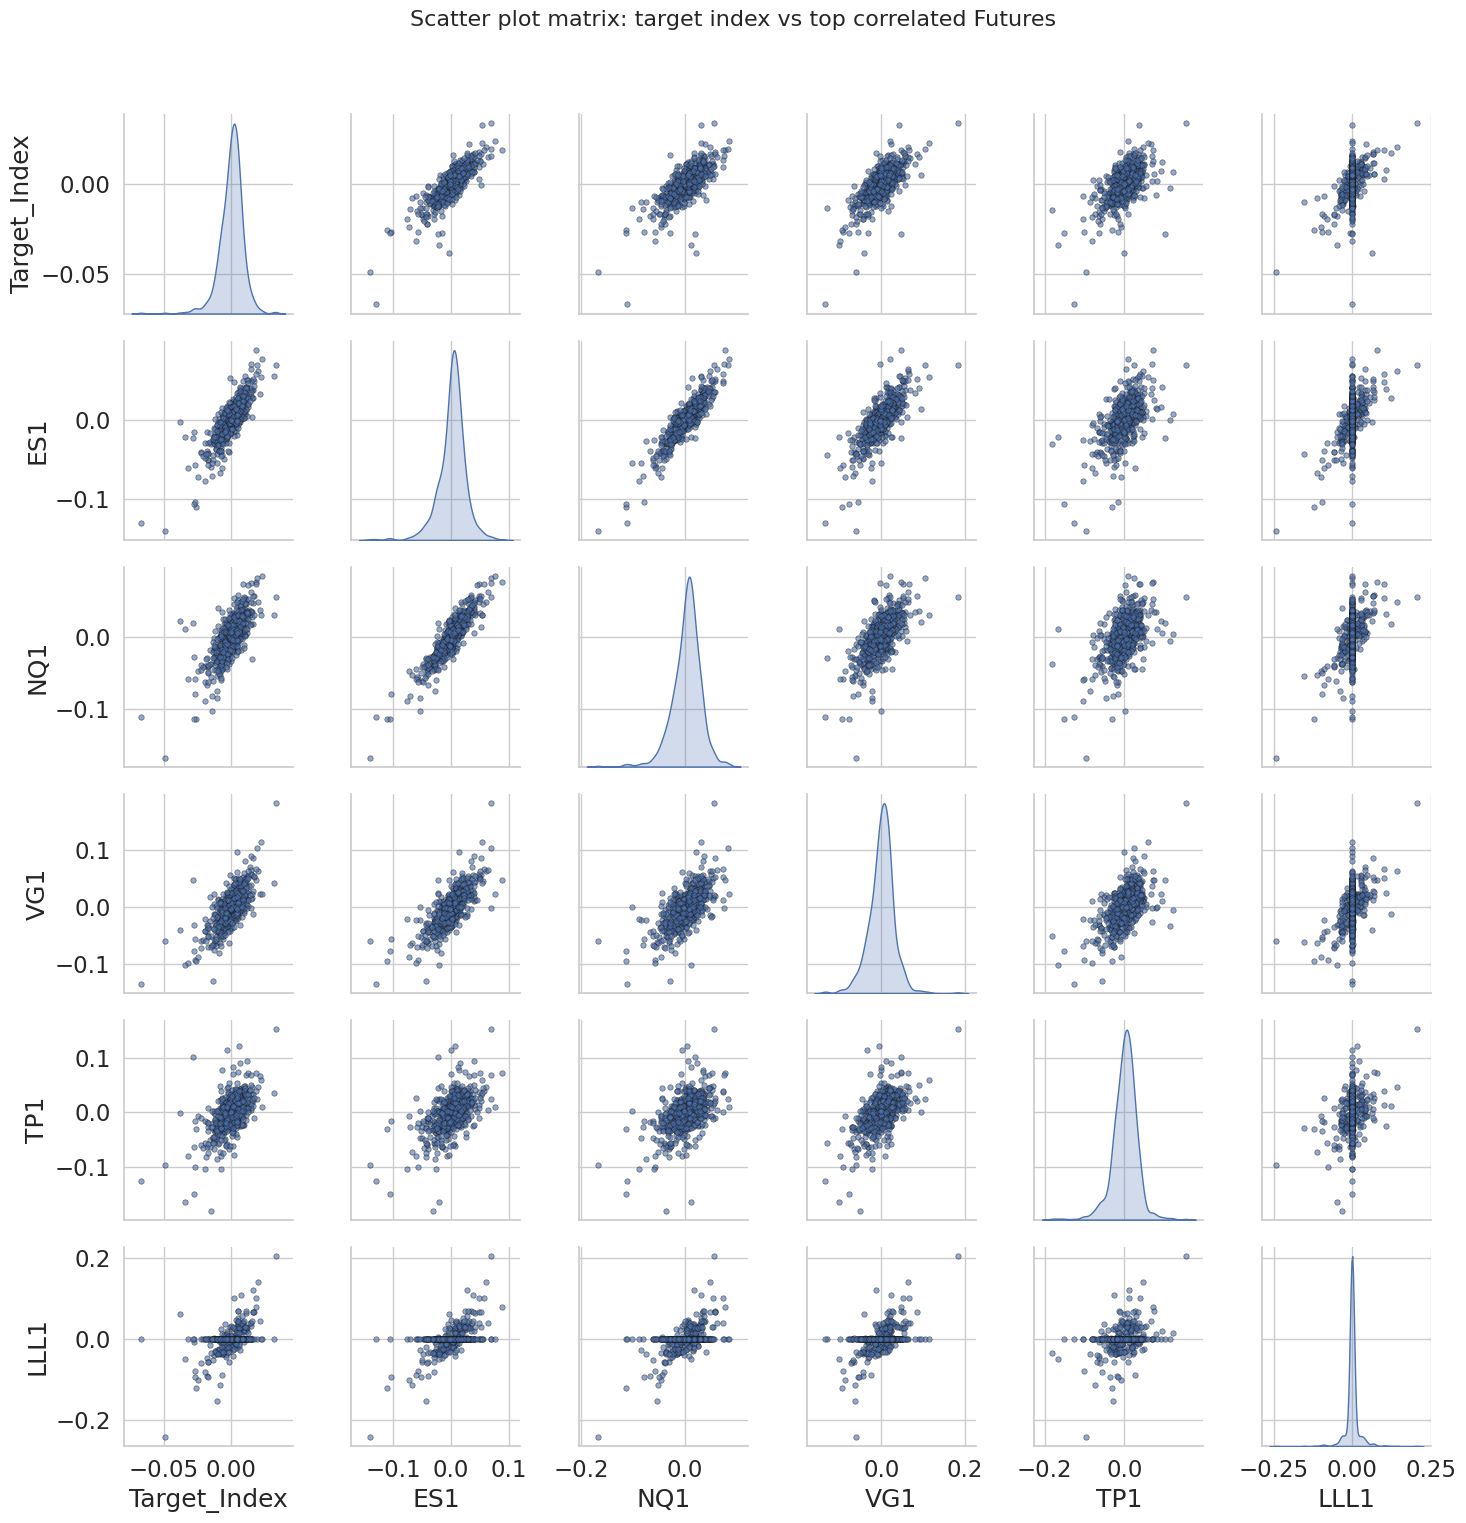

In [ ]:
# Create a scatter plot matrix for the target index and top correlated futures
top_futures_plus_target = ['Target_Index'] + top_futures
scatter_data = pd.concat([target_returns_aligned.rename('Target_Index'),
                          futures_returns[top_futures]], axis=1)

# Create a pair plot
sns.pairplot(scatter_data, kind='scatter', diag_kind='kde',
             plot_kws={'alpha': 0.6, 's': 15, 'edgecolor': 'k', 'linewidth': 0.5})
plt.suptitle('Scatter plot matrix: target index vs top correlated Futures',
             fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


## Linear models for portfolio replication

⚠️ Risk Constraint: Monthly VaR

1. Start simple: linear regression (OLS)
2. Ridge regression
3. Lasso regression
4. Elastic Net Regularization


In [ ]:
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import MinMaxScaler
from itertools import product

# Ensure data is properly aligned
y = target_returns_aligned  # Target index returns
X = futures_returns.loc[y.index]  # Futures returns aligned with target

# Define hyperparameter grid - this is rough, on purpose: you can do better
#alphas = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]  # remember: 0.0 = Ridge, 1.0 = Lasso
alphas = [0.0, 0.2, 0.4]
rolling_windows = [8, 52, 104, 156]  # in weeks (1Y, 2Y, 3Y)
l1_ratios = [0.0001, 0.001, 0.01]  # Regularization strength

# VaR parameters
var_confidence = 0.01  # 1% VaR
var_horizon = 4  # 4 weeks (1 month)
max_var_threshold = 0.08  # 20% maximum VaR(1%, 1 month)

# Convert to numpy arrays for easier indexing
X_values = X.values
y_values = y.values
dates_array = X.index.to_numpy()

# Suppress boring warnings during the loop
import warnings
warnings.filterwarnings('ignore')

# Function to calculate VaR
def calculate_var(returns, confidence=0.01, horizon=4):
    """
    Calculate Value at Risk (VaR) using a simple Gaussian model (you can do better)

    Parameters:
    returns (array-like): Historical returns
    confidence (float): Confidence level (e.g., 0.01 for 1% VaR)
    horizon (int): Time horizon in weeks

    Returns:
    float: VaR as a positive number (loss)
    """
    # Calculate standard deviation of returns
    sigma = np.std(returns)

    # Calculate VaR using a Gaussian model
    # For a loss, we use the negative of the quantile
    # We use the negative of the quantile because VaR represents a loss
    # Note: this is just a a widespread and questionable practice (which I do not loke because it is ambiguous, there could be a positive VaR)
    z_score = stats.norm.ppf(confidence)

    # Scale to the desired time horizon
    var = -z_score * sigma * np.sqrt(horizon)

    return var



<br>

Now let's run the model with various values ​​for the hyperparameters.

<br>

In [ ]:
# Function to run a single configuration with normalized returns and proper VaR scaling
def run_elastic_net_normalized(l1_ratio, rolling_window, alpha):
    # Initialize arrays to store results
    weights_history = []  # Store weights over time
    replica_returns = []  # Store replica portfolio returns
    target_dates = []  # Store dates for plotting
    gross_exposures = []  # Store gross exposure over time
    var_values = []  # Store VaR values over time
    scaling_factors = []  # Store scaling factors applied

    # Loop through the data using a rolling window approach as explained before
    for i in range(len(X) - rolling_window - 1):
        # Define training window
        start_idx = i
        end_idx = i + rolling_window

        # Extract training data
        X_train = X_values[start_idx:end_idx]
        y_train = y_values[start_idx:end_idx]

        # Normalize the training data using MinMaxScaler
        scaler_X = MinMaxScaler()
        X_train_normalized = scaler_X.fit_transform(X_train)

        # Normalize target
        scaler_y = MinMaxScaler()
        y_train_normalized = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()

        # Fit Elastic Net model with a given alpha
        model = ElasticNet(
            alpha=alpha,
            l1_ratio=l1_ratio,
            fit_intercept=False,
            max_iter=10000,
            tol=1e-4
        )

        model.fit(X_train_normalized, y_train_normalized)

        # Get the normalized weights
        normalized_weights = model.coef_

        # Calculate weights for original scale
        original_weights = normalized_weights / scaler_X.scale_

        # Default scaling factor
        scaling_factor = 1.0

        # If we have enough historical data, calculate VaR and scale if needed
        if len(replica_returns) >= 12:  # Need some history to calculate VaR...
            # Calculate historical replica returns using current weights
            historical_returns = []
            for j in range(max(0, len(replica_returns)-52), len(replica_returns)):
                # Get historical futures returns for this period
                hist_returns = X_values[end_idx-(len(replica_returns)-j)]
                # Calculate weighted return
                weighted_return = np.dot(hist_returns, original_weights)
                historical_returns.append(weighted_return)

            # Calculate VaR
            var = calculate_var(
                historical_returns,
                confidence=var_confidence,
                horizon=var_horizon
            )


            # Scale weights if VaR exceeds threshold
            if var > max_var_threshold:
                scaling_factor = max_var_threshold / var
                original_weights = original_weights * scaling_factor

                # Recalculate VaR after scaling to verify
                scaled_historical_returns = [ret * scaling_factor for ret in historical_returns]
                scaled_var = calculate_var(
                    scaled_historical_returns,
                    confidence=var_confidence,
                    horizon=var_horizon
                )

                var = scaled_var  # Update VaR value after scaling

            var_values.append(var)
        else:
            var_values.append(np.nan)

        # Store scaling factor
        scaling_factors.append(scaling_factor)

        # Calculate gross exposure (sum of absolute weights) after scaling
        gross_exposure = np.sum(np.abs(original_weights))
        gross_exposures.append(gross_exposure)

        # Store the weights after scaling
        weights_history.append(original_weights)

        # Calculate replica return for the next period (t+1)
        next_returns = X_values[end_idx]  # This is t+1

        # Use scaled original weights with original returns
        replica_return = np.dot(next_returns, original_weights)

        replica_returns.append(replica_return)

        # Store the date for t+1
        target_dates.append(dates_array[end_idx])

    # Convert results to pandas series for easier analysis
    replica_returns_series = pd.Series(replica_returns, index=target_dates)

    # Calculate cumulative returns for both target and replica
    aligned_target = y.loc[replica_returns_series.index]
    cumulative_target = (1 + aligned_target).cumprod()
    cumulative_replica = (1 + replica_returns_series).cumprod()

    # Calculate performance metrics
    replica_mean_return = replica_returns_series.mean() * 52  # annualized
    target_mean_return = aligned_target.mean() * 52  # annualized

    replica_vol = replica_returns_series.std() * np.sqrt(52)  # annualized
    target_vol = aligned_target.std() * np.sqrt(52)  # annualized

    replica_sharpe = replica_mean_return / replica_vol if replica_vol > 0 else 0
    target_sharpe = target_mean_return / target_vol if target_vol > 0 else 0

    # Calculate tracking error
    tracking_error = (replica_returns_series - aligned_target).std() * np.sqrt(52)
    information_ratio = (replica_mean_return - target_mean_return) / tracking_error if tracking_error > 0 else 0

    # Calculate drawdowns
    replica_drawdown = 1 - cumulative_replica / cumulative_replica.cummax()
    target_drawdown = 1 - cumulative_target / cumulative_target.cummax()

    # Calculate correlation
    correlation = replica_returns_series.corr(aligned_target)

    # Calculate average gross exposure
    avg_gross_exposure = np.mean(gross_exposures)

    # Calculate average VaR (excluding NaN values)
    avg_var = np.nanmean(var_values)

    # Return all metrics
    return {
        'l1_ratio': l1_ratio,
        'rolling_window': rolling_window,
        'alpha': alpha,
        'replica_return': replica_mean_return,
        'target_return': target_mean_return,
        'replica_vol': replica_vol,
        'target_vol': target_vol,
        'replica_sharpe': replica_sharpe,
        'target_sharpe': target_sharpe,
        'tracking_error': tracking_error,
        'information_ratio': information_ratio,
        'correlation': correlation,
        'max_drawdown': replica_drawdown.max(),
        'avg_gross_exposure': avg_gross_exposure,
        'avg_var': avg_var,
        'replica_returns': replica_returns_series,
        'aligned_target': aligned_target,
        'cumulative_replica': cumulative_replica,
        'cumulative_target': cumulative_target,
        'gross_exposures': gross_exposures,
        'var_values': var_values,
        'scaling_factors': scaling_factors,
        'weights_history': weights_history
    }

In [ ]:
# Run all combinations with normalized returns
results_normalized = []

for l1_ratio, rolling_window, alpha in product(l1_ratios, rolling_windows, alphas):
    result = run_elastic_net_normalized(l1_ratio, rolling_window, alpha)
    results_normalized.append(result)

# Convert results to DataFrame for easier analysis
results_df_normalized = pd.DataFrame(results_normalized)

# Sort by information ratio (higher is better) - our primary objective
sorted_results_normalized = results_df_normalized.sort_values(by='correlation', ascending=False)

# Display top 10 configurations by information ratio
print("\nTop 10 configurations by information ratio (normalized returns):")
display(sorted_results_normalized[['l1_ratio', 'rolling_window', 'alpha', 'information_ratio', 'correlation',
                       'tracking_error', 'replica_sharpe', 'avg_gross_exposure', 'avg_var']].head(10))

# Get the best configuration by information ratio
best_config_normalized = sorted_results_normalized.iloc[0]
print(f"\nBest configuration by information ratio (normalized returns): l1_ratio={best_config_normalized['l1_ratio']}, "
      f"rolling_window={best_config_normalized['rolling_window']}, alpha={best_config_normalized['alpha']}")




Top 10 configurations by information ratio (normalized returns):


l1_ratio  rolling_window  alpha  information_ratio  correlation  \
21    0.0010             156    0.0          -0.381873     0.782304   
33    0.0100             156    0.0          -0.381873     0.782304   
9     0.0001             156    0.0          -0.381873     0.782304   
6     0.0001             104    0.0          -0.503498     0.753044   
18    0.0010             104    0.0          -0.503498     0.753044   
30    0.0100             104    0.0          -0.503498     0.753044   
27    0.0100              52    0.0          -0.601426     0.733995   
3     0.0001              52    0.0          -0.601426     0.733995   
15    0.0010              52    0.0          -0.601426     0.733995   
28    0.0100              52    0.2          -0.541959     0.700316   

    tracking_error  replica_sharpe  avg_gross_exposure   avg_var  
21        0.036045        0.725411            0.235485  0.019022  
33        0.036045        0.725411            0.235485  0.019022  
9         0.036045        0.725411            0.235485  0.019022  
6         0.038930        0.636113            0.219767  0.018297  
18        0.038930        0.636113            0.219767  0.018297  
30        0.038930        0.636113            0.219767  0.018297  
27        0.042588        0.598276            0.202539  0.019487  
3         0.042588        0.598276            0.202539  0.019487  
15        0.042588        0.598276            0.202539  0.019487  
28        0.044627        0.684165            0.128266  0.017161


Best configuration by information ratio (normalized returns): l1_ratio=0.001, rolling_window=156, alpha=0.0



Detailed metrics for the best configuration (normalized returns):


Metric Target Replica
0       Annualized return  3.78%   2.40%
1   Annualized volatility  5.55%   3.31%
2            Sharpe ratio   0.68    0.73
3            Max Drawdown  6.69%   6.69%
4          Tracking Error    N/A   3.60%
5       Information ratio    N/A   -0.38
6             Correlation    N/A  0.7823
7  Average gross exposure    N/A  0.2355
8    Average VaR (1%, 1M)    N/A   1.90%

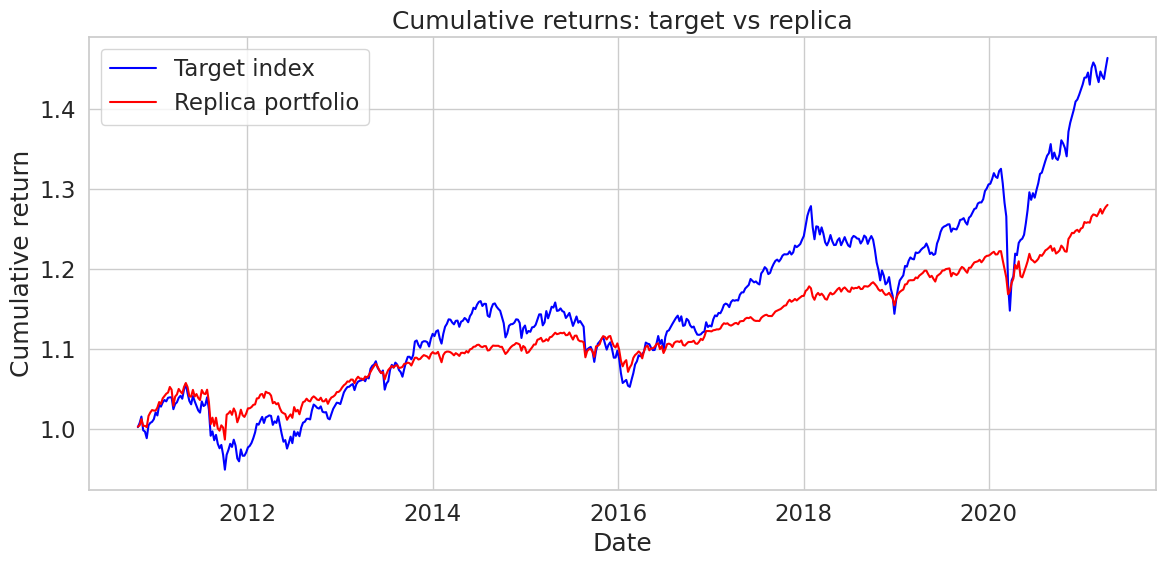

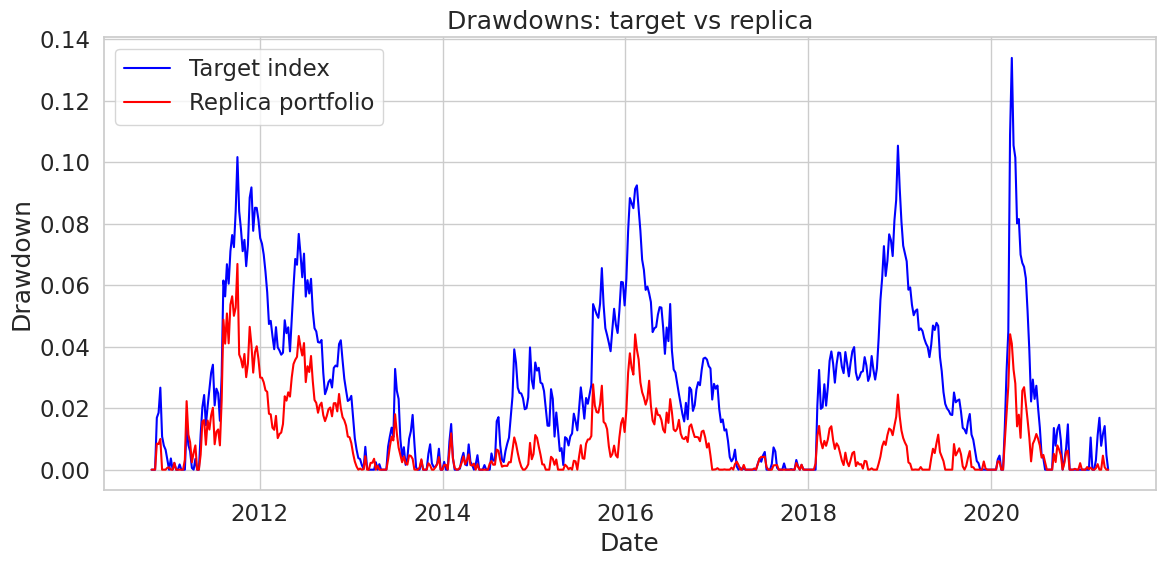

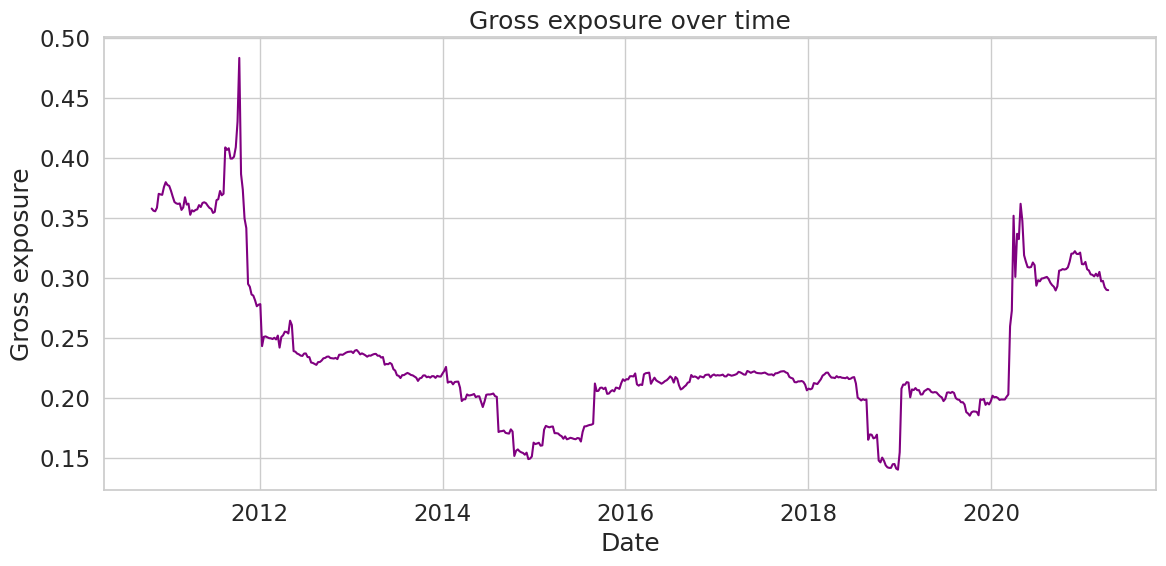

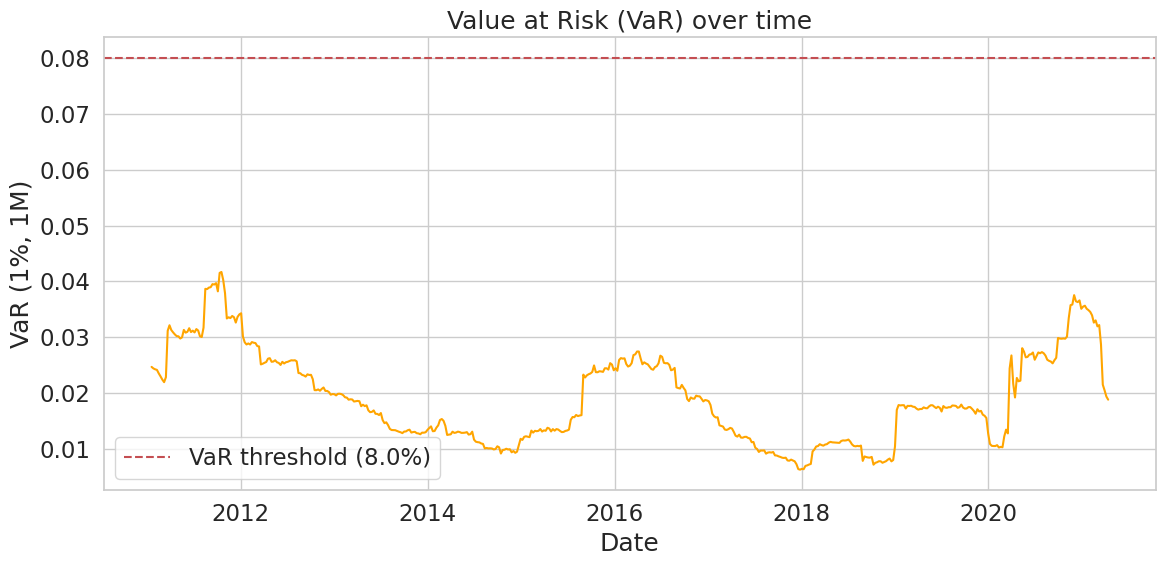

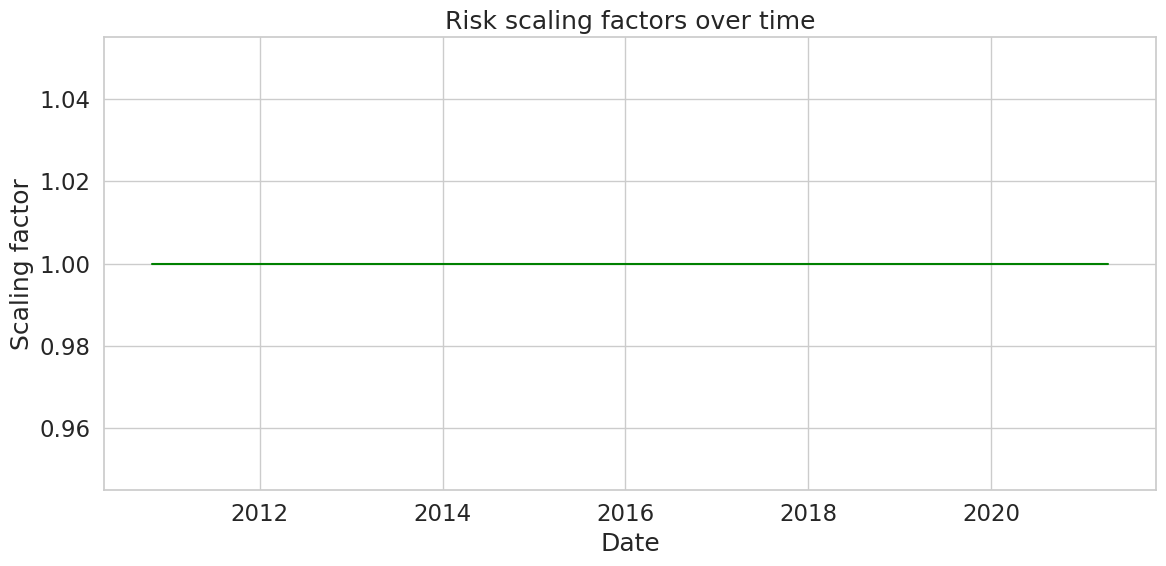

In [ ]:
# Create detailed metrics table for the best configuration
metrics_normalized = pd.DataFrame({
    'Metric': ['Annualized return', 'Annualized volatility', 'Sharpe ratio',
               'Max Drawdown', 'Tracking Error', 'Information ratio',
               'Correlation', 'Average gross exposure', 'Average VaR (1%, 1M)'],
    'Target': [f"{best_config_normalized['target_return']*100:.2f}%",
               f"{best_config_normalized['target_vol']*100:.2f}%",
               f"{best_config_normalized['target_sharpe']:.2f}",
               f"{best_config_normalized['max_drawdown']*100:.2f}%",
               "N/A",
               "N/A",
               "N/A",
               "N/A",
               "N/A"],
    'Replica': [f"{best_config_normalized['replica_return']*100:.2f}%",
                f"{best_config_normalized['replica_vol']*100:.2f}%",
                f"{best_config_normalized['replica_sharpe']:.2f}",
                f"{best_config_normalized['max_drawdown']*100:.2f}%",
                f"{best_config_normalized['tracking_error']*100:.2f}%",
                f"{best_config_normalized['information_ratio']:.2f}",
                f"{best_config_normalized['correlation']:.4f}",
                f"{best_config_normalized['avg_gross_exposure']:.4f}",
                f"{best_config_normalized['avg_var']*100:.2f}%"]
})

print("\nDetailed metrics for the best configuration (normalized returns):")
display(metrics_normalized)

# Plot cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(best_config_normalized['cumulative_target'], label='Target index', color='blue')
plt.plot(best_config_normalized['cumulative_replica'], label='Replica portfolio', color='red')
plt.title('Cumulative returns: target vs replica')
plt.xlabel('Date')
plt.ylabel('Cumulative return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot drawdowns
plt.figure(figsize=(12, 6))
target_drawdown = 1 - best_config_normalized['cumulative_target'] / best_config_normalized['cumulative_target'].cummax()
replica_drawdown = 1 - best_config_normalized['cumulative_replica'] / best_config_normalized['cumulative_replica'].cummax()
plt.plot(target_drawdown, label='Target index', color='blue')
plt.plot(replica_drawdown, label='Replica portfolio', color='red')
plt.title('Drawdowns: target vs replica')
plt.xlabel('Date')
plt.ylabel('Drawdown')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot gross exposure over time
plt.figure(figsize=(12, 6))
gross_exposure_series = pd.Series(best_config_normalized['gross_exposures'], index=best_config_normalized['replica_returns'].index)
plt.plot(gross_exposure_series, color='purple')
plt.title('Gross exposure over time')
plt.xlabel('Date')
plt.ylabel('Gross exposure')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot VaR over time
plt.figure(figsize=(12, 6))
var_series = pd.Series(best_config_normalized['var_values'], index=best_config_normalized['replica_returns'].index)
plt.plot(var_series, color='orange')
plt.axhline(y=max_var_threshold, color='r', linestyle='--', label=f'VaR threshold ({max_var_threshold*100}%)')
plt.title('Value at Risk (VaR) over time')
plt.xlabel('Date')
plt.ylabel('VaR (1%, 1M)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot scaling factors over time
plt.figure(figsize=(12, 6))
scaling_series = pd.Series(best_config_normalized['scaling_factors'], index=best_config_normalized['replica_returns'].index)
plt.plot(scaling_series, color='green')
plt.title('Risk scaling factors over time')
plt.xlabel('Date')
plt.ylabel('Scaling factor')
plt.grid(True)
plt.tight_layout()
plt.show()


### Key Performance metrics
**Volatility**  
The standard deviation of a portfolio's returns, annualized.  
It represents the total variability of the investment.

---

**Tracking Error Volatility**  
The standard deviation of the difference between the returns of a portfolio and its benchmark.  
It measures how closely the portfolio follows the benchmark.  

$
TE = \sqrt{ \text{Variance}(r_{\text{portfolio}} - r_{\text{benchmark}}) }
$

---

**Sharpe Ratio**  
A measure of risk-adjusted return. It compares the excess return of a portfolio to its volatility.  
$
\text{Sharpe Ratio} = \frac{E[r_{\text{portfolio}} - r_f]}{\sigma_{\text{portfolio}}}
$
In practice, we often use 0% as the risk-free rate $r_f$ for short horizons.

---

**Max Drawdown**  
The maximum observed loss from a peak to a trough before a new peak is reached.  
It measures the worst-case decline in portfolio value over a given period.

---

**Gross Exposure**  
The sum of the absolute values of all portfolio weights.  
It indicates the total level of capital deployed, including both long and short positions.  
$
\text{Gross Exposure} = \sum_j |\text{weight}_j|
$

A gross exposure greater than 100% implies leverage. In EU maximum leverage can be 200%, or an amount such that the VaR(1%, 1 month)<20%.



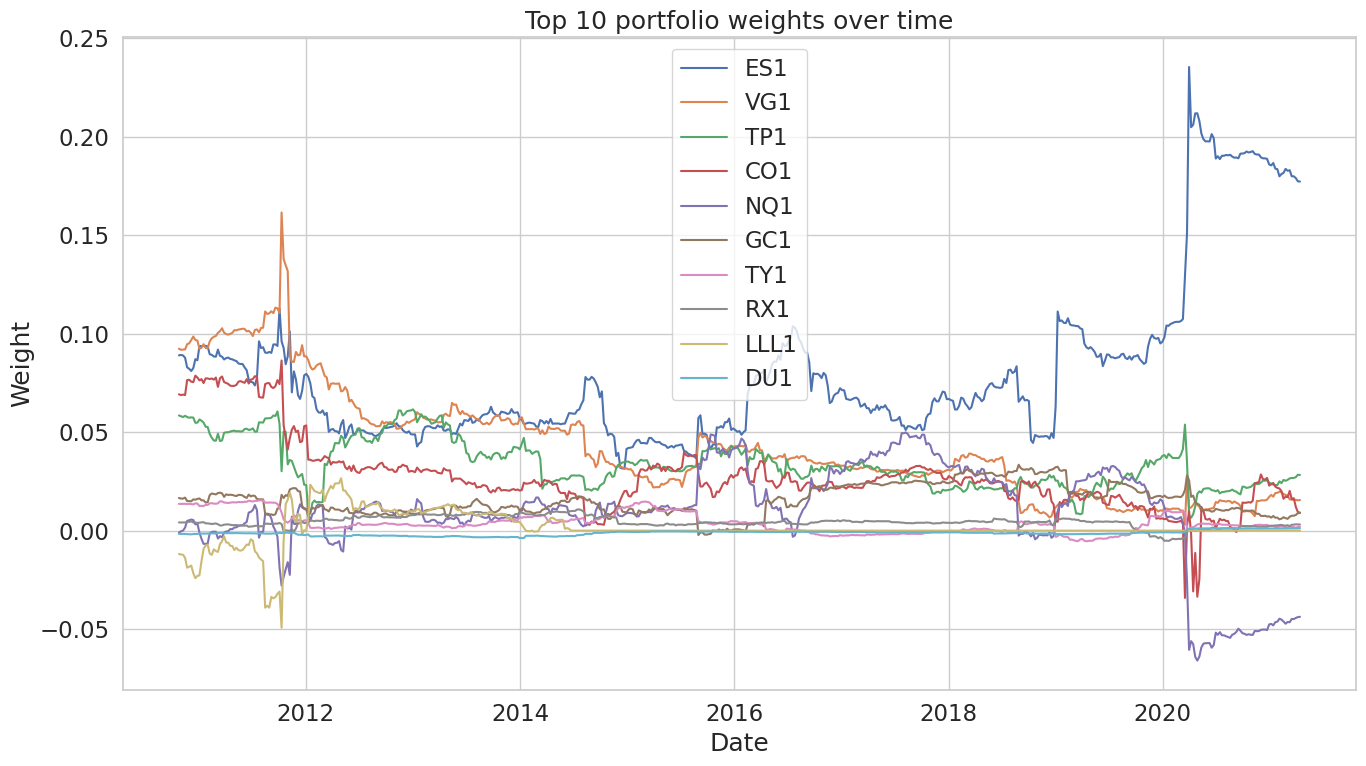

In [ ]:
# Plot weights over time
weights_history = best_config_normalized['weights_history']
weights_df = pd.DataFrame(weights_history, index=best_config_normalized['replica_returns'].index)

# Get the column names from the original futures data
weights_df.columns = X.columns

# Plot the top 10 weights by absolute average value
top_weights = weights_df.abs().mean().sort_values(ascending=False).head(10).index
plt.figure(figsize=(14, 8))
for col in top_weights:
    plt.plot(weights_df[col], label=col)
plt.title('Top 10 portfolio weights over time')
plt.xlabel('Date')
plt.ylabel('Weight')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


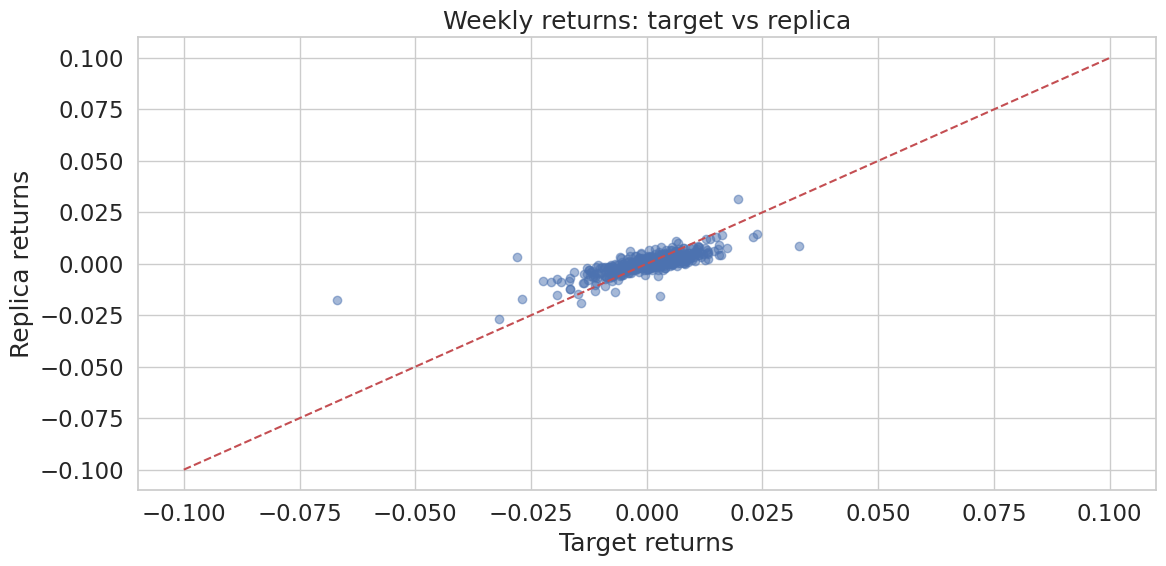

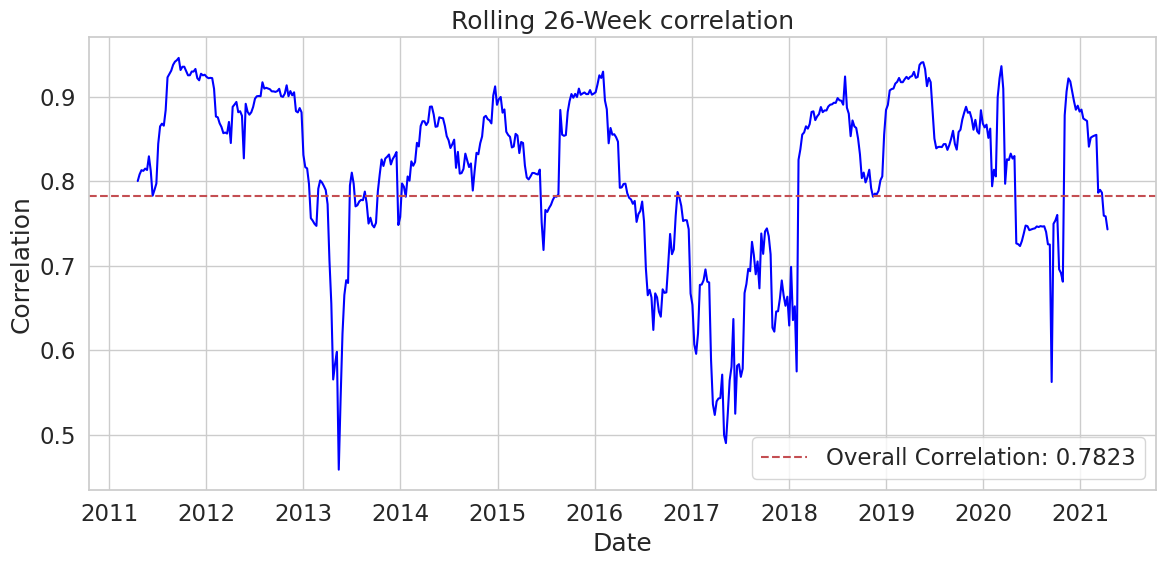

In [ ]:
# Plot weekly returns
plt.figure(figsize=(12, 6))
plt.scatter(best_config_normalized['aligned_target'], best_config_normalized['replica_returns'], alpha=0.5)
plt.plot([-0.1, 0.1], [-0.1, 0.1], 'r--')  # Diagonal line
plt.title('Weekly returns: target vs replica')
plt.xlabel('Target returns')
plt.ylabel('Replica returns')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot rolling correlation
plt.figure(figsize=(12, 6))
rolling_corr = best_config_normalized['replica_returns'].rolling(window=26).corr(best_config_normalized['aligned_target'])
plt.plot(rolling_corr, color='blue')
plt.title('Rolling 26-Week correlation')
plt.xlabel('Date')
plt.ylabel('Correlation')
plt.axhline(y=best_config_normalized['correlation'], color='r', linestyle='--',
            label=f'Overall Correlation: {best_config_normalized["correlation"]:.4f}')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



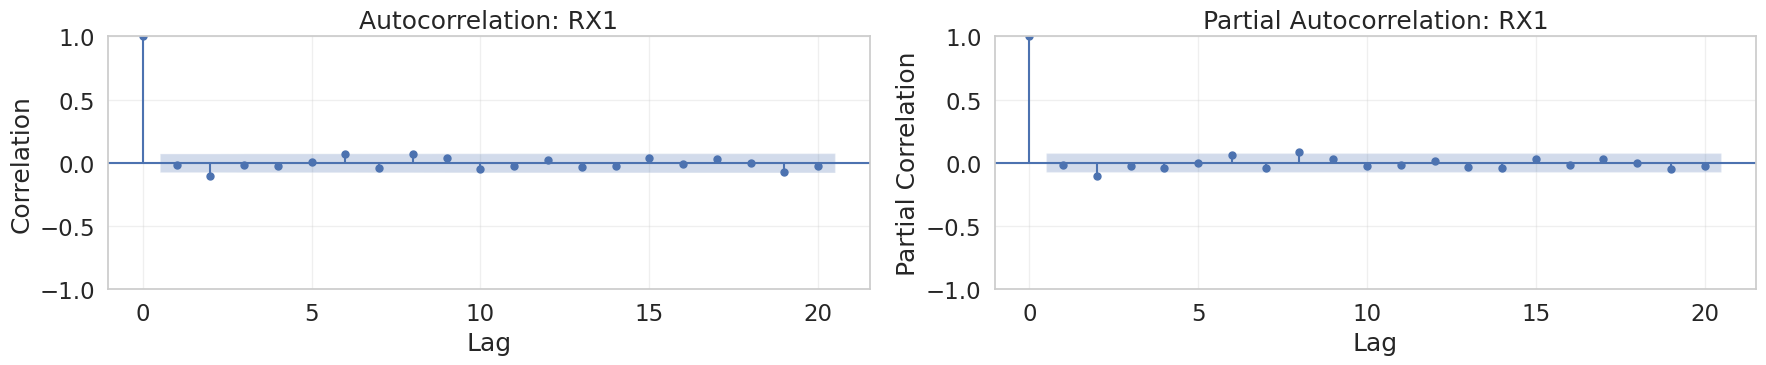

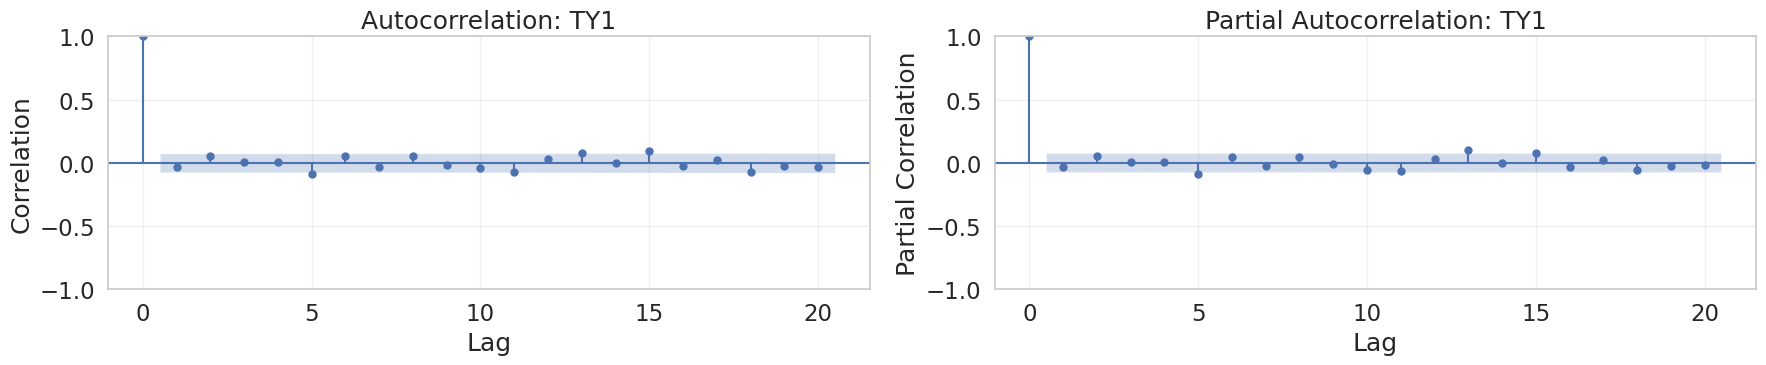

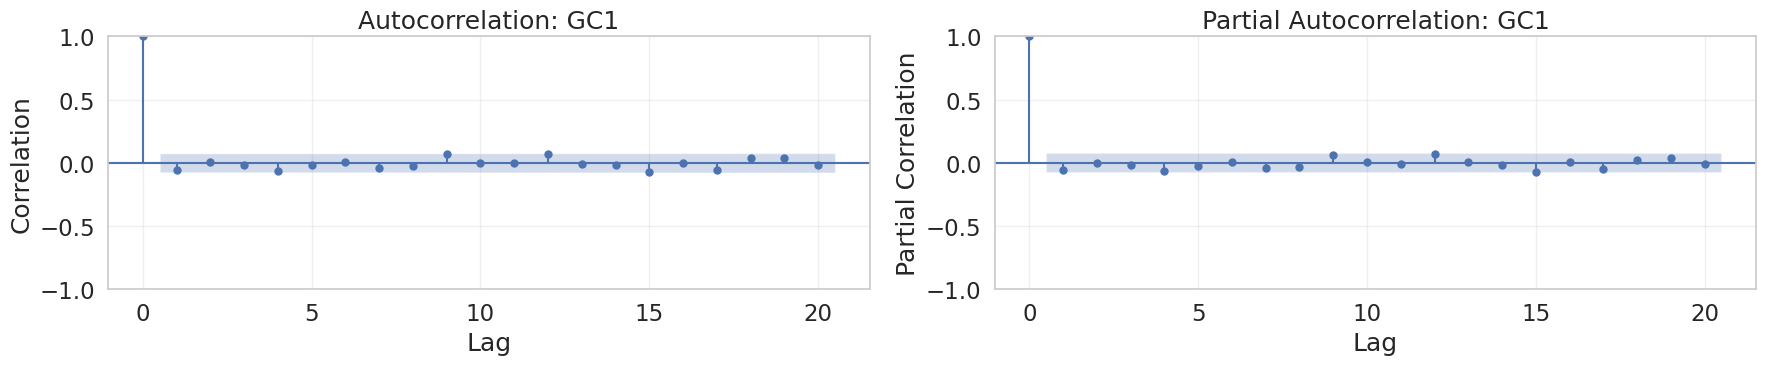

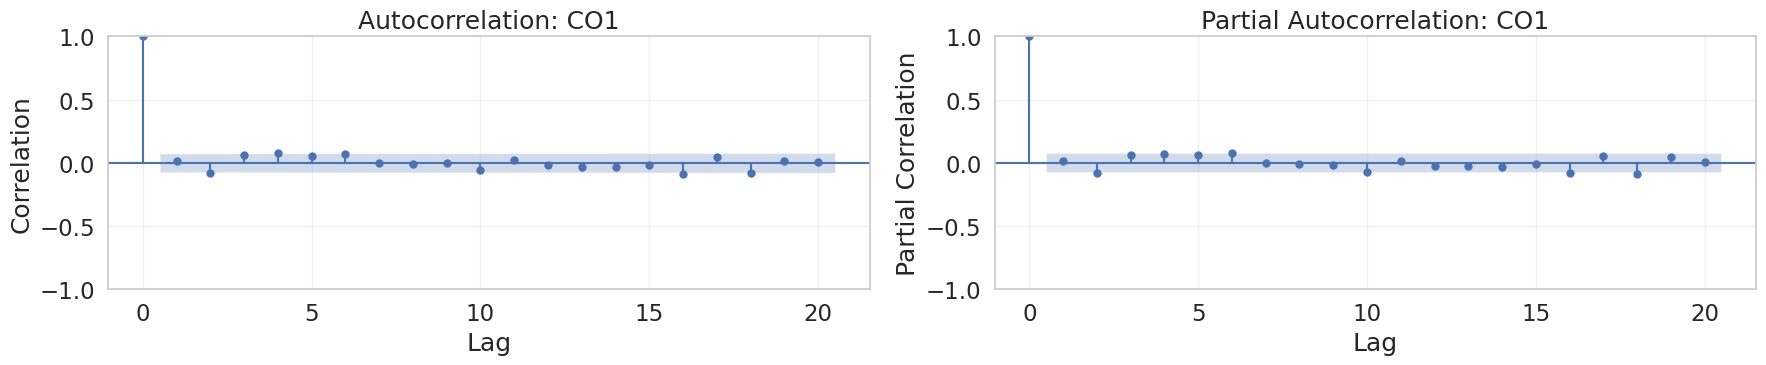

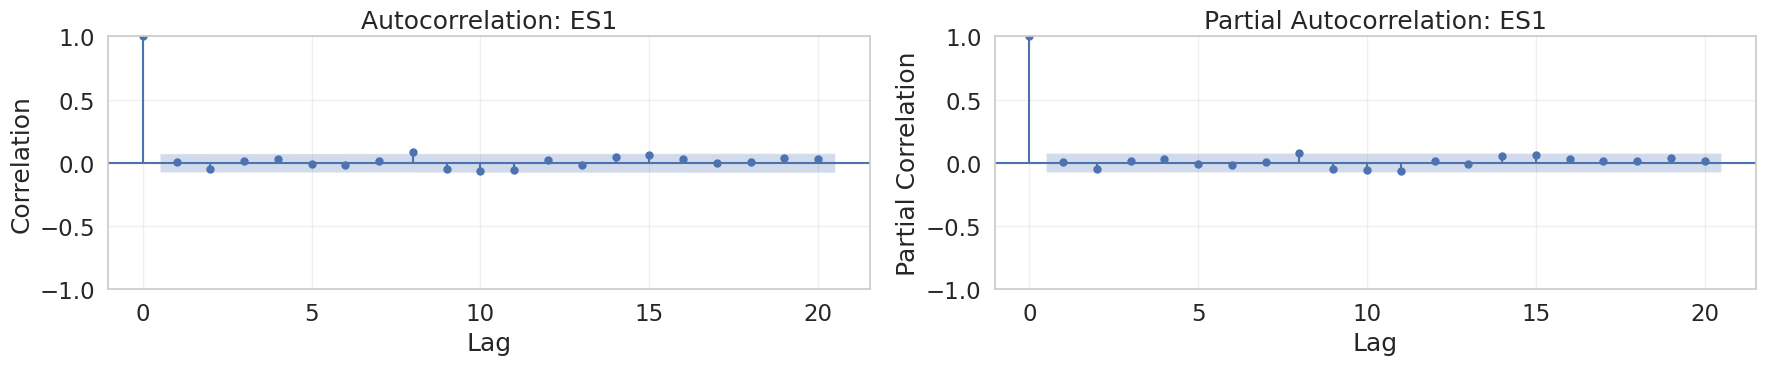

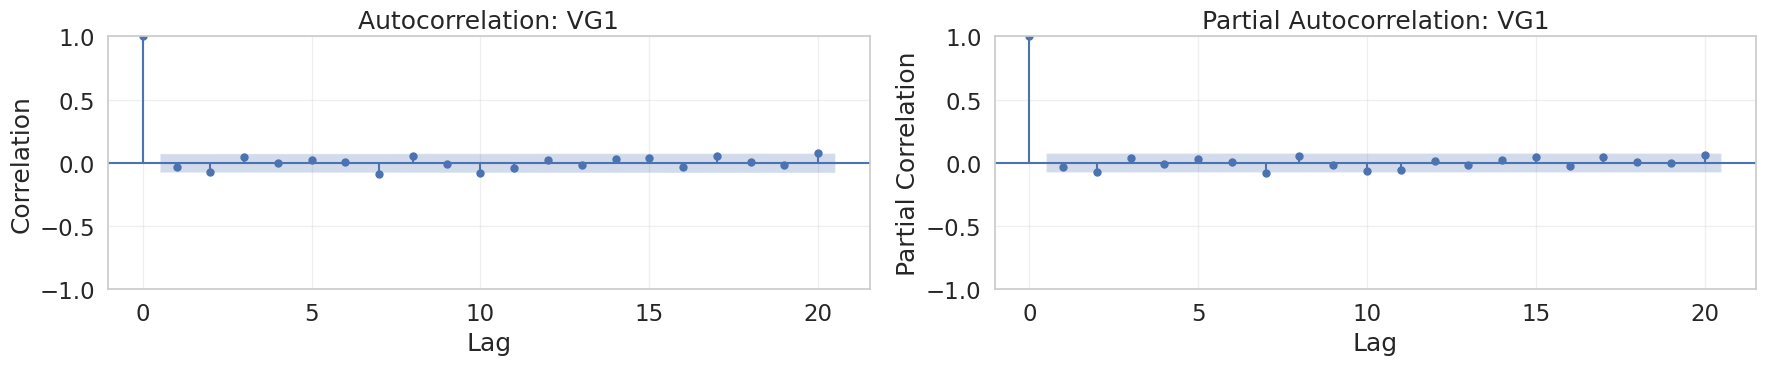

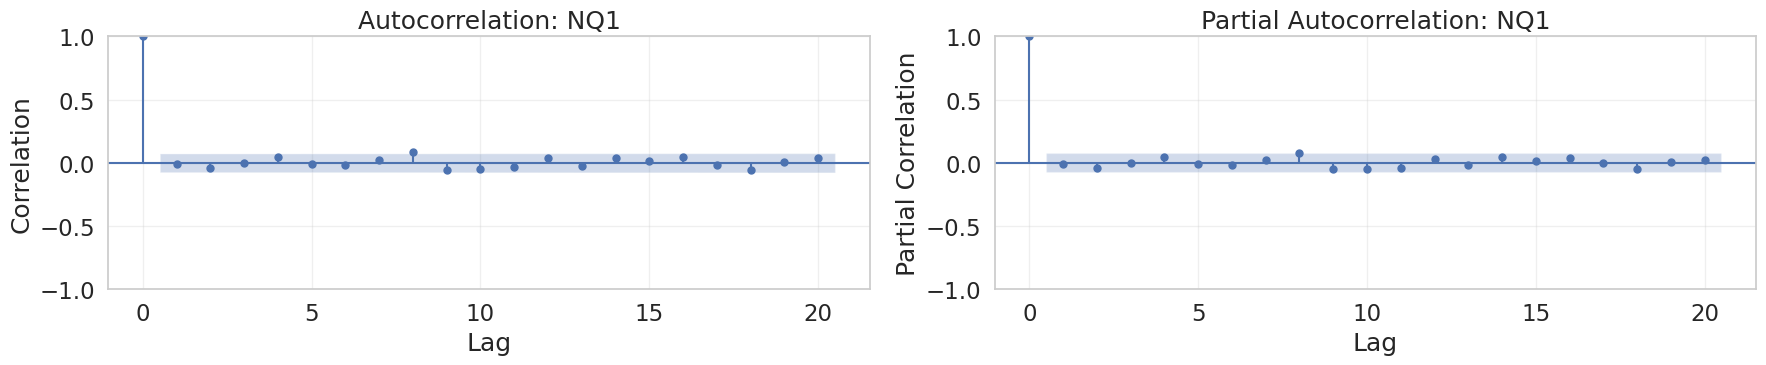

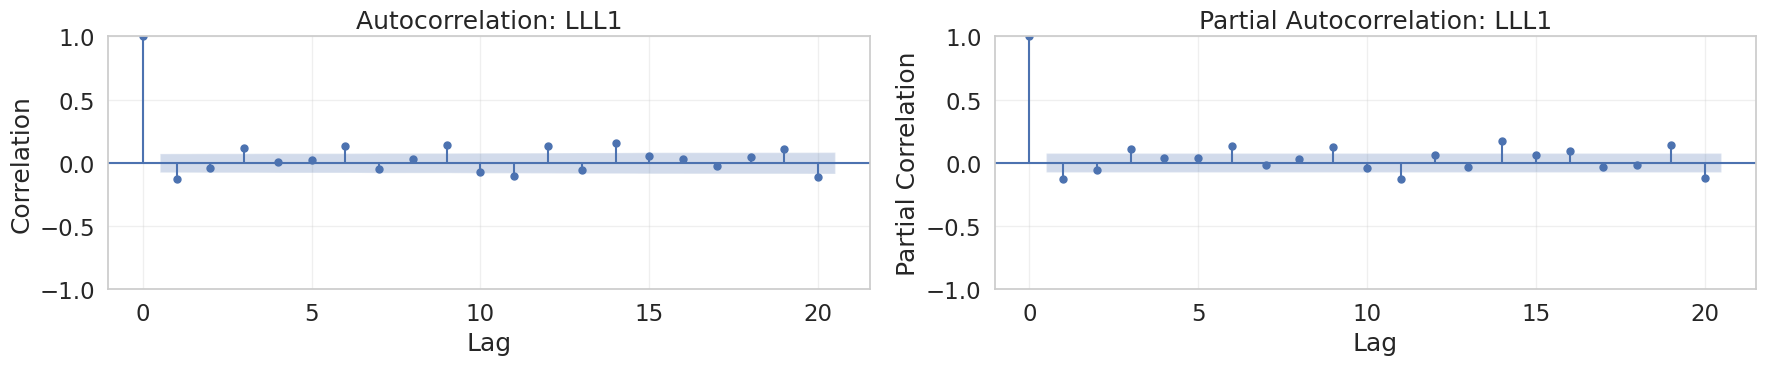

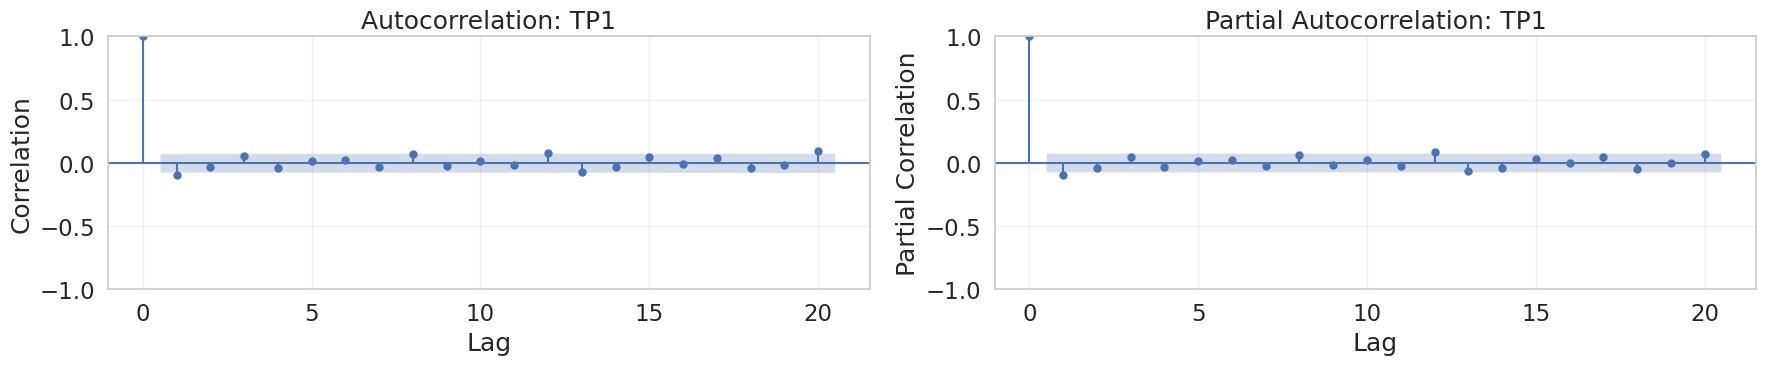

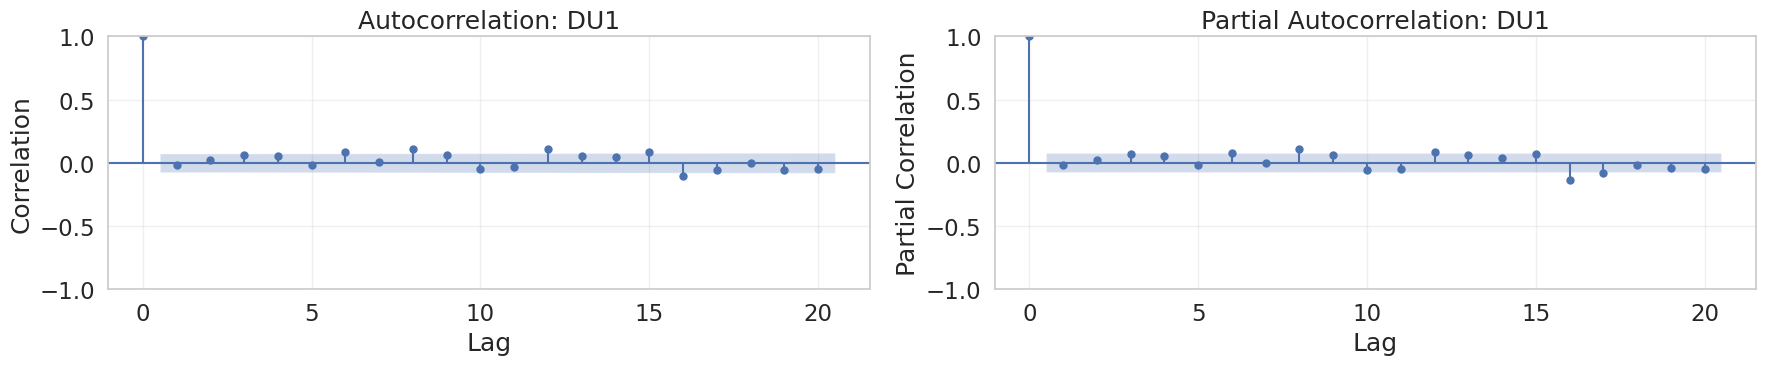

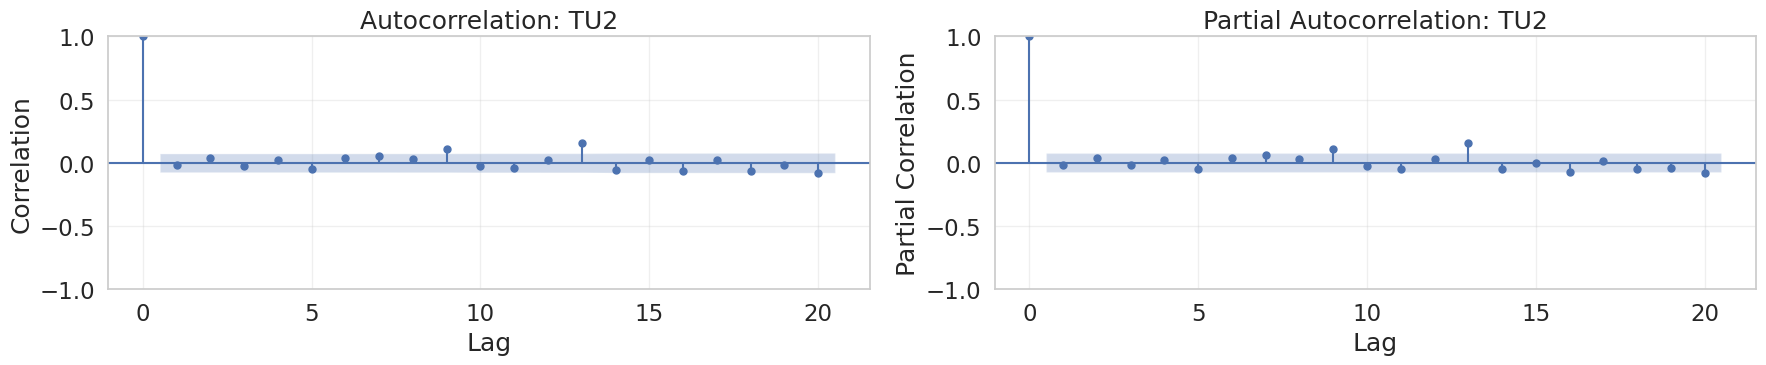

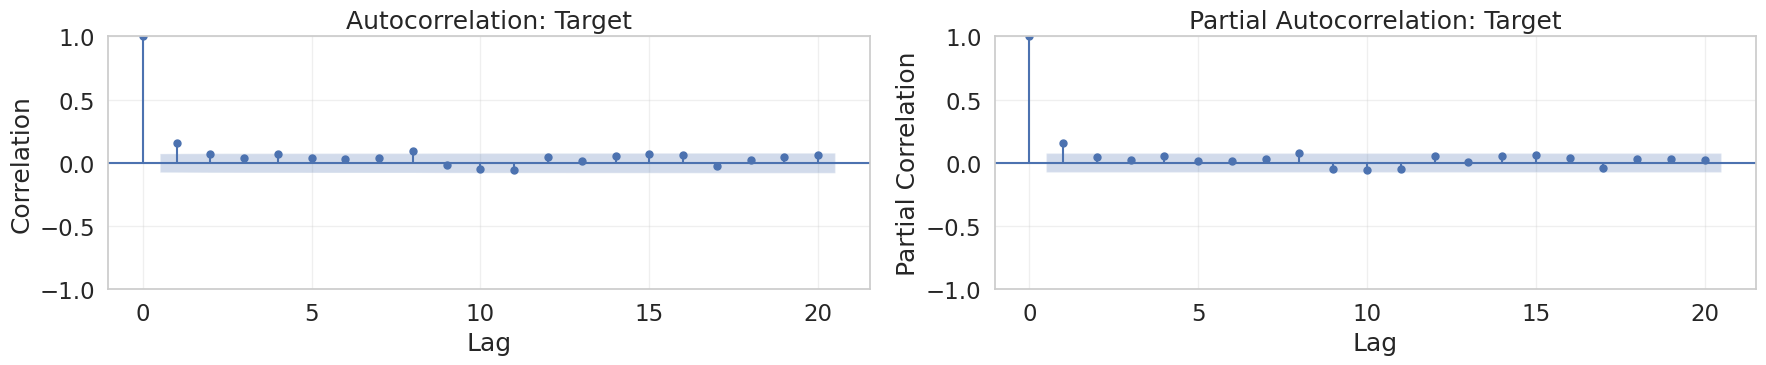

In [ ]:
# Autocorrelation and Partial Autocorrelation analysis
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Define the maximum number of lags to analyze
max_lags = 20

# For each target index
for i, idx in enumerate(futures_contracts):
    fig, axes = plt.subplots(1, 2, figsize=(18, 4))
    # Get returns data for this index
    returns_data = futures_returns[idx].dropna()

    # Plot ACF (Autocorrelation Function)
    plot_acf(returns_data,
             lags=max_lags,
             ax=axes[0],
             title=f'Autocorrelation: {idx}',
             alpha=0.05)  # 95% confidence intervals

    axes[0].set_xlabel('Lag')
    axes[0].set_ylabel('Correlation')
    axes[0].grid(True, alpha=0.3)

    # Plot PACF (Partial Autocorrelation Function)
    plot_pacf(returns_data,
              lags=max_lags,
              ax=axes[1],
              title=f'Partial Autocorrelation: {idx}',
              alpha=0.05)  # 95% confidence intervals

    axes[1].set_xlabel('Lag')
    axes[1].set_ylabel('Partial Correlation')
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# TARGET
idx = 'Target'
fig, axes = plt.subplots(1, 2, figsize=(18, 4))
returns_data = target_returns.dropna()
plot_acf(returns_data,
         lags=max_lags,
         ax=axes[0],
         title=f'Autocorrelation: {idx}',
         alpha=0.05)  # 95% confidence intervals

axes[0].set_xlabel('Lag')
axes[0].set_ylabel('Correlation')
axes[0].grid(True, alpha=0.3)

# Plot PACF (Partial Autocorrelation Function)
plot_pacf(returns_data,
          lags=max_lags,
          ax=axes[1],
          title=f'Partial Autocorrelation: {idx}',
          alpha=0.05)  # 95% confidence intervals

axes[1].set_xlabel('Lag')
axes[1].set_ylabel('Partial Correlation')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [ ]:
# Ljung-Box test for autocorrelation
from statsmodels.stats.diagnostic import acorr_ljungbox

print("\nLjung-Box test for Autocorrelation (H0: No autocorrelation)")
for idx in futures_contracts:
    # Get returns data for this index
    returns_data = futures_returns[idx].dropna()

    # Perform Ljung-Box test for different lags
    lb_test = acorr_ljungbox(returns_data, lags=[5, 10, 15, 20])

    print(f"\n{idx}:")
    print(f"  Lag 5:  Test Statistic = {lb_test.iloc[0, 0]:.4f}, p-value = {lb_test.iloc[0, 1]}")
    print(f"  Lag 10: Test Statistic = {lb_test.iloc[1, 0]:.4f}, p-value = {lb_test.iloc[1, 1]}")
    print(f"  Lag 15: Test Statistic = {lb_test.iloc[2, 0]:.4f}, p-value = {lb_test.iloc[2, 1]}")
    print(f"  Lag 20: Test Statistic = {lb_test.iloc[3, 0]:.4f}, p-value = {lb_test.iloc[3, 1]}")


# Target

returns_data = target_returns.dropna()

# Perform Ljung-Box test for different lags
lb_test = acorr_ljungbox(returns_data, lags=[5, 10, 15, 20])

print(f"\nTarget:")
print(f"  Lag 5:  Test Statistic = {lb_test.iloc[0, 0]:.4f}, p-value = {lb_test.iloc[0, 1]}")
print(f"  Lag 10: Test Statistic = {lb_test.iloc[1, 0]:.4f}, p-value = {lb_test.iloc[1, 1]}")
print(f"  Lag 15: Test Statistic = {lb_test.iloc[2, 0]:.4f}, p-value = {lb_test.iloc[2, 1]}")
print(f"  Lag 20: Test Statistic = {lb_test.iloc[3, 0]:.4f}, p-value = {lb_test.iloc[3, 1]}")



Ljung-Box test for Autocorrelation (H0: No autocorrelation)

RX1:
  Lag 5:  Test Statistic = 8.4790, p-value = 0.13173864139250974
  Lag 10: Test Statistic = 19.3768, p-value = 0.03572945190829239
  Lag 15: Test Statistic = 22.2137, p-value = 0.10232237437751587
  Lag 20: Test Statistic = 26.7617, p-value = 0.1421016134409255

TY1:
  Lag 5:  Test Statistic = 8.6219, p-value = 0.12512876027085962
  Lag 10: Test Statistic = 14.6918, p-value = 0.1437081823925306
  Lag 15: Test Statistic = 29.7336, p-value = 0.012919036265547374
  Lag 20: Test Statistic = 35.0339, p-value = 0.019924364705104298

GC1:
  Lag 5:  Test Statistic = 5.7459, p-value = 0.33173416513685955
  Lag 10: Test Statistic = 10.5310, p-value = 0.3952057159348535
  Lag 15: Test Statistic = 17.9652, p-value = 0.2645018840634834
  Lag 20: Test Statistic = 22.6011, p-value = 0.3088033177166065

CO1:
  Lag 5:  Test Statistic = 12.5339, p-value = 0.028160953778448905
  Lag 10: Test Statistic = 18.3683, p-value = 0.04905967282330

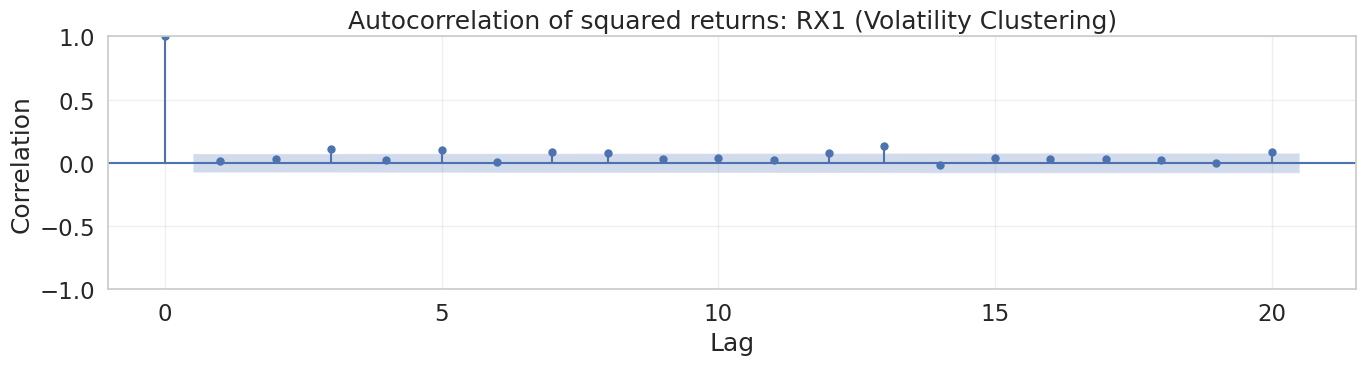

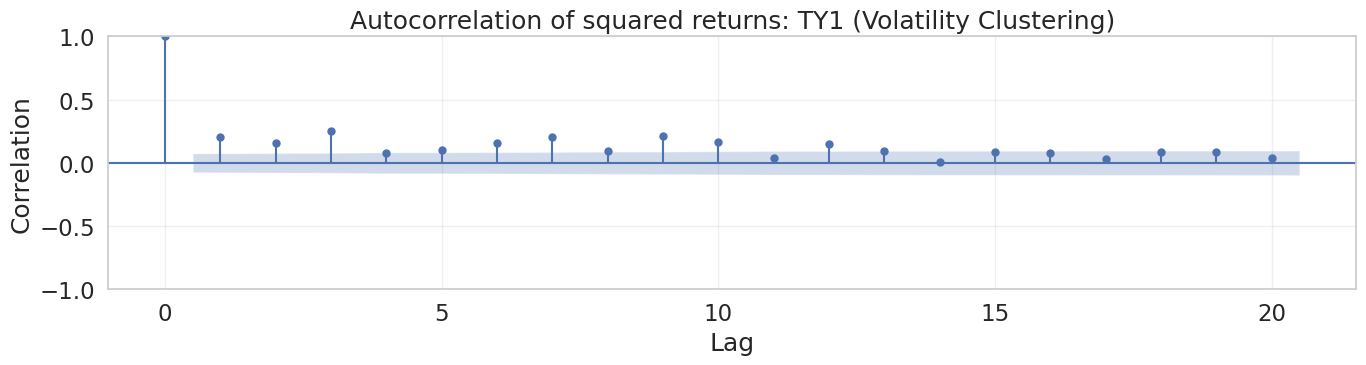

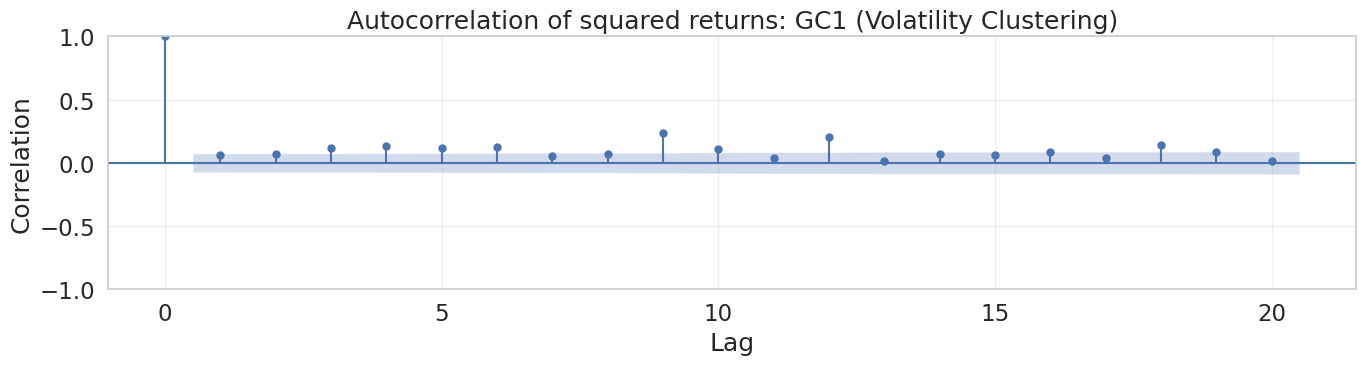

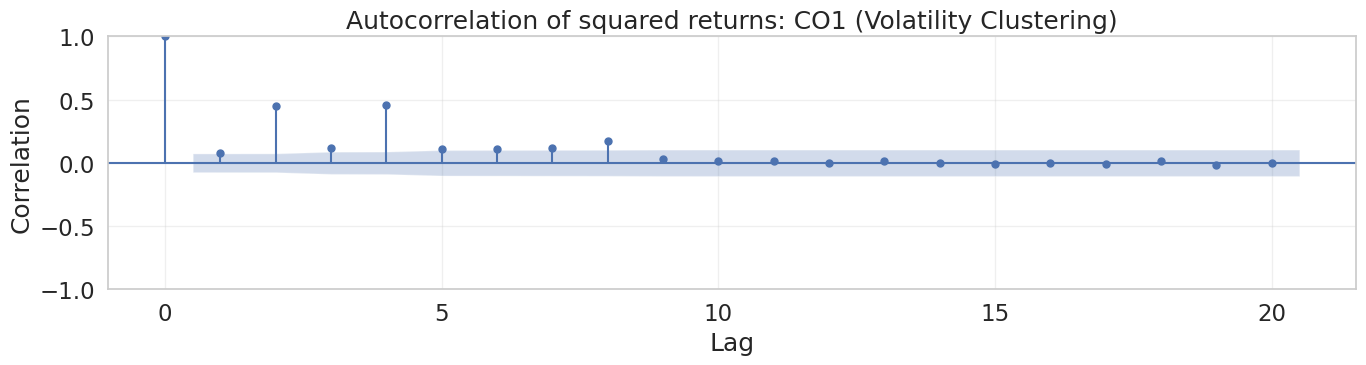

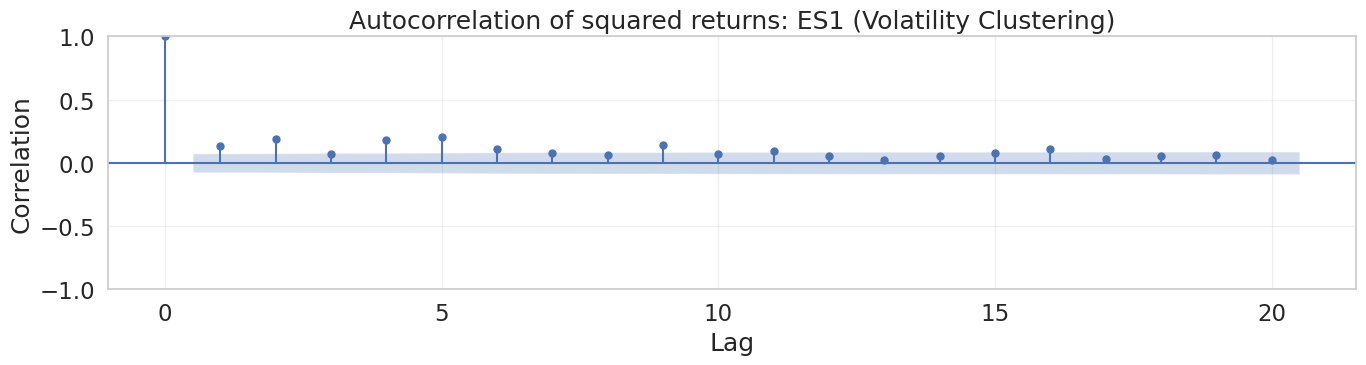

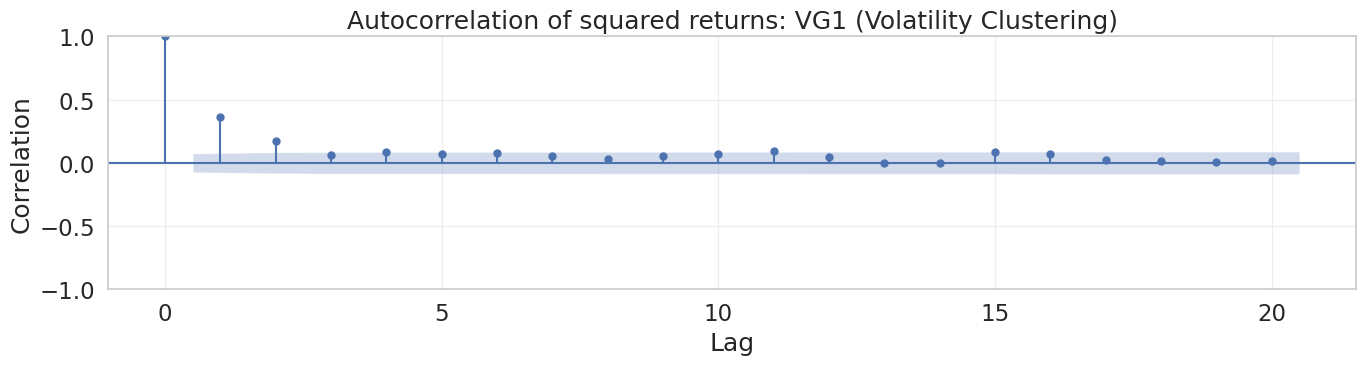

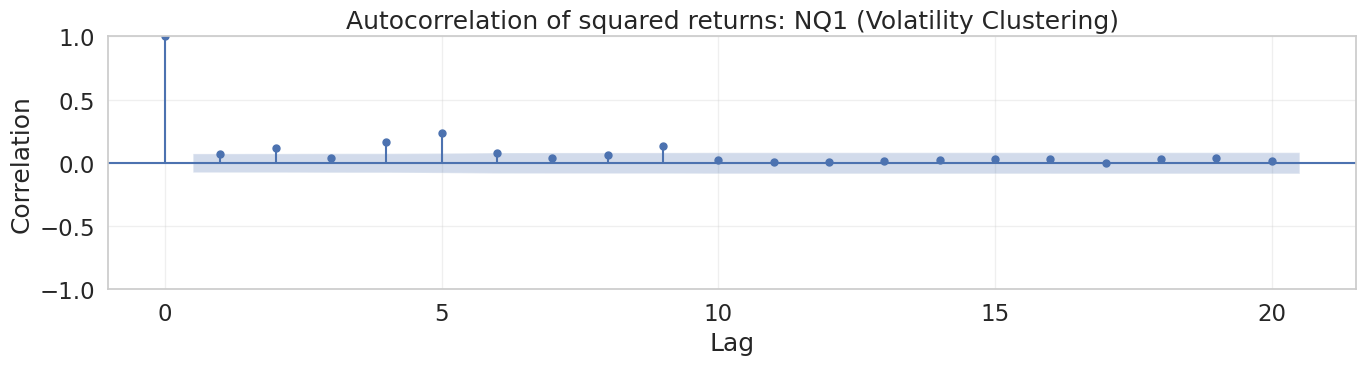

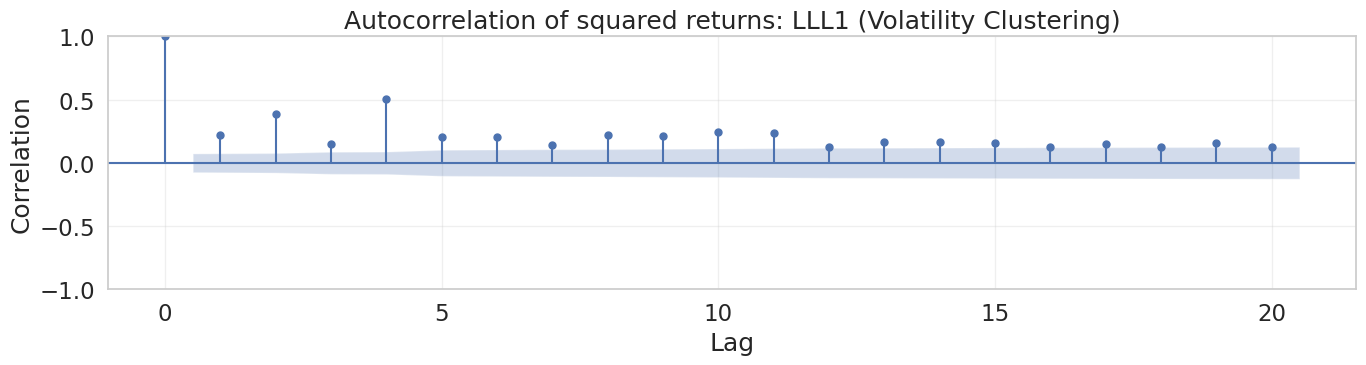

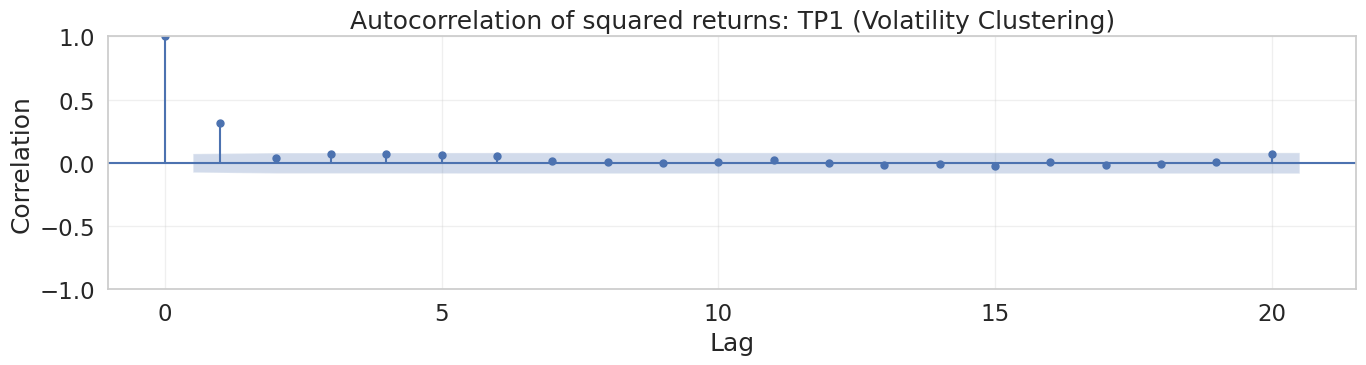

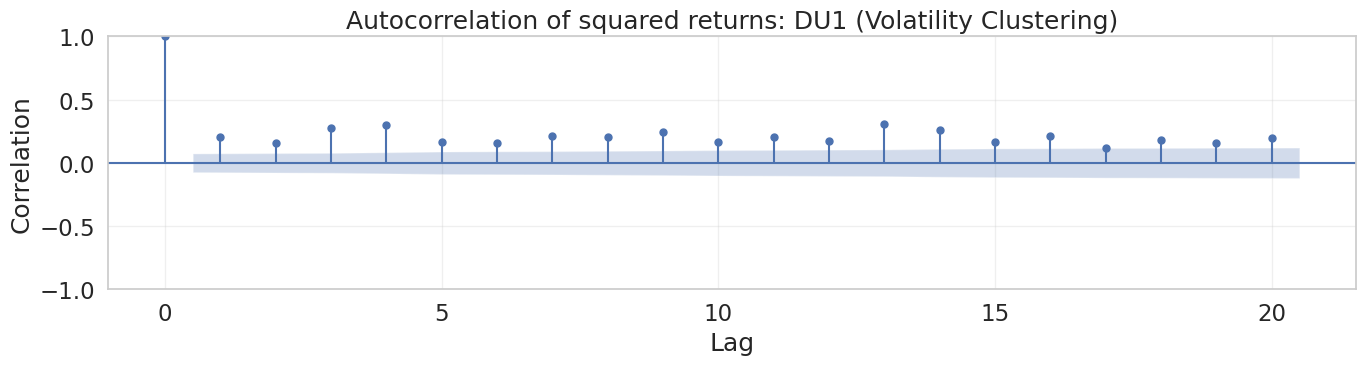

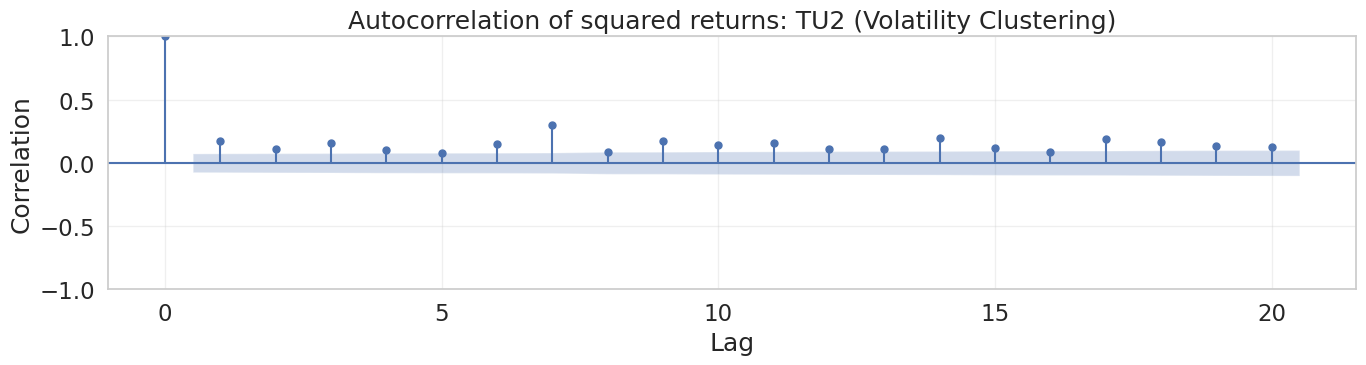

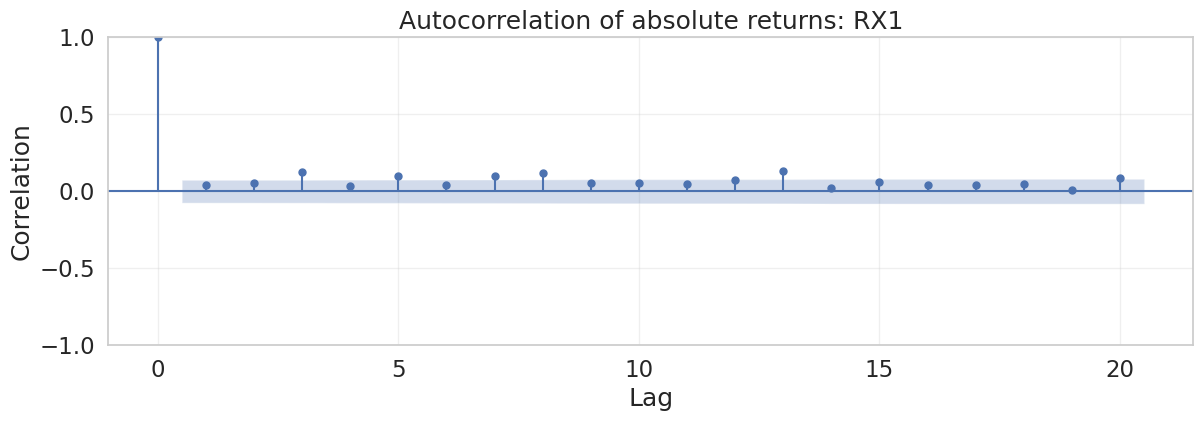

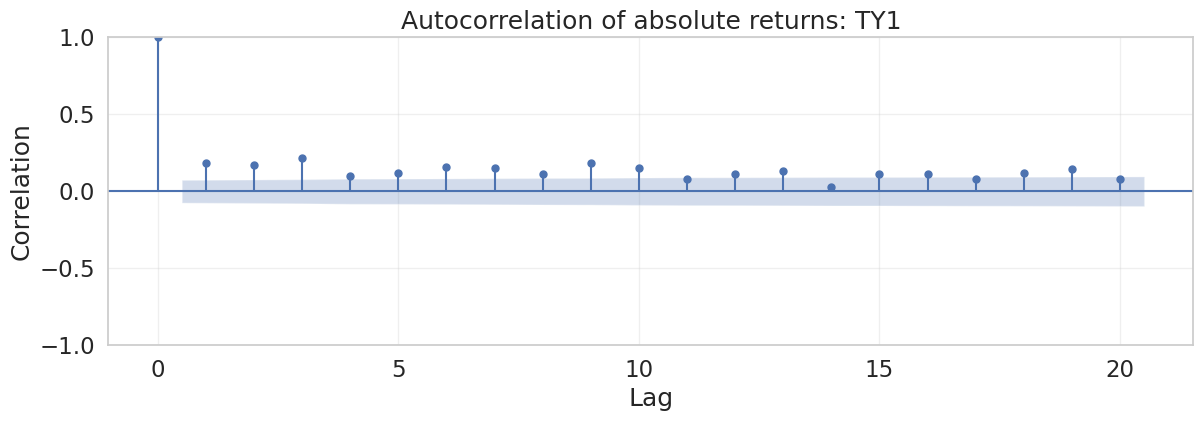

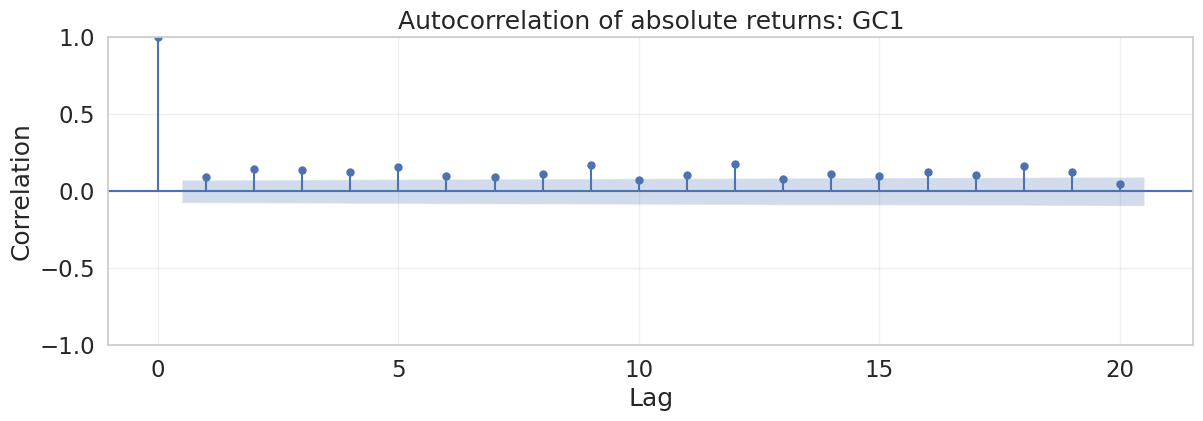

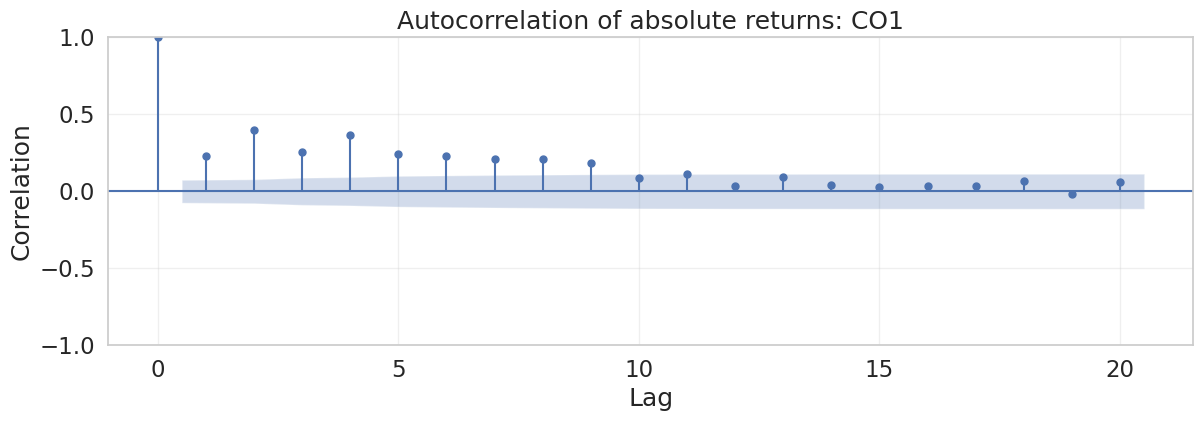

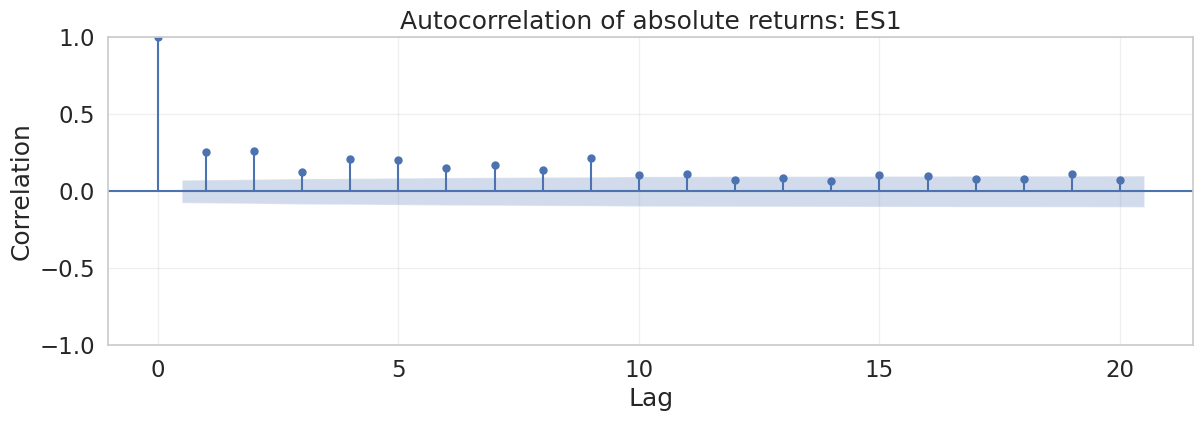

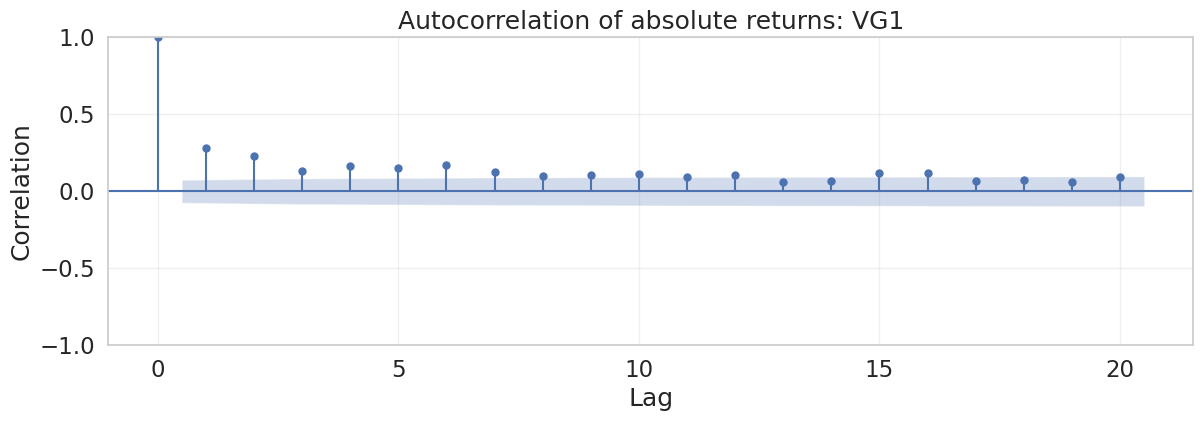

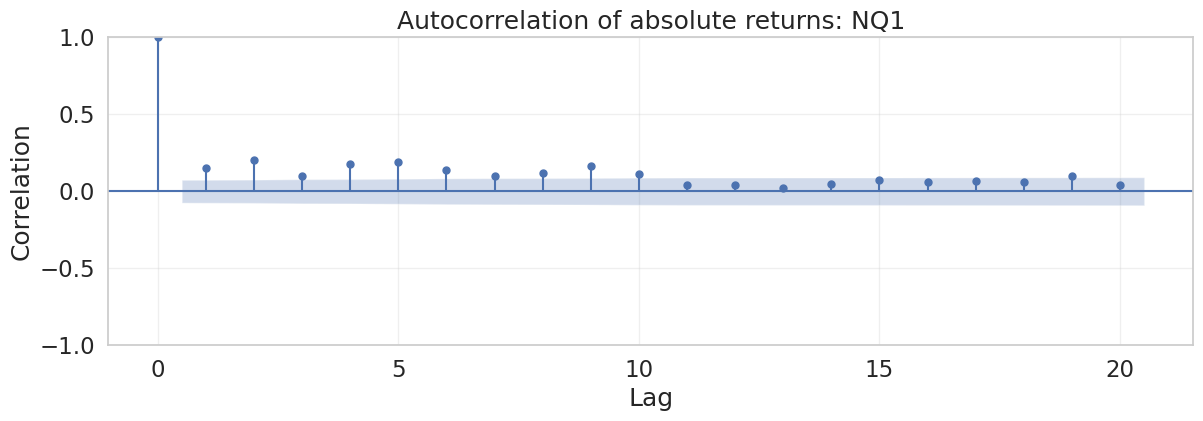

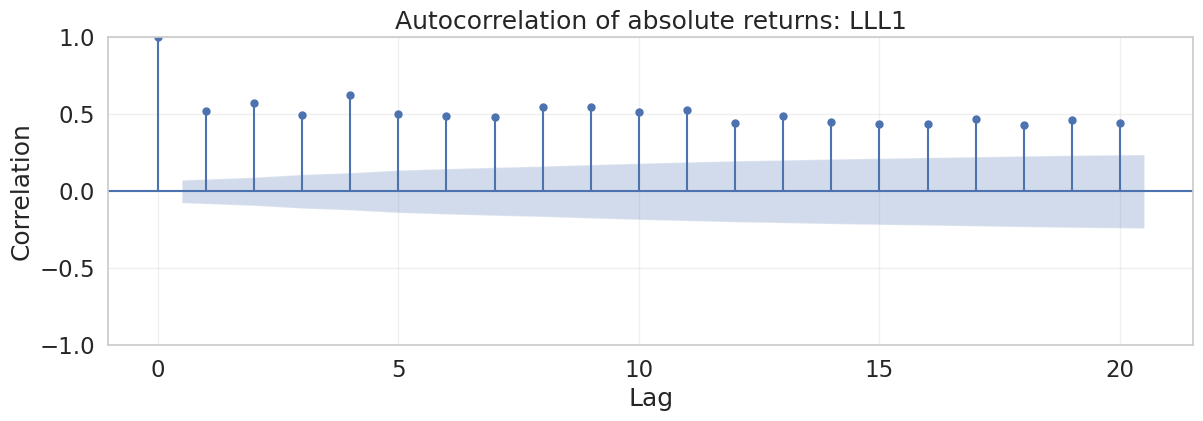

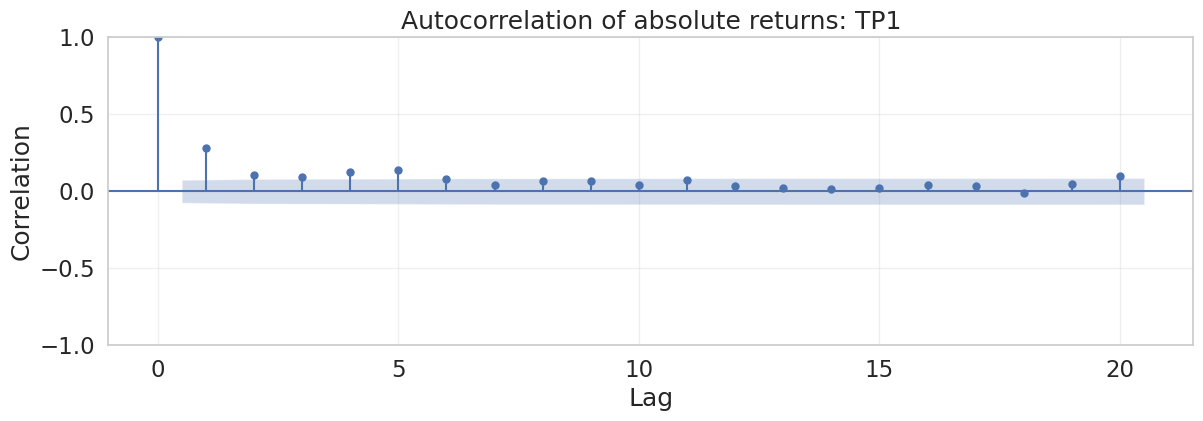

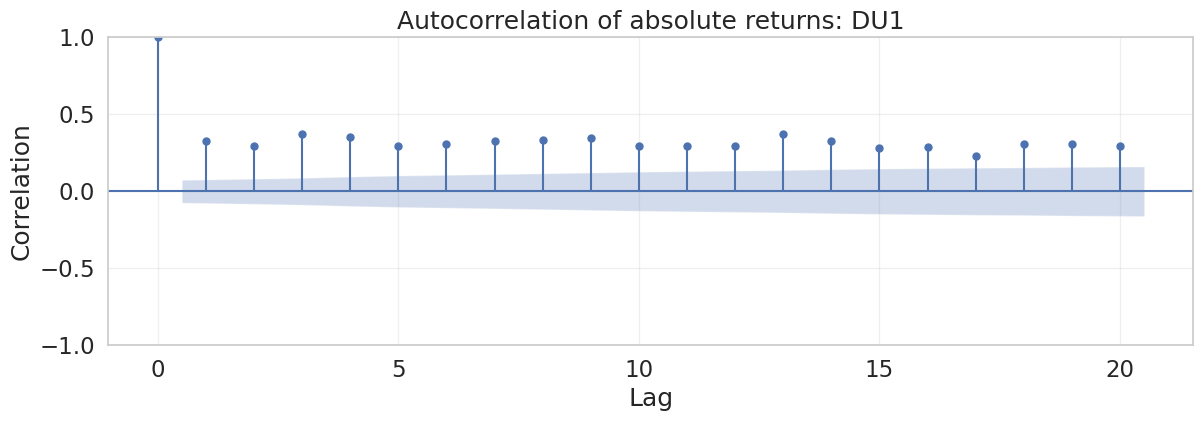

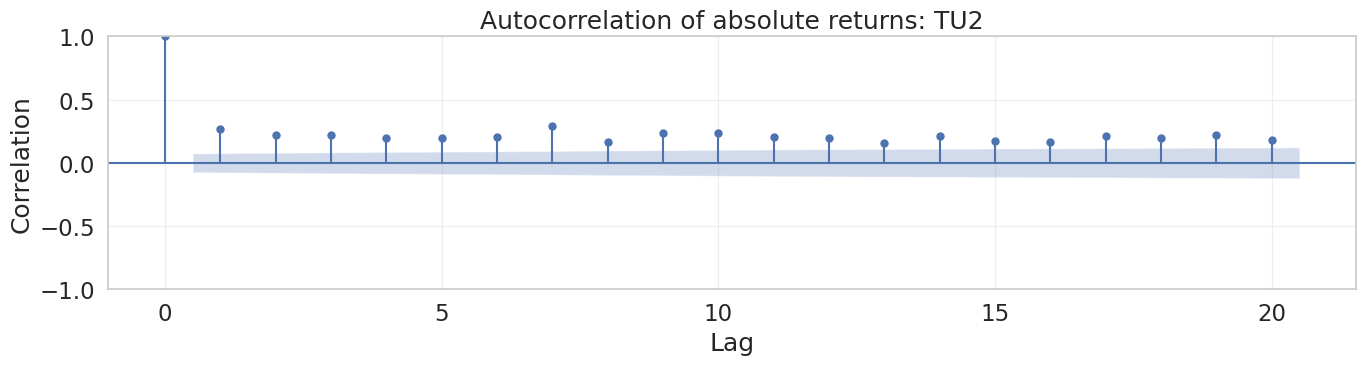

In [ ]:
# Create a figure for squared returns ACF (volatility clustering)
# For each target index
for i, idx in enumerate(futures_contracts):
    fig, axes = plt.subplots(1, 1, figsize=(14, 4))

    # Get squared returns data for this index (for volatility clustering, ie GARC-like situations)
    squared_returns = futures_returns[idx].dropna() ** 2

    # Plot ACF of squared returns
    plot_acf(squared_returns,
             lags=max_lags,
             ax=axes,
             title=f'Autocorrelation of squared returns: {idx} (Volatility Clustering)',
             alpha=0.05)  # 95% confidence intervals

    if len(target_indices) > 1:
        axes.set_xlabel('Lag')
        axes.set_ylabel('Correlation')
        axes.grid(True, alpha=0.3)
    else:
        axes.set_xlabel('Lag')
        axes.set_ylabel('Correlation')
        axes.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Create a figure for absolute returns ACF (another measure of volatility clustering)

# For each target index
for i, idx in enumerate(futures_contracts):
    fig, axes = plt.subplots(1, 1, figsize=(14, 4))

    # Get absolute returns data for this index
    abs_returns = abs(futures_returns[idx].dropna())

    # Plot ACF of absolute returns
    plot_acf(abs_returns,
             lags=max_lags,
             ax=axes,
             title=f'Autocorrelation of absolute returns: {idx}',
             alpha=0.05)  # 95% confidence intervals

    if len(target_indices) > 1:
        axes.set_xlabel('Lag')
        axes.set_ylabel('Correlation')
        axes.grid(True, alpha=0.3)
    else:
        axes.set_xlabel('Lag')
        axes.set_ylabel('Correlation')
        axes.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


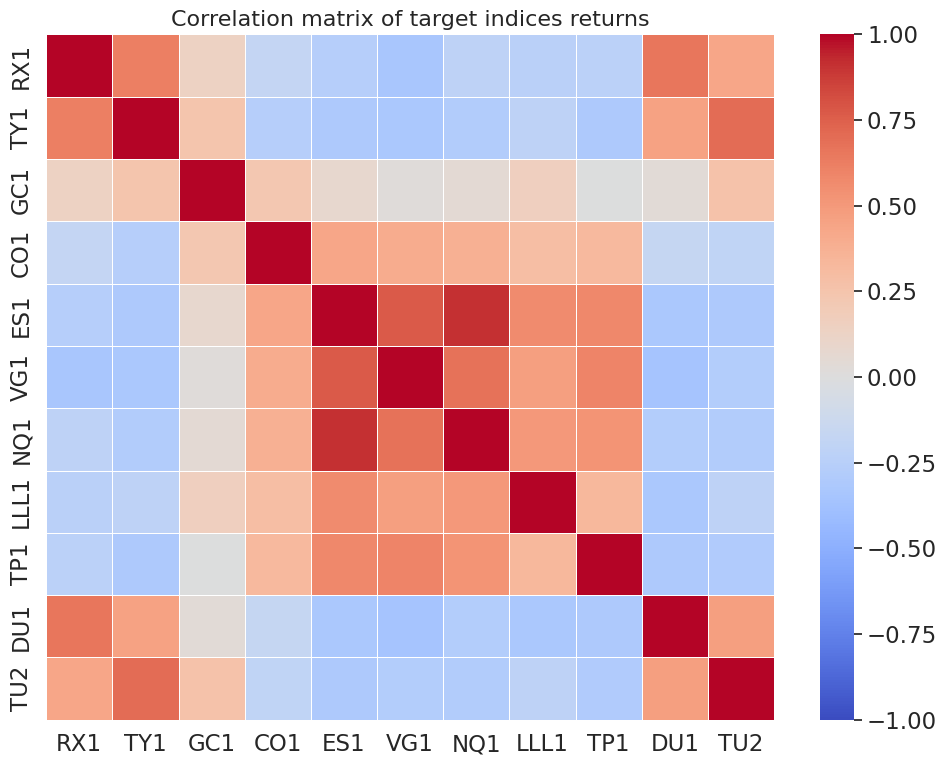

In [ ]:
# Create a correlation heatmap for the target indices
plt.figure(figsize=(10, 8))
correlation_matrix = futures_returns[futures_contracts].corr()
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', vmin=-1, vmax=1,
            linewidths=0.5, fmt='.2f')
plt.title('Correlation matrix of target indices returns', fontsize=16)
plt.tight_layout()
plt.show()


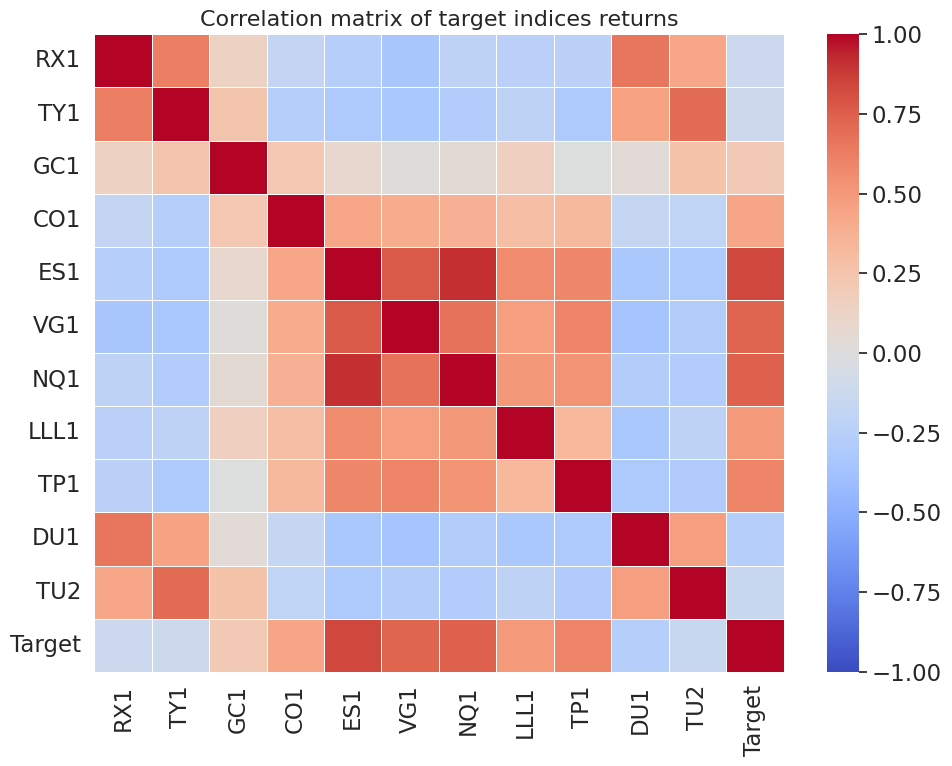

In [ ]:
new_df = futures_returns.copy()
new_df['Target'] = target_returns_aligned

plt.figure(figsize=(10, 8))
correlation_matrix = new_df.corr()
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', vmin=-1, vmax=1,
            linewidths=0.5, fmt='.2f')
plt.title('Correlation matrix of target indices returns', fontsize=16)
plt.tight_layout()
plt.show()

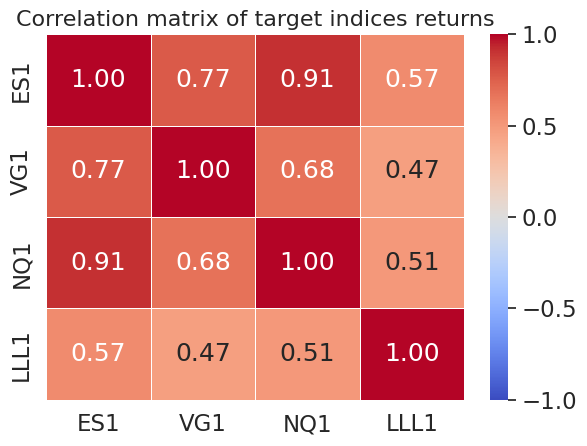

In [ ]:
selected_features = ['ES1', 'VG1', 'NQ1', 'LLL1']
selected_features_results = futures_returns[selected_features]
#selected_features_results['Target'] = target_returns_aligned
correlation_matrix = selected_features_results.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1,
            linewidths=0.5, fmt='.2f')
plt.title('Correlation matrix of target indices returns', fontsize=16)

plt.tight_layout()
plt.show()

In [ ]:
class ElasticNetCl:
    def __init__(self, target_returns_aligned, futures_returns):
        y = target_returns_aligned
        X = futures_returns.loc[y.index]
        self.X_values = X.values
        self.y_values = y.values
        self.dates_array = X.index.to_numpy()


    def calculate_var(self, returns, confidence=0.01, horizon=4):
        sigma = np.std(returns)
        z_score = stats.norm.ppf(confidence)
        var = -z_score * sigma * np.sqrt(horizon)
        return var



    # Function to run a single configuration with normalized returns and proper VaR scaling
    def run_elastic_net_normalized(self, l1_ratio, rolling_window, alpha):
        # Initialize arrays to store results
        weights_history = []  # Store weights over time
        replica_returns = []  # Store replica portfolio returns
        target_dates = []  # Store dates for plotting
        gross_exposures = []  # Store gross exposure over time
        var_values = []  # Store VaR values over time
        scaling_factors = []  # Store scaling factors applied

        # Loop through the data using a rolling window approach as explained before
        for i in range(len(X) - rolling_window - 1):
            # Define training window
            start_idx = i
            end_idx = i + rolling_window

            # Extract training data
            X_train = self.X_values[start_idx:end_idx]
            y_train = self.y_values[start_idx:end_idx]

            # Normalize the training data using MinMaxScaler
            scaler_X = MinMaxScaler()
            X_train_normalized = scaler_X.fit_transform(X_train)

            # Normalize target
            scaler_y = MinMaxScaler()
            y_train_normalized = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()

            # Fit Elastic Net model with a given alpha
            model = ElasticNet(
                alpha=alpha,
                l1_ratio=l1_ratio,
                fit_intercept=False,
                max_iter=10000,
                tol=1e-4
            )

            model.fit(X_train_normalized, y_train_normalized)

            # Get the normalized weights
            normalized_weights = model.coef_

            # Calculate weights for original scale
            original_weights = normalized_weights / scaler_X.scale_

            # Default scaling factor
            scaling_factor = 1.0

            # If we have enough historical data, calculate VaR and scale if needed
            if len(replica_returns) >= 12:  # Need some history to calculate VaR...
                # Calculate historical replica returns using current weights
                historical_returns = []
                for j in range(max(0, len(replica_returns)-52), len(replica_returns)):
                    # Get historical futures returns for this period
                    hist_returns = self.X_values[end_idx-(len(replica_returns)-j)]
                    # Calculate weighted return
                    weighted_return = np.dot(hist_returns, original_weights)
                    historical_returns.append(weighted_return)

                # Calculate VaR
                var = calculate_var(
                    historical_returns,
                    confidence=var_confidence,
                    horizon=var_horizon
                )


                # Scale weights if VaR exceeds threshold
                if var > max_var_threshold:
                    scaling_factor = max_var_threshold / var
                    original_weights = original_weights * scaling_factor

                    # Recalculate VaR after scaling to verify
                    scaled_historical_returns = [ret * scaling_factor for ret in historical_returns]
                    scaled_var = calculate_var(
                        scaled_historical_returns,
                        confidence=var_confidence,
                        horizon=var_horizon
                    )

                    var = scaled_var  # Update VaR value after scaling

                var_values.append(var)
            else:
                var_values.append(np.nan)

            # Store scaling factor
            scaling_factors.append(scaling_factor)

            # Calculate gross exposure (sum of absolute weights) after scaling
            gross_exposure = np.sum(np.abs(original_weights))
            gross_exposures.append(gross_exposure)

            # Store the weights after scaling
            weights_history.append(original_weights)

            # Calculate replica return for the next period (t+1)
            next_returns = self.X_values[end_idx]  # This is t+1

            # Use scaled original weights with original returns
            replica_return = np.dot(next_returns, original_weights)

            replica_returns.append(replica_return)

            # Store the date for t+1
            target_dates.append(dates_array[end_idx])

        # Convert results to pandas series for easier analysis
        replica_returns_series = pd.Series(replica_returns, index=target_dates)

        # Calculate cumulative returns for both target and replica
        aligned_target = y.loc[replica_returns_series.index]
        cumulative_target = (1 + aligned_target).cumprod()
        cumulative_replica = (1 + replica_returns_series).cumprod()

        # Calculate performance metrics
        replica_mean_return = replica_returns_series.mean() * 52  # annualized
        target_mean_return = aligned_target.mean() * 52  # annualized

        replica_vol = replica_returns_series.std() * np.sqrt(52)  # annualized
        target_vol = aligned_target.std() * np.sqrt(52)  # annualized

        replica_sharpe = replica_mean_return / replica_vol if replica_vol > 0 else 0
        target_sharpe = target_mean_return / target_vol if target_vol > 0 else 0

        # Calculate tracking error
        tracking_error = (replica_returns_series - aligned_target).std() * np.sqrt(52)
        information_ratio = (replica_mean_return - target_mean_return) / tracking_error if tracking_error > 0 else 0

        # Calculate drawdowns
        replica_drawdown = 1 - cumulative_replica / cumulative_replica.cummax()
        target_drawdown = 1 - cumulative_target / cumulative_target.cummax()

        # Calculate correlation
        correlation = replica_returns_series.corr(aligned_target)

        # Calculate average gross exposure
        avg_gross_exposure = np.mean(gross_exposures)

        # Calculate average VaR (excluding NaN values)
        avg_var = np.nanmean(var_values)

        return {
            'l1_ratio': l1_ratio,
            'rolling_window': rolling_window,
            'alpha': alpha,
            'replica_return': replica_mean_return,
            'target_return': target_mean_return,
            'replica_vol': replica_vol,
            'target_vol': target_vol,
            'replica_sharpe': replica_sharpe,
            'target_sharpe': target_sharpe,
            'tracking_error': tracking_error,
            'information_ratio': information_ratio,
            'correlation': correlation,
            'max_drawdown': replica_drawdown.max(),
            'avg_gross_exposure': avg_gross_exposure,
            'avg_var': avg_var,
            'replica_returns': replica_returns_series,
            'aligned_target': aligned_target,
            'cumulative_replica': cumulative_replica,
            'cumulative_target': cumulative_target,
            'gross_exposures': gross_exposures,
            'var_values': var_values,
            'scaling_factors': scaling_factors,
            'weights_history': weights_history
        }



In [ ]:
# Run all combinations with normalized returns
results_normalized = []
alphas = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]

elastic_net = ElasticNetCl(target_returns_aligned, selected_features_results)

for l1_ratio, rolling_window, alpha in product(l1_ratios, rolling_windows, alphas):
    result = elastic_net.run_elastic_net_normalized(l1_ratio, rolling_window, alpha)
    results_normalized.append(result)

# Convert results to DataFrame for easier analysis
results_df_normalized = pd.DataFrame(results_normalized)





In [ ]:
# Sort by information ratio (higher is better) - our primary objective
sorted_results_normalized = results_df_normalized.sort_values(by='information_ratio', ascending=False)

# Display top 10 configurations by information ratio
print("\nTop 10 configurations by information ratio (normalized returns):")
display(sorted_results_normalized[['l1_ratio', 'rolling_window', 'alpha', 'information_ratio', 'correlation',
                       'tracking_error', 'replica_sharpe', 'avg_gross_exposure', 'avg_var']].head(10))

# Get the best configuration by information ratio
best_config_normalized = sorted_results_normalized.iloc[0]
print(f"\nBest configuration by information ratio (normalized returns): l1_ratio={best_config_normalized['l1_ratio']}, "
      f"rolling_window={best_config_normalized['rolling_window']}, alpha={best_config_normalized['alpha']}")


Top 10 configurations by information ratio (normalized returns):


l1_ratio  rolling_window  alpha  information_ratio  correlation  \
0     0.0001               8    0.0          -0.357857     0.290237   
24    0.0010               8    0.0          -0.357857     0.290237   
48    0.0100               8    0.0          -0.357857     0.290237   
1     0.0001               8    0.2          -0.392564     0.715652   
25    0.0010               8    0.2          -0.392576     0.715665   
49    0.0100               8    0.2          -0.392706     0.715792   
2     0.0001               8    0.4          -0.398554     0.712636   
26    0.0010               8    0.4          -0.398574     0.712656   
50    0.0100               8    0.4          -0.398776     0.712858   
3     0.0001               8    0.6          -0.403579     0.710045   

    tracking_error  replica_sharpe  avg_gross_exposure   avg_var  
0         0.061922        0.150973            0.157418  0.010413  
24        0.061922        0.150973            0.157418  0.010413  
48        0.061922        0.150973            0.157418  0.010413  
1         0.052036        0.362699            0.060947  0.007879  
25        0.052041        0.362753            0.060920  0.007875  
49        0.052089        0.363270            0.060644  0.007837  
2         0.053197        0.360479            0.053064  0.006868  
26        0.053206        0.360562            0.053016  0.006862  
50        0.053289        0.361387            0.052543  0.006797  
3         0.054149        0.355682            0.047075  0.006100


Best configuration by information ratio (normalized returns): l1_ratio=0.0001, rolling_window=8, alpha=0.0



Detailed metrics for the best configuration (normalized returns):


Metric Target Replica
0       Annualized return  2.69%   0.47%
1   Annualized volatility  6.33%   3.13%
2            Sharpe ratio   0.42    0.15
3            Max Drawdown  9.45%   9.45%
4          Tracking Error    N/A   6.19%
5       Information ratio    N/A   -0.36
6             Correlation    N/A  0.2902
7  Average gross exposure    N/A  0.1574
8    Average VaR (1%, 1M)    N/A   1.04%

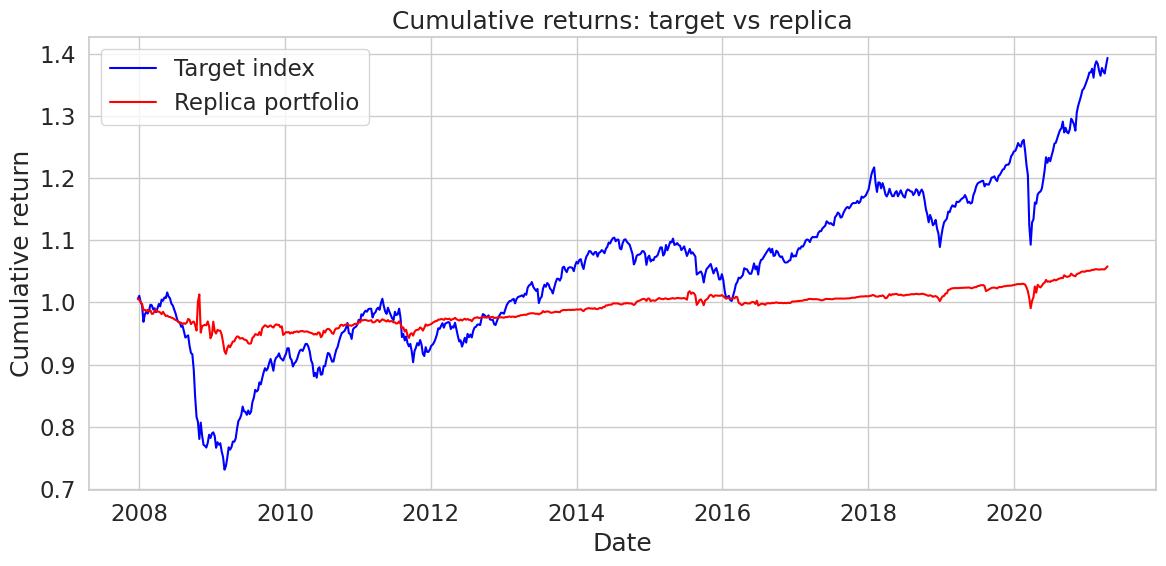

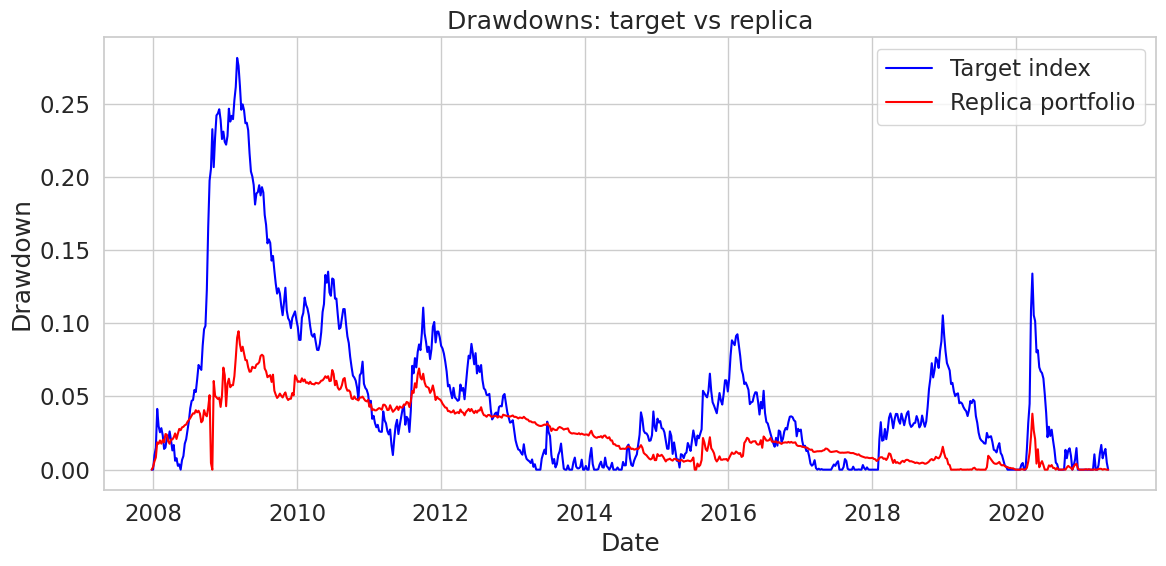

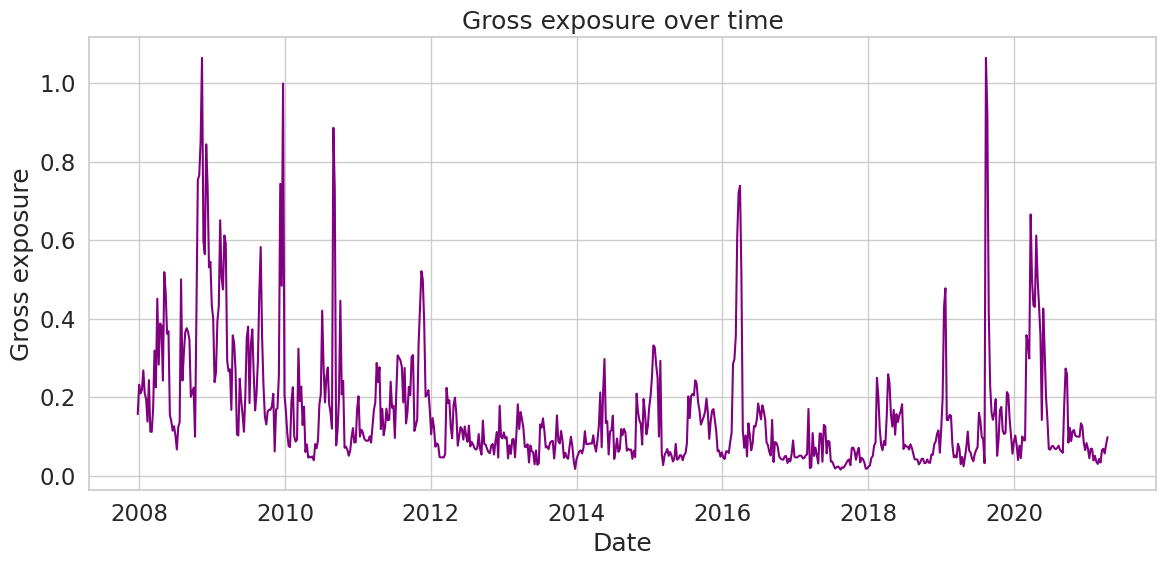

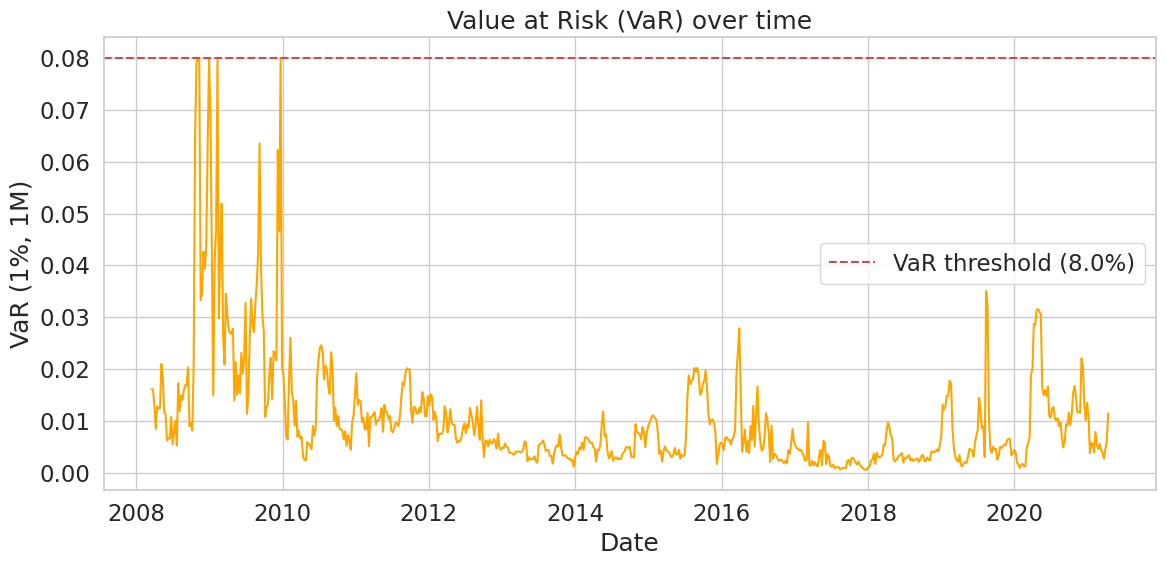

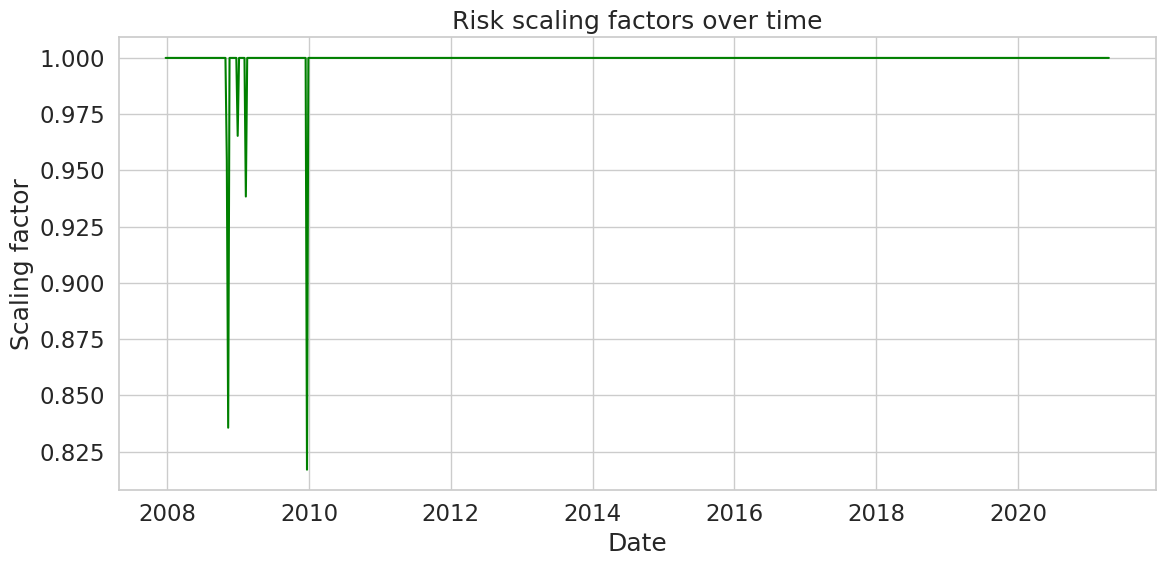

In [ ]:
# Create detailed metrics table for the best configuration
metrics_normalized = pd.DataFrame({
    'Metric': ['Annualized return', 'Annualized volatility', 'Sharpe ratio',
               'Max Drawdown', 'Tracking Error', 'Information ratio',
               'Correlation', 'Average gross exposure', 'Average VaR (1%, 1M)'],
    'Target': [f"{best_config_normalized['target_return']*100:.2f}%",
               f"{best_config_normalized['target_vol']*100:.2f}%",
               f"{best_config_normalized['target_sharpe']:.2f}",
               f"{best_config_normalized['max_drawdown']*100:.2f}%",
               "N/A",
               "N/A",
               "N/A",
               "N/A",
               "N/A"],
    'Replica': [f"{best_config_normalized['replica_return']*100:.2f}%",
                f"{best_config_normalized['replica_vol']*100:.2f}%",
                f"{best_config_normalized['replica_sharpe']:.2f}",
                f"{best_config_normalized['max_drawdown']*100:.2f}%",
                f"{best_config_normalized['tracking_error']*100:.2f}%",
                f"{best_config_normalized['information_ratio']:.2f}",
                f"{best_config_normalized['correlation']:.4f}",
                f"{best_config_normalized['avg_gross_exposure']:.4f}",
                f"{best_config_normalized['avg_var']*100:.2f}%"]
})

print("\nDetailed metrics for the best configuration (normalized returns):")
display(metrics_normalized)

# Plot cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(best_config_normalized['cumulative_target'], label='Target index', color='blue')
plt.plot(best_config_normalized['cumulative_replica'], label='Replica portfolio', color='red')
plt.title('Cumulative returns: target vs replica')
plt.xlabel('Date')
plt.ylabel('Cumulative return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot drawdowns
plt.figure(figsize=(12, 6))
target_drawdown = 1 - best_config_normalized['cumulative_target'] / best_config_normalized['cumulative_target'].cummax()
replica_drawdown = 1 - best_config_normalized['cumulative_replica'] / best_config_normalized['cumulative_replica'].cummax()
plt.plot(target_drawdown, label='Target index', color='blue')
plt.plot(replica_drawdown, label='Replica portfolio', color='red')
plt.title('Drawdowns: target vs replica')
plt.xlabel('Date')
plt.ylabel('Drawdown')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot gross exposure over time
plt.figure(figsize=(12, 6))
gross_exposure_series = pd.Series(best_config_normalized['gross_exposures'], index=best_config_normalized['replica_returns'].index)
plt.plot(gross_exposure_series, color='purple')
plt.title('Gross exposure over time')
plt.xlabel('Date')
plt.ylabel('Gross exposure')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot VaR over time
plt.figure(figsize=(12, 6))
var_series = pd.Series(best_config_normalized['var_values'], index=best_config_normalized['replica_returns'].index)
plt.plot(var_series, color='orange')
plt.axhline(y=max_var_threshold, color='r', linestyle='--', label=f'VaR threshold ({max_var_threshold*100}%)')
plt.title('Value at Risk (VaR) over time')
plt.xlabel('Date')
plt.ylabel('VaR (1%, 1M)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot scaling factors over time
plt.figure(figsize=(12, 6))
scaling_series = pd.Series(best_config_normalized['scaling_factors'], index=best_config_normalized['replica_returns'].index)
plt.plot(scaling_series, color='green')
plt.title('Risk scaling factors over time')
plt.xlabel('Date')
plt.ylabel('Scaling factor')
plt.grid(True)
plt.tight_layout()
plt.show()


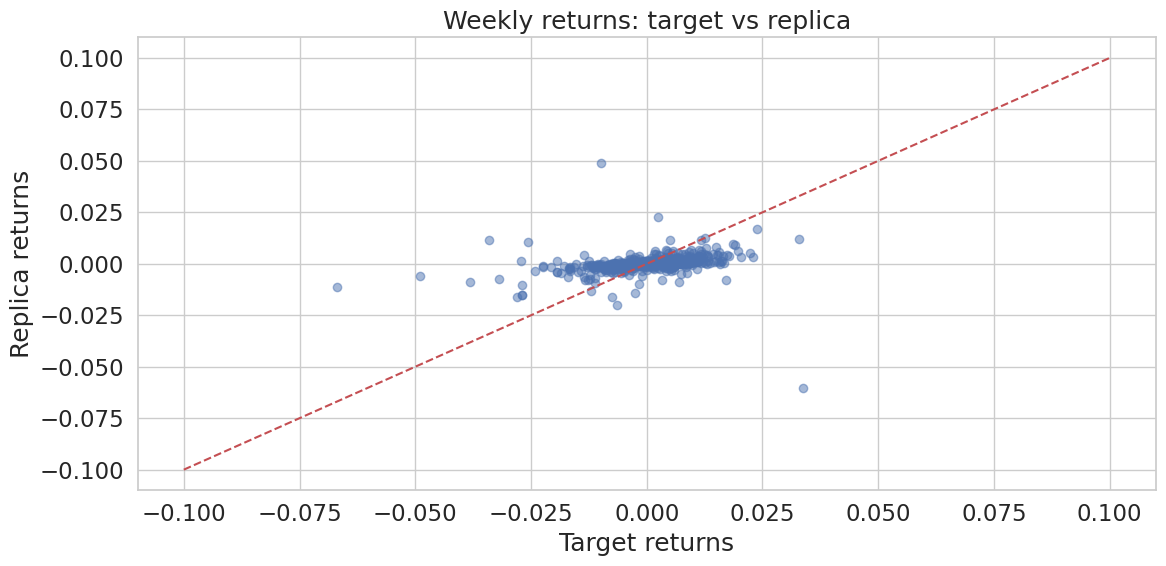

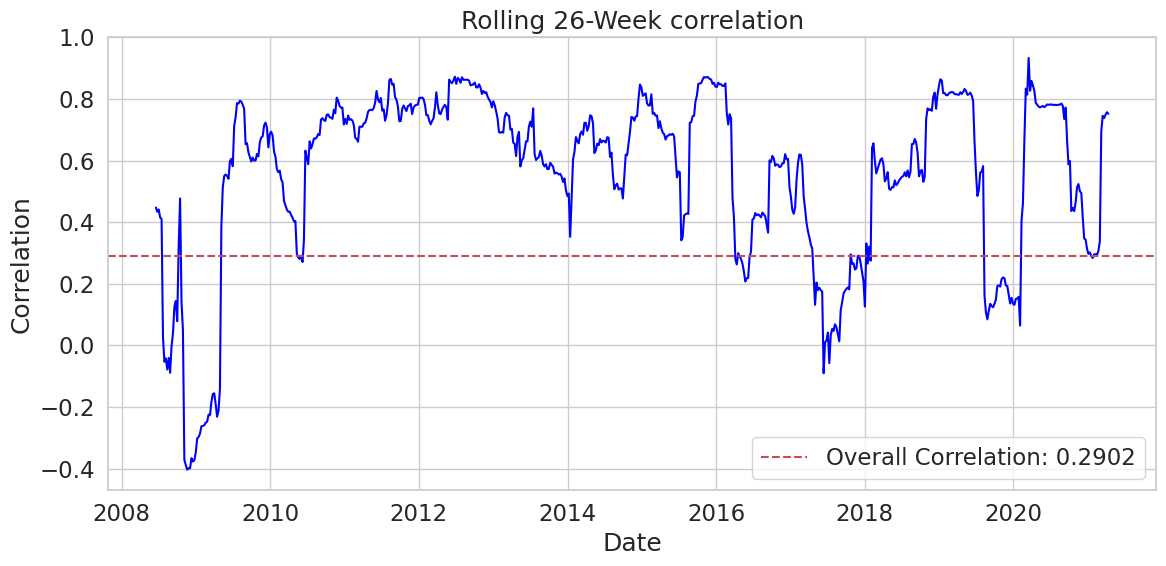

In [ ]:
# Plot weekly returns
plt.figure(figsize=(12, 6))
plt.scatter(best_config_normalized['aligned_target'], best_config_normalized['replica_returns'], alpha=0.5)
plt.plot([-0.1, 0.1], [-0.1, 0.1], 'r--')  # Diagonal line
plt.title('Weekly returns: target vs replica')
plt.xlabel('Target returns')
plt.ylabel('Replica returns')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot rolling correlation
plt.figure(figsize=(12, 6))
rolling_corr = best_config_normalized['replica_returns'].rolling(window=26).corr(best_config_normalized['aligned_target'])
plt.plot(rolling_corr, color='blue')
plt.title('Rolling 26-Week correlation')
plt.xlabel('Date')
plt.ylabel('Correlation')
plt.axhline(y=best_config_normalized['correlation'], color='r', linestyle='--',
            label=f'Overall Correlation: {best_config_normalized["correlation"]:.4f}')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

